 Determine the average signal yield and the error on its measure

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [1]:
import pandas
import uproot
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interpolate
import pickle
import zfit
import mplhep
from numpy import random 

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})

/Users/mariehartmann/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/zfit/__init__.py:48: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn("TensorFlow warnings are by default suppressed by zfit."
/Users/mariehartmann/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/zfit/util/execution.py:73: UserWarning: Not running on Linux. Determining available cpus for thread can failand be overestimated. Workaround (only if too many cpus are used):`zfit.run.set_n_cpu(your_cpu_number)`
  warnings.warn("Not running on Linux. Determining available cpus for thread can fail"


# Initialization of the data parameters

In [3]:
#Dowloading the data
bc_tree = uproot.open('root://eospublic.cern.ch//eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zbb_ecm91_EvtGen_Bc2TauNuTAUHADNU.root')['events']
bu_tree = uproot.open('root://eospublic.cern.ch//eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zbb_ecm91_EvtGen_Bu2TauNuTAUHADNU.root')['events']
bb_tree = uproot.open('root://eospublic.cern.ch//eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zbb_ecm91_EvtGen.root')['events']
cc_tree = uproot.open('root://eospublic.cern.ch//eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zcc_ecm91.root')['events']
qq_tree = uproot.open('root://eospublic.cern.ch//eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zuds_ecm91.root')['events']
tree_gen = uproot.open("root://eospublic.cern.ch//eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zbb_ecm91_EvtGen_Bc2TauNuTAUHADNU.root")["metadata"]

In [4]:
#Transforming the data into a dataframe
bc_df = bc_tree.arrays(library="pd", how="zip", filter_name=["EVT_*"])
bu_df = bu_tree.arrays(library="pd", how="zip", filter_name=["EVT_*"])
bb_df = bb_tree.arrays(library="pd", how="zip", filter_name=["EVT_*"])
cc_df = cc_tree.arrays(library="pd", how="zip", filter_name=["EVT_*"])
qq_df = qq_tree.arrays(library="pd", how="zip", filter_name=["EVT_*"])

#Getting general information on the data
df_gen = tree_gen.arrays(library="pd", how="zip")

In [5]:
#We consider as initial data the data whose MVAs are between 0.95 and 1

bc_sig = bc_df[bc_df['EVT_MVA2']> 0.95]
bc_sig = bc_sig[bc_sig['EVT_MVA1']> 0.95]

bu_bkg = bu_df[bu_df['EVT_MVA2']> 0.95]
bu_bkg = bu_bkg[bu_bkg['EVT_MVA1']> 0.95] 

bb_bkg = bb_df[bb_df['EVT_MVA2']> 0.95]
bb_bkg = bb_bkg[bb_bkg['EVT_MVA1']> 0.95] 

cc_bkg = cc_df[cc_df['EVT_MVA2']> 0.95]
cc_bkg = cc_bkg[cc_bkg['EVT_MVA1']> 0.95] 

qq_bkg = qq_df[qq_df['EVT_MVA2']> 0.95]
qq_bkg = qq_bkg[qq_bkg['EVT_MVA1']> 0.95]

In [22]:
#Number of Z0 produced
N_Z0_init = 5*10**(12)
N_Z0 = 5*10**(12)

#Branching fraction Z->quark-pair
BF_Zbb = 0.1512
BF_Zcc = 0.1203
BF_Zqq = 0.4276

#Production ratio of Bc+ and B+
f_Bc = 0.0004
f_Bu = 0.43

#Branching fraction Bc+->tau nu B+->tau nu and tau->3pions
BF_Bctaunu = 0.0194
BF_Butaunu = 1.09*10**(-4)
BF_tau3pion = 0.0931

In [23]:
#Definition of the functions computing the different yields
def S_bc_cut(initial_eff, cut_eff) :
    return (N_Z0*BF_Zbb*2*f_Bc*BF_Bctaunu*BF_tau3pion)*initial_eff*cut_eff

def B_bu_cut(initial_eff, cut_eff) :
    return (N_Z0*BF_Zbb*2*f_Bu*BF_Butaunu*BF_tau3pion)*initial_eff*cut_eff

def B_bb_cut(initial_eff, cut_eff) :
    return (N_Z0*BF_Zbb*2)*initial_eff*cut_eff

def B_cc_cut(initial_eff, cut_eff) :
    return (N_Z0*BF_Zcc*2)*initial_eff*cut_eff

def B_qq_cut(initial_eff, cut_eff) :
    return (N_Z0*BF_Zqq*2)*initial_eff*cut_eff

#Dowloading the splines to compute the number of inclusive background events

bb_spline_MVA1_log = pickle.load(open(r'../Finding_the_best_MVA_cut/2D_plot/Spline_functions/MVA1_spline_log.pkl','rb'))
bb_spline_MVA2_log = pickle.load(open(r'/Users/mariehartmann/Stage_M1/Stage_M1/Bc_to_tau_nu/Finding_the_best_MVA_cut/2D_plot/Spline_functions/MVA2_spline_log.pkl','rb'))

cc_spline_MVA1_log = pickle.load(open(r'/Users/mariehartmann/Stage_M1/Stage_M1/Bc_to_tau_nu/Finding_the_best_MVA_cut/2D_plot/Spline_functions/cc_MVA1_spline_log.pkl','rb'))
cc_spline_MVA2_log = pickle.load(open(r'/Users/mariehartmann/Stage_M1/Stage_M1/Bc_to_tau_nu/Finding_the_best_MVA_cut/2D_plot/Spline_functions/cc_MVA2_spline_log.pkl','rb'))

#qq_spline_MVA1_log = pickle.load(open(r'/Users/mariehartmann/Stage_M1/Stage_M1/Bc_to_tau_nu/Finding_the_best_MVA_cut/2D_plot/Spline_functions/uds_MVA1_spline_log.pkl','rb'))
#qq_spline_MVA2_log = pickle.load(open(r'/Users/mariehartmann/Stage_M1/Stage_M1/Bc_to_tau_nu/Finding_the_best_MVA_cut/2D_plot/Spline_functions/uds_MVA2_spline_log.pkl','rb'))

#http://localhost:8912/tree/Stage_M1/Stage_M1/Bc_to_tau_nu/Finding_the_best_MVA_cut/2D_plot/Spline_functions

In [24]:
#Initialization of the number of events in the MVAs for all contributions
nb_total_events = df_gen.iloc[0]["eventsProcessed"]
nb_bc_events = len(bc_sig)
nb_bu_events = len(bu_bkg)
nb_bb_events = len(bb_bkg)
nb_cc_events = len(cc_bkg)
#nb_qq_events = len(qq_bkg)

#Initialization of the number of events for both MVAs for inclusive backgrounds
nb_bb_events_1 = interpolate.splint(-np.log(1-0.95), 9, bb_spline_MVA1_log)
nb_cc_events_1 = interpolate.splint(-np.log(1-0.95), 9, cc_spline_MVA1_log)
#nb_qq_events_1 = interpolate.splint(-np.log(1-0.95), 8, qq_spline_MVA1_log)

nb_bb_events_2 = interpolate.splint(-np.log(1-0.95), 8, bb_spline_MVA2_log)
nb_cc_events_2 = interpolate.splint(-np.log(1-0.95), 7, cc_spline_MVA2_log)
#nb_qq_events_2 = interpolate.splint(-np.log(1-0.95), 5.8, qq_spline_MVA2_log)

#Computing of the initial efficiencies for all backgrounds
initial_eff_bc_sig = nb_bc_events / nb_total_events
initial_eff_bu_bkg = nb_bu_events / nb_total_events
initial_eff_bb_bkg = nb_bb_events / nb_total_events
initial_eff_cc_bkg = nb_cc_events / nb_total_events
#initial_eff_qq_bkg = nb_qq_events / nb_total_events

print('eff sig {}'.format(initial_eff_bc_sig))
#print('eff bkg {}'.format(initial_eff_qq_bkg))

eff sig 0.2320645


In [25]:
#Optimized MVAs
Optimized_MVA1 = 0.9998599999999961  #+-0.00001
Optimized_MVA2 = 0.9963399999999984 #+-0.00001

Optimized_MVA1_log = -np.log(1-Optimized_MVA1)
Optimized_MVA2_log = -np.log(1-Optimized_MVA2)

#Applying the MVA2 cut on the dataframe
df_bc_sig = bc_sig[bc_sig['EVT_MVA1']>Optimized_MVA1]
df_bc_sig = df_bc_sig[df_bc_sig['EVT_MVA2']>Optimized_MVA2]

df_bu_bkg = bu_bkg[bu_bkg['EVT_MVA1']>Optimized_MVA1]
df_bu_bkg = df_bu_bkg[df_bu_bkg['EVT_MVA2']>Optimized_MVA2]
          
#Counting the number of events in the Bc+ and B+ dataframes after the cut
nb_bc_after_cut = len(df_bc_sig)
nb_bu_after_cut = len(df_bu_bkg)
          
#Counting the number of events left for each MVAs for inclusive backgrounds
nb_bb_after_cut_1 = interpolate.splint(Optimized_MVA1_log, 9, bb_spline_MVA1_log)
nb_bb_after_cut_2 = interpolate.splint(Optimized_MVA2_log, 8, bb_spline_MVA2_log)
        
nb_cc_after_cut_1 = interpolate.splint(Optimized_MVA1_log, 9, cc_spline_MVA1_log)
nb_cc_after_cut_2 = interpolate.splint(Optimized_MVA2_log, 7, cc_spline_MVA2_log)
        
#nb_qq_after_cut_1 = interpolate.splint(Optimized_MVA1_log, 8, qq_spline_MVA1_log)
#nb_qq_after_cut_2 = interpolate.splint(Optimized_MVA2_log, 5.8, qq_spline_MVA2_log)

        
#Computing the efficiencies
cut_eff_bc_sig = nb_bc_after_cut / nb_bc_events
        
cut_eff_bu_bkg = nb_bu_after_cut / nb_bu_events
cut_eff_bb_bkg = (nb_bb_after_cut_1 / nb_bb_events_1) * (nb_bb_after_cut_2 / nb_bb_events_2)
cut_eff_cc_bkg = (nb_cc_after_cut_1 / nb_cc_events_1) * (nb_cc_after_cut_2 / nb_cc_events_2)
#cut_eff_qq_bkg = (nb_qq_after_cut_1 / nb_qq_events_1) * (nb_qq_after_cut_2 / nb_qq_events_2)
print(cut_eff_bu_bkg)
print(cut_eff_bb_bkg)
print(cut_eff_cc_bkg)
#print(cut_eff_qq_bkg)
        
    
#Signal, Background and Purity
S = S_bc_cut(initial_eff_bc_sig, cut_eff_bc_sig)
B = B_bb_cut(initial_eff_bb_bkg, cut_eff_bb_bkg) + B_cc_cut(initial_eff_cc_bkg, cut_eff_cc_bkg) + B_bu_cut(initial_eff_bu_bkg, cut_eff_bu_bkg) #+ B_qq_cut(initial_eff_qq_bkg, cut_eff_qq_bkg)
P = S/(S+B)

print('Number of signal events = {}'.format(S))
print('Number of bkg events = {}'.format(B))
print('Purity = {}'.format(P))

N_BC = S_bc_cut(initial_eff_bc_sig, cut_eff_bc_sig)

N_BU = B_bu_cut(initial_eff_bu_bkg, cut_eff_bu_bkg)
N_BB = B_bb_cut(initial_eff_bb_bkg, cut_eff_bb_bkg)
N_CC = B_cc_cut(initial_eff_cc_bkg, cut_eff_cc_bkg)
#N_QQ = B_qq_cut(initial_eff_qq_bkg, cut_eff_qq_bkg)

N_BB_CC = N_BB + N_CC

print('N_BC = {}'.format(N_BC))
print('N_BU = {}'.format(N_BU))
print('N_BB = {}'.format(N_BB))
print('N_CC = {}'.format(N_CC))
#print('N_QQ = {}'.format(N_QQ))

0.0007226931575174898
3.137790945458242e-06
1.797967906975173e-06
Number of signal events = 4009.2649482816005
Number of bkg events = 4472.890969373205
Purity = 0.4726705082061383
N_BC = 4009.2649482816005
N_BU = 241.47796710240002
N_BB = 3615.187011064041
N_CC = 616.2259912067639


# Initialization of the fits parameters

### Initialization of the data of reference

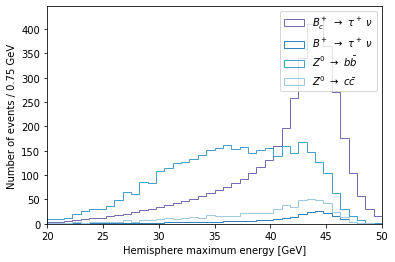

[]

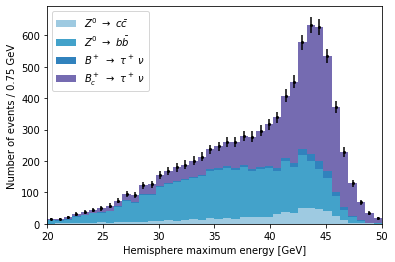

In [26]:
variable = 'EVT_ThrustEmax_E'

nb_bins = int(40/np.sqrt(N_Z0_init/N_Z0))
min_bin = 20
max_bin = 50

name_bc = r"$B_c^+$ $\rightarrow$ $\tau^+$ $\nu$ "
name_bu = r"$B^+$ $\rightarrow$ $\tau^+$ $\nu$ "
name_bb = r"$Z^0$ $\rightarrow$ $b\bar{b}$ "
name_cc = r"$Z^0$ $\rightarrow$ $c\bar{c}$ "

colour_bc = "#756bb1"
colour_bu = "#3182bd" #"#2c7fb8" #
colour_bb = "#43a2ca" #"#edf8b1" #"#a6bddb"
colour_cc = "#9ecae1" #"#7fcdbb" #

counts_bc, bins_bc = np.histogram(bc_sig[variable], bins = nb_bins, range = (min_bin, max_bin))
counts_bu, bins_bu = np.histogram(bu_bkg[variable], bins = nb_bins, range = (min_bin, max_bin))
counts_bb, bins_bb = np.histogram(bb_bkg[variable], bins = nb_bins, range = (min_bin, max_bin))
counts_cc, bins_cc = np.histogram(cc_bkg[variable], bins = nb_bins, range = (min_bin, max_bin))

counts_bc = (counts_bc/np.sum(counts_bc)) * N_BC
counts_bu = (counts_bu/np.sum(counts_bu)) * N_BU
counts_bb = (counts_bb/np.sum(counts_bb)) * N_BB
counts_cc = (counts_cc/np.sum(counts_cc)) * N_CC

plt.figure()
plt.hist(bins_bc[:-1], bins_bc, weights=counts_bc, histtype='step', color= colour_bc, label=name_bc)
plt.hist(bins_bu[:-1], bins_bu, weights=counts_bu, histtype='step', color= colour_bu, label=name_bu)
plt.hist(bins_bb[:-1], bins_bb, weights=counts_bb, histtype='step', color= colour_bb, label=name_bb)
plt.hist(bins_cc[:-1], bins_bb, weights=counts_cc, histtype='step', color= colour_cc, label=name_cc)
plt.legend()
plt.xlim(min_bin,max_bin)
plt.xlabel("Hemisphere maximum energy [GeV]")
plt.ylabel("Number of events / {} GeV".format(round((max_bin-min_bin)/nb_bins,3)))
plt.show()

x = [bins_bb[:-1], bins_cc[:-1], bins_bu[:-1], bins_bc[:-1]]
bins = bins_bc
weights = [counts_cc, counts_bb, counts_bu, counts_bc ]
colour = [colour_cc, colour_bb, colour_bu, colour_bc]
name = [name_cc, name_bb, name_bu, name_bc]

plt.figure()
counts, bin_edges, _ = plt.hist(x, bins, weights=weights, color=colour, label=name, stacked=True)
bin_centres = (bin_edges[:-1]+ bin_edges[1:])/2
err = np.sqrt(counts[3])
plt.errorbar(bin_centres, counts[3], yerr=err, fmt='o', color='k', markersize=2)

plt.xlim(min_bin,max_bin)
plt.xlabel("Hemisphere maximum energy [GeV]")
plt.ylabel("Number of events / {} GeV".format(round((max_bin-min_bin)/nb_bins,3)))
plt.legend()
plt.plot()

### Creating the templates

In [27]:
#Getting the right bins_edges size
_ , bins_edges = np.histogram(a=bin_edges[:-1], bins=bin_edges, weights=counts[2])

#Templates and templates normalisation
template_yield_bc, _ = np.histogram(a=bins_bc[:-1], bins=bins_edges, weights=counts_bc)
template_yield_bu, _ = np.histogram(a=bins_bu[:-1], bins=bins_edges, weights=counts_bu)
template_yield_bb, _ = np.histogram(a=bins_bb[:-1], bins=bins_edges, weights=counts_bb)
template_yield_cc, _ = np.histogram(a=bins_cc[:-1], bins=bins_edges, weights=counts_cc)
    
template_yield_bc = template_yield_bc/np.sum(template_yield_bc)
template_yield_bu = template_yield_bu/np.sum(template_yield_bu)
template_yield_bb = template_yield_bb/np.sum(template_yield_bb)
template_yield_cc = template_yield_cc/np.sum(template_yield_cc)
 
#Checking if there are zero bins    
print(template_yield_bc)
print(template_yield_bu)
print(template_yield_bb)
print(template_yield_cc)

[0.00091328 0.00115179 0.00146445 0.00185127 0.00222378 0.00276498
 0.00318519 0.00389292 0.00451564 0.00524028 0.00600394 0.00692026
 0.00765443 0.00862799 0.00965141 0.01054691 0.01163842 0.01292333
 0.01425595 0.01571173 0.01728937 0.01908123 0.0210331  0.02304309
 0.02585881 0.02897939 0.03294689 0.0398936  0.04928222 0.06423332
 0.08470961 0.10241745 0.10611305 0.09125822 0.06730749 0.04388712
 0.02600365 0.01426159 0.00742286 0.00384001]
[0.00132701 0.00162455 0.00219185 0.00262229 0.0034058  0.00415361
 0.00458206 0.00559567 0.00632959 0.00694252 0.00747411 0.00891617
 0.00974729 0.01069544 0.0116059  0.01208196 0.01319475 0.01440275
 0.01546594 0.01667394 0.0185385  0.02036339 0.02245408 0.02496529
 0.02676836 0.02970603 0.03375055 0.03963185 0.0473916  0.06097711
 0.08089618 0.10047407 0.10797398 0.09323006 0.06366089 0.03730313
 0.01903241 0.00866823 0.00362796 0.00155314]
[0.00290621 0.00250991 0.00317041 0.00554822 0.00713342 0.00832232
 0.00845443 0.01017173 0.01360634 0.0

### Creating the function that we will use for the fit

In [28]:
#When considering only Z->bb and Bu for background
#def get_template(yield_sig, yield_bkg):
# return yield_sig*template_process1 + N_BU*template_process2 + yield_bkg*template_process3

#When considering Z->bb, Z->cc and Bu for background
def get_template(yield_bc, yield_bu, yield_bb_cc): 
    return yield_bc*template_yield_bc + yield_bu*template_yield_bu + yield_bb_cc*((N_BB/N_BB_CC)*template_yield_bb + (N_CC/N_BB_CC)*template_yield_cc)
    
def binned_nll(template, sample_hist):
    return np.sum(template - sample_hist + sample_hist * np.log((sample_hist + 1*10**(-14)) / (template + 1*10**(-14))))
  # 1e-14 added in case there are empty bins

def loss(x):
    # by default, `x` is an `OrderedSet` of zfit parameters.
    x = np.array(x)

    print("Value of the parameters", x)
  
    # The first parameter is the Bc yield 
    yield_bc = x[0]
    # The second parameter is the Bu yield 
    yield_bu = x[1]
    # The second parameter is the Z->bb and Z->cc combined yield 
    yield_bb_cc = x[2]

    template = get_template(yield_bc, yield_bu, yield_bb_cc)

    nll = binned_nll(template, sample_hist)
    
    #Gaussian constraint on B+ -> tau nu yield
    nll += (yield_bu - N_BU)**2/2./N_BU*0.05

    return nll

loss.errordef = 0.5 # 0.5 for a log-likelihood
# We would set this parameter at 1 for a chi2 loss function.

# Toy samples

In [29]:
#Theoretical value of the yields parameters to give initial value to the fit parameters
print('N_BC = {}'.format(N_BC))
print('N_BU = {}'.format(N_BU))
print('N_BB_CC = {}'.format(N_BB_CC))

N_BC = 4009.2649482816005
N_BU = 241.47796710240002
N_BB_CC = 4231.413002270805


### Creating and Fitting multiple toy samples

In [ ]:
n_loop = 2000
bc_yield = np.zeros(n_loop)
bu_yield = np.zeros(n_loop)
bb_cc_yield = np.zeros(n_loop)

bc_yield_error = np.zeros(n_loop)
bu_yield_error = np.zeros(n_loop)
bb_cc_yield_error = np.zeros(n_loop)

for i in range (n_loop) :
    
    #Toy sample
    data = np.random.poisson(counts[3])
    sample_hist, bins_edges = np.histogram(a=bin_edges[:-1], bins=bin_edges, weights=data)
    print(sample_hist)

    #Initialisation of the parameters
    i_rand = random.randint(0,1000000000000,size=1)
    
    initial_params = {
            'value': [4000, 250, 4000],
            'lower' : [-1000., -1000., -1000.], # optional
            'upper': [10000., 10000., 10000.], # optional
            'name': [f"bc_yield_{i_rand}", f"bu_yield_{i_rand}", f"bb_cc_yield_{i_rand}"] # optional
        }

    
    #Fit
    minimiser = zfit.minimize.Minuit(verbosity=5)
    zfit.run.set_autograd_mode(False)
    zfit.run.set_graph_mode(False)
    
    #Extracting the informations
    result = minimiser.minimize(loss, initial_params)
    params = result.params
    params_hesse = result.hesse() #Computation of the errors
    corr = result.correlation(method="minuit_hesse")
    
    print(result.info['original'])
    print(params)
    print('correction {}'.format(corr))

    #Extracting the yield results
    bc_yield[i] = params[f"bc_yield_{i_rand}"]['value']
    bu_yield[i] = params[f"bu_yield_{i_rand}"]['value']
    bb_cc_yield[i] = params[f"bb_cc_yield_{i_rand}"]['value']
    
    bc_yield_error[i] = params[f"bc_yield_{i_rand}"]['minuit_hesse']['error']
    bu_yield_error[i] = params[f"bu_yield_{i_rand}"]['minuit_hesse']['error']
    bb_cc_yield_error[i] = params[f"bb_cc_yield_{i_rand}"]['minuit_hesse']['error']
    

[ 15  19  15  31  32  49  46  51  82 107  88 116 128 130 175 164 169 203
 209 245 251 243 246 289 276 271 330 321 441 479 551 634 592 527 362 227
 130  70  29  21]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.23339341  250.         4000.        ]
Value of the parameters [3999.7666075  250.        4000.       ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.15028675 4000.        ]
Value of the parameters [4000.          249.84972113 4000.        ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4000.          250.         4000.23068293]
Value of the parameters [4000.          250.      

Value of the parameters [3876.50338834  204.97415727 4347.0377797 ]
Value of the parameters [3804.29503566  236.30571549 4381.09947973]
Value of the parameters [3804.52347167  236.30571549 4381.09947973]
Value of the parameters [3804.06660087  236.30571549 4381.09947973]
Value of the parameters [3804.29503566  236.45488949 4381.09947973]
Value of the parameters [3804.29503566  236.15654936 4381.09947973]
Value of the parameters [3804.29503566  236.30571549 4381.3297632 ]
Value of the parameters [3804.29503566  236.30571549 4380.86919647]
Value of the parameters [3807.72941346  238.24222044 4374.3492962 ]
Value of the parameters [3807.95719201  238.24222044 4374.3492962 ]
Value of the parameters [3807.50163612  238.24222044 4374.3492962 ]
Value of the parameters [3807.72941346  238.38823424 4374.3492962 ]
Value of the parameters [3807.72941346  238.09621415 4374.3492962 ]
Value of the parameters [3807.72941346  238.24222044 4374.58006191]
Value of the parameters [3807.72941346  238.2422

Value of the parameters [3734.08720481  242.45859557 4553.86076024]
Value of the parameters [3734.08720481  242.4898312  4553.91058182]
Value of the parameters [3734.08720481  242.4898312  4553.81093866]
Value of the parameters [3734.33097639  242.64601453 4553.86076024]
Value of the parameters [3734.33097639  242.4898312  4554.1098681 ]
Value of the parameters [3734.08720481  242.64601453 4554.1098681 ]
Value of the parameters [3734.08720481  242.4898312  4553.86076024]
Value of the parameters [3734.135959    242.4898312  4553.86076024]
Value of the parameters [3734.03845067  242.4898312  4553.86076024]
Value of the parameters [3734.08720481  242.52106718 4553.86076024]
Value of the parameters [3734.08720481  242.45859557 4553.86076024]
Value of the parameters [3734.08720481  242.4898312  4553.91058182]
Value of the parameters [3734.08720481  242.4898312  4553.81093866]
Value of the parameters [3734.09695564  242.4898312  4553.86076024]
Value of the parameters [3734.07745398  242.4898

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[966270665710]        3564     +/- 1.4e+02       False
bu_yield_[966270665710]       238.8     +/-      69       False
bb_cc_yield_[966270665710]     4600     +/- 1.3e+02       False
correction [[ 1.         -0.44430027 -0.62340445]
 [-0.44430027  1.         -0.06498417]
 [-0.62340445 -0.06498417  1.        ]]
[ 17  14  13  38  36  49  41  58  78  96  88 102 107 143 155 176 194 189
 219 226 227 229 261 297 263 317 348 334 390 490 579 641 654 559 422 227
 138  64  33  18]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.27843137  250.         4000.        ]
Value of the parameters [3999.72156992  250.         4000.     

Value of the parameters [4044.67780497  266.22726365 4066.98328492]
Value of the parameters [4044.67780497  266.44240673 4067.31163044]
Value of the parameters [4044.67780497  266.44240673 4066.65494095]
Value of the parameters [4033.54013654  247.76362866 4099.32720166]
Value of the parameters [4021.37160369  227.49083553 4134.68705739]
Value of the parameters [4021.70647963  227.49083553 4134.68705739]
Value of the parameters [4021.03672953  227.49083553 4134.68705739]
Value of the parameters [4021.37160369  227.70012839 4134.68705739]
Value of the parameters [4021.37160369  227.28155827 4134.68705739]
Value of the parameters [4021.37160369  227.49083553 4135.01872567]
Value of the parameters [4021.37160369  227.49083553 4134.35539044]
Value of the parameters [4012.10498167  230.43444929 4140.82764377]
Value of the parameters [3987.15836376  238.37647479 4157.36554206]
Value of the parameters [3987.49194326  238.37647479 4157.36554206]
Value of the parameters [3986.82478616  238.3764

Value of the parameters [4094.28115337  244.91428072 4148.39665788]
Value of the parameters [4094.54130174  245.07935843 4148.44844022]
Value of the parameters [4094.54130174  244.91428072 4148.70735239]
Value of the parameters [4094.28115337  245.07935843 4148.70735239]
Value of the parameters [4094.28115337  244.91428072 4148.44844022]
Value of the parameters [4094.33318297  244.91428072 4148.44844022]
Value of the parameters [4094.2291238   244.91428072 4148.44844022]
Value of the parameters [4094.28115337  244.9472955  4148.44844022]
Value of the parameters [4094.28115337  244.88126632 4148.44844022]
Value of the parameters [4094.28115337  244.91428072 4148.50022259]
Value of the parameters [4094.28115337  244.91428072 4148.39665788]
Value of the parameters [4094.29155928  244.91428072 4148.44844022]
Value of the parameters [4094.27074745  244.91428072 4148.44844022]
Value of the parameters [4094.28115337  244.92088364 4148.44844022]
Value of the parameters [4094.28115337  244.9076

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[920494004199]        3852     +/- 1.4e+02       False
bu_yield_[920494004199]       247.2     +/-      69       False
bb_cc_yield_[920494004199]     4299     +/- 1.3e+02       False
correction [[ 1.         -0.44355728 -0.62439004]
 [-0.44355728  1.         -0.06319425]
 [-0.62439004 -0.06319425  1.        ]]
[ 14  20  21  34  48  50  54  49  81 106 109 131 113 186 167 174 179 209
 229 248 252 258 290 260 275 308 351 318 394 453 579 620 591 517 356 248
 141  71  37  20]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.30688013  250.         4000.        ]
Value of the parameters [3999.69312144  250.         4000.     

Value of the parameters [4097.37938566  290.42663613 4129.06867378]
Value of the parameters [4097.37938566  290.6199733  4129.35721977]
Value of the parameters [4097.37938566  290.6199733  4128.78012883]
Value of the parameters [4082.93746669  257.28192842 4182.18829302]
Value of the parameters [4067.94492325  223.0685322  4237.37588283]
Value of the parameters [4068.24083759  223.0685322  4237.37588283]
Value of the parameters [4067.64901017  223.0685322  4237.37588283]
Value of the parameters [4067.94492325  223.25019854 4237.37588283]
Value of the parameters [4067.94492325  222.88687767 4237.37588283]
Value of the parameters [4067.94492325  223.0685322  4237.66812024]
Value of the parameters [4067.94492325  223.0685322  4237.08364616]
Value of the parameters [4054.09531839  226.96833048 4249.20710752]
Value of the parameters [4018.24911913  237.09096155 4279.84599051]
Value of the parameters [4018.54307727  237.09096155 4279.84599051]
Value of the parameters [4017.95516238  237.0909

Value of the parameters [4078.61837984  244.7700437  4098.12873509]
Value of the parameters [4078.87822673  244.9327878  4098.18030782]
Value of the parameters [4078.87822673  244.7700437  4098.43817198]
Value of the parameters [4078.61837984  244.9327878  4098.43817198]
Value of the parameters [4078.61837984  244.7700437  4098.18030782]
Value of the parameters [4078.67034915  244.7700437  4098.18030782]
Value of the parameters [4078.56641058  244.7700437  4098.18030782]
Value of the parameters [4078.61837984  244.80259178 4098.18030782]
Value of the parameters [4078.61837984  244.737496   4098.18030782]
Value of the parameters [4078.61837984  244.7700437  4098.23188058]
Value of the parameters [4078.61837984  244.7700437  4098.12873509]
Value of the parameters [4078.6287737   244.7700437  4098.18030782]
Value of the parameters [4078.60798599  244.7700437  4098.18030782]
Value of the parameters [4078.61837984  244.77655329 4098.18030782]
Value of the parameters [4078.61837984  244.7635

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[782863667070]        4015     +/- 1.4e+02       False
bu_yield_[782863667070]       245.8     +/-      69       False
bb_cc_yield_[782863667070]     4338     +/- 1.3e+02       False
correction [[ 1.         -0.43706789 -0.63090307]
 [-0.43706789  1.         -0.06140619]
 [-0.63090307 -0.06140619  1.        ]]
[ 14  18  20  28  39  34  37  61  72  79  80 124 118 159 158 197 192 209
 199 231 262 246 256 320 273 307 346 335 412 431 597 680 630 534 376 227
 131  69  40  14]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.27323755  250.         4000.        ]
Value of the parameters [3999.7267637  250.        4000.       

Value of the parameters [4075.8458911   282.12434097 4139.91317543]
Value of the parameters [4075.30012116  282.12434097 4139.91317543]
Value of the parameters [4075.5730056   282.30311539 4139.91317543]
Value of the parameters [4075.5730056   281.94557737 4139.91317543]
Value of the parameters [4075.5730056   282.12434097 4140.18057213]
Value of the parameters [4075.5730056   282.12434097 4139.6457796 ]
Value of the parameters [4035.80801652  246.68501253 4216.22277509]
Value of the parameters [3983.94240062  201.08177678 4315.90499168]
Value of the parameters [3984.2105506   201.08177678 4315.90499168]
Value of the parameters [3983.67425187  201.08177678 4315.90499168]
Value of the parameters [3983.94240062  201.24547848 4315.90499168]
Value of the parameters [3983.94240062  200.91808486 4315.90499168]
Value of the parameters [3983.94240062  201.08177678 4316.16903769]
Value of the parameters [3983.94240062  201.08177678 4315.64094608]
Value of the parameters [3954.94355651  211.8300

Value of the parameters [4097.12367464  240.13800834 4220.85882055]
Value of the parameters [4097.2958735   240.13800834 4220.85882055]
Value of the parameters [4096.95147618  240.13800834 4220.85882055]
Value of the parameters [4097.12367464  240.2472497  4220.85882055]
Value of the parameters [4097.12367464  240.02877118 4220.85882055]
Value of the parameters [4097.12367464  240.13800834 4221.03060993]
Value of the parameters [4097.12367464  240.13800834 4220.68703144]
Value of the parameters [4097.12367464  240.13800834 4220.85882055]
Value of the parameters [4097.2958735   240.13800834 4220.85882055]
Value of the parameters [4096.95147618  240.13800834 4220.85882055]
Value of the parameters [4097.12367464  240.2472497  4220.85882055]
Value of the parameters [4097.12367464  240.02877118 4220.85882055]
Value of the parameters [4097.12367464  240.13800834 4221.03060993]
Value of the parameters [4097.12367464  240.13800834 4220.68703144]
Value of the parameters [4097.15811438  240.1380

Value of the parameters [4141.05429669  241.31515771 4111.65776266]
Value of the parameters [4141.10172825  241.31515771 4111.65776266]
Value of the parameters [4141.00686515  241.31515771 4111.65776266]
Value of the parameters [4141.05429669  241.34525133 4111.65776266]
Value of the parameters [4141.05429669  241.2850644  4111.65776266]
Value of the parameters [4141.05429669  241.31515771 4111.70488825]
Value of the parameters [4141.05429669  241.31515771 4111.6106371 ]
Value of the parameters [4141.063783    241.31515771 4111.65776266]
Value of the parameters [4141.04481038  241.31515771 4111.65776266]
Value of the parameters [4141.05429669  241.3211764  4111.65776266]
Value of the parameters [4141.05429669  241.30913902 4111.65776266]
Value of the parameters [4141.05429669  241.31515771 4111.66718778]
Value of the parameters [4141.05429669  241.31515771 4111.64833755]
Value of the parameters [4141.10172825  241.34525133 4111.65776266]
Value of the parameters [4141.10172825  241.3151

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[709768943605]        3861     +/- 1.4e+02       False
bu_yield_[709768943605]       238.9     +/-      69       False
bb_cc_yield_[709768943605]     4355     +/- 1.2e+02       False
correction [[ 1.         -0.4437203  -0.61956594]
 [-0.4437203   1.         -0.06496051]
 [-0.61956594 -0.06496051  1.        ]]
[ 13  10  18  33  41  55  52  73  90  91  97 143 129 179 189 154 195 219
 217 228 264 272 270 269 267 310 285 326 401 443 566 649 613 593 366 218
 128  66  33  19]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       

Value of the parameters [4047.78144889  270.04856401 4065.0673814 ]
Value of the parameters [4047.78144889  270.24291241 4065.3632346 ]
Value of the parameters [4047.78144889  270.24291241 4064.77152946]
Value of the parameters [4038.76140153  254.75318773 4092.57456752]
Value of the parameters [4028.81827143  237.7718464  4122.91302253]
Value of the parameters [4029.12017949  237.7718464  4122.91302253]
Value of the parameters [4028.51636481  237.7718464  4122.91302253]
Value of the parameters [4028.81827143  237.96113459 4122.91302253]
Value of the parameters [4028.81827143  237.58257086 4122.91302253]
Value of the parameters [4028.81827143  237.7718464  4123.21212255]
Value of the parameters [4028.81827143  237.7718464  4122.61392364]
Value of the parameters [4021.25145238  240.34530488 4128.03317743]
Value of the parameters [4001.28859469  247.14732713 4141.54575602]
Value of the parameters [4001.58957465  247.14732713 4141.54575602]
Value of the parameters [4000.98761624  247.1473

Value of the parameters [3990.32069358  236.02777541 4286.92191958]
Value of the parameters [3990.38266193  236.06728876 4286.92191958]
Value of the parameters [3990.38266193  235.98826262 4286.92191958]
Value of the parameters [3990.38266193  236.02777541 4286.98414827]
Value of the parameters [3990.38266193  236.02777541 4286.85969093]
Value of the parameters [3990.69250468  236.22534767 4286.92191958]
Value of the parameters [3990.69250468  236.02777541 4287.23306328]
Value of the parameters [3990.38266193  236.22534767 4287.23306328]
Value of the parameters [3990.38266193  236.02777541 4286.92191958]
Value of the parameters [3990.44463035  236.02777541 4286.92191958]
Value of the parameters [3990.32069358  236.02777541 4286.92191958]
Value of the parameters [3990.38266193  236.06728876 4286.92191958]
Value of the parameters [3990.38266193  235.98826262 4286.92191958]
Value of the parameters [3990.38266193  236.02777541 4286.98414827]
Value of the parameters [3990.38266193  236.0277

Value of the parameters [4172.41864899  239.41597255 4053.37521463]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 19.91                      │              Nfcn = 61               │
│ EDM = 2.02e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[647944882361]        4172     +/- 

Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.24512243  250.         4000.        ]
Value of the parameters [3999.75487857  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.15768344 4000.        ]
Value of the parameters [4000.          249.84232523 4000.        ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4000.          250.         4000.24107674]
Value of the parameters [4000.          250.         3999.75892423]
Value of the parameters [4066.49469219  275.80607959 4154.45661082]
Value of the parameters [4037.43123611  264.50182223 4086.92544668]
Value of the parameters [4037.66803246  264.50182223 4086.92544668]
Value of the parameters [4037.19444061  264.5018222

Value of the parameters [4138.96315563  233.38572804 4212.09582682]
Value of the parameters [4138.96315563  233.53370858 4212.33460957]
Value of the parameters [4138.96315563  233.53370858 4211.85704462]
Value of the parameters [4137.96998223  233.32689866 4217.23939228]
Value of the parameters [4137.41202391  233.21071976 4220.12914971]
Value of the parameters [4137.65275824  233.21071976 4220.12914971]
Value of the parameters [4137.17129029  233.21071976 4220.12914971]
Value of the parameters [4137.41202391  233.36320423 4220.12914971]
Value of the parameters [4137.41202391  233.05824352 4220.12914971]
Value of the parameters [4137.41202391  233.21071976 4220.3689488 ]
Value of the parameters [4137.41202391  233.21071976 4219.88935115]
Value of the parameters [4134.45592713  234.01033788 4221.44291486]
Value of the parameters [4129.01143085  235.48373071 4223.8627538 ]
Value of the parameters [4129.25222145  235.48373071 4223.8627538 ]
Value of the parameters [4128.77064098  235.4837

Value of the parameters [3996.66450767  248.8481801  4244.00399236]
Value of the parameters [3996.66450767  248.97118453 4244.19781274]
Value of the parameters [3996.66450767  248.97118453 4243.81017229]
Value of the parameters [3996.70319565  248.97118453 4244.00399236]
Value of the parameters [3996.62581972  248.97118453 4244.00399236]
Value of the parameters [3996.66450767  248.99578605 4244.00399236]
Value of the parameters [3996.66450767  248.94658322 4244.00399236]
Value of the parameters [3996.66450767  248.97118453 4244.04275641]
Value of the parameters [3996.66450767  248.97118453 4243.96522832]
Value of the parameters [3996.85794781  249.09419424 4244.00399236]
Value of the parameters [3996.85794781  248.97118453 4244.19781274]
Value of the parameters [3996.66450767  249.09419424 4244.19781274]
Value of the parameters [3996.66450767  248.97118453 4244.00399236]
Value of the parameters [3996.70319565  248.97118453 4244.00399236]
Value of the parameters [3996.62581972  248.9711

Value of the parameters [4162.76913741  244.10201056 4014.01311287]
Value of the parameters [4162.76913741  244.10201056 4013.99553866]
Value of the parameters [4162.81354444  244.13018138 4014.00432577]
Value of the parameters [4162.81354444  244.10201056 4014.0482613 ]
Value of the parameters [4162.76913741  244.13018138 4014.0482613 ]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 13.51                      │              Nfcn = 61               │
│ EDM = 4.92e-08 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Po

 140  54  37  18]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.2943488  250.        4000.       ]
Value of the parameters [3999.70565264  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.19180678 4000.        ]
Value of the parameters [4000.          249.80820604 4000.        ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4000.          250.         4000.28796546]
Value of the parameters [4000.          250.         3999.71203592]
Value of the parameters [4194.97138376  333.84858097 4322.46843721]
Value of the parameters [4099.68991056  292.60473961 4164.83

Value of the parameters [4027.89784879  244.63439778 3939.45225087]
Value of the parameters [4027.34142152  244.63439778 3939.45225087]
Value of the parameters [4027.61963455  244.81318507 3939.45225087]
Value of the parameters [4027.61963455  244.4556217  3939.45225087]
Value of the parameters [4027.61963455  244.63439778 3939.72896458]
Value of the parameters [4027.61963455  244.63439778 3939.1755386 ]
Value of the parameters [4031.19862511  241.8420584  3939.88150288]
Value of the parameters [4035.5209268   238.47364198 3940.39987776]
Value of the parameters [4035.79971269  238.47364198 3940.39987776]
Value of the parameters [4035.24214212  238.47364198 3940.39987776]
Value of the parameters [4035.5209268   238.65184709 3940.39987776]
Value of the parameters [4035.5209268   238.29544806 3940.39987776]
Value of the parameters [4035.5209268   238.47364198 3940.67609873]
Value of the parameters [4035.5209268   238.47364198 3940.1236582 ]
Value of the parameters [4035.5209268   238.4736

Value of the parameters [4031.19130301  246.12169805 4265.53563537]
Value of the parameters [4031.19130301  246.05285112 4265.53563537]
Value of the parameters [4031.19130301  246.08727438 4265.58988754]
Value of the parameters [4031.19130301  246.08727438 4265.48138321]
Value of the parameters [4031.46214215  246.25939688 4265.53563537]
Value of the parameters [4031.46214215  246.08727438 4265.80689648]
Value of the parameters [4031.19130301  246.25939688 4265.80689648]
Value of the parameters [4031.19130301  246.08727438 4265.53563537]
Value of the parameters [4031.24547075  246.08727438 4265.53563537]
Value of the parameters [4031.13713532  246.08727438 4265.53563537]
Value of the parameters [4031.19130301  246.12169805 4265.53563537]
Value of the parameters [4031.19130301  246.05285112 4265.53563537]
Value of the parameters [4031.19130301  246.08727438 4265.58988754]
Value of the parameters [4031.19130301  246.08727438 4265.48138321]
Value of the parameters [4031.20213656  246.0872

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[112995964234]        4125     +/- 1.4e+02       False
bu_yield_[112995964234]       229.1     +/-      69       False
bb_cc_yield_[112995964234]     4102     +/- 1.2e+02       False
correction [[ 1.         -0.43808551 -0.62465359]
 [-0.43808551  1.         -0.06501802]
 [-0.62465359 -0.06501802  1.        ]]
[ 17  24  11  22  45  45  54  62  70  91  86 127 119 155 149 181 167 193
 226 248 257 249 232 295 300 310 325 345 407 454 559 597 610 527 372 233
 127  62  36  21]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.26227614  250.         4000.        ]
Value of the parameters [3999.73772501  250.         4000.     

Value of the parameters [4091.0064858   290.99638365 4157.7050408 ]
Value of the parameters [4091.0064858   290.62377465 4157.7050408 ]
Value of the parameters [4091.0064858   290.81007332 4157.98195142]
Value of the parameters [4091.0064858   290.81007332 4157.42813106]
Value of the parameters [4048.71013928  252.26379521 4240.7604862 ]
Value of the parameters [3992.33976854  201.64771084 4351.6243744 ]
Value of the parameters [3992.61767931  201.64771084 4351.6243744 ]
Value of the parameters [3992.06185908  201.64771084 4351.6243744 ]
Value of the parameters [3992.33976854  201.81628808 4351.6243744 ]
Value of the parameters [3992.33976854  201.47914397 4351.6243744 ]
Value of the parameters [3992.33976854  201.64771084 4351.89768491]
Value of the parameters [3992.33976854  201.64771084 4351.35106426]
Value of the parameters [3959.83827707  213.47636919 4372.45461004]
Value of the parameters [3884.61922848  241.07367273 4420.71720106]
Value of the parameters [3884.89179681  241.0736

Value of the parameters [3983.20871225  245.01360001 4246.37822379]
Value of the parameters [3983.45965535  245.17348168 4246.37822379]
Value of the parameters [3983.45965535  244.85372729 4246.37822379]
Value of the parameters [3983.45965535  245.01360001 4246.62984338]
Value of the parameters [3983.45965535  245.01360001 4246.12660473]
Value of the parameters [3983.45965535  245.01360001 4246.37822379]
Value of the parameters [3983.71059953  245.01360001 4246.37822379]
Value of the parameters [3983.20871225  245.01360001 4246.37822379]
Value of the parameters [3983.45965535  245.17348168 4246.37822379]
Value of the parameters [3983.45965535  244.85372729 4246.37822379]
Value of the parameters [3983.45965535  245.01360001 4246.62984338]
Value of the parameters [3983.45965535  245.01360001 4246.12660473]
Value of the parameters [3983.5098441   245.01360001 4246.37822379]
Value of the parameters [3983.40946664  245.01360001 4246.37822379]
Value of the parameters [3983.45965535  245.0455

Value of the parameters [3876.95807783  245.76240923 4384.14936393]
Value of the parameters [3877.0101181   245.79560229 4384.14936393]
Value of the parameters [3877.0101181   245.72921656 4384.14936393]
Value of the parameters [3877.0101181   245.76240923 4384.20197334]
Value of the parameters [3877.0101181   245.76240923 4384.09675454]
Value of the parameters [3877.02052616  245.76240923 4384.14936393]
Value of the parameters [3876.99971004  245.76240923 4384.14936393]
Value of the parameters [3877.0101181   245.76904781 4384.14936393]
Value of the parameters [3877.0101181   245.75577067 4384.14936393]
Value of the parameters [3877.0101181   245.76240923 4384.15988581]
Value of the parameters [3877.0101181   245.76240923 4384.13884206]
Value of the parameters [3877.06215842  245.79560229 4384.14936393]
Value of the parameters [3877.06215842  245.76240923 4384.20197334]
Value of the parameters [3877.0101181   245.79560229 4384.20197334]
┌──────────────────────────────────┬────────────

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[229129388254]        4010     +/- 1.4e+02       False
bu_yield_[229129388254]       228.6     +/-      69       False
bb_cc_yield_[229129388254]     4160     +/- 1.3e+02       False
correction [[ 1.         -0.43773482 -0.62677344]
 [-0.43773482  1.         -0.06571181]
 [-0.62677344 -0.06571181  1.        ]]
[ 15  15  22  26  36  35  37  47  77 108  97 129 124 163 149 193 178 189
 194 233 274 257 273 251 274 286 293 339 401 479 583 688 620 485 394 234
 129  75  33  20]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.27367493  250.         4000.        ]
Value of the parameters [3999.72632631  250.         4000.     

Value of the parameters [4081.52578847  277.97559828 4190.42748894]
Value of the parameters [4046.89493983  266.06334788 4109.50689932]
Value of the parameters [4047.13657605  266.06334788 4109.50689932]
Value of the parameters [4046.65330449  266.06334788 4109.50689932]
Value of the parameters [4046.89493983  266.21970358 4109.50689932]
Value of the parameters [4046.89493983  265.90700057 4109.50689932]
Value of the parameters [4046.89493983  266.06334788 4109.74415694]
Value of the parameters [4046.89493983  266.06334788 4109.26964243]
Value of the parameters [4010.77235307  236.16860414 4173.0949653 ]
Value of the parameters [3964.53297586  198.33212206 4254.6100178 ]
Value of the parameters [3964.76943934  198.33212206 4254.6100178 ]
Value of the parameters [3964.29651337  198.33212206 4254.6100178 ]
Value of the parameters [3964.53297586  198.47771344 4254.6100178 ]
Value of the parameters [3964.53297586  198.18653844 4254.6100178 ]
Value of the parameters [3964.53297586  198.3321

Value of the parameters [3746.30508543  244.2748369  4628.21574503]
Value of the parameters [3746.30508543  243.97530269 4628.21574503]
Value of the parameters [3746.30508543  244.12506586 4628.45547552]
Value of the parameters [3746.30508543  244.12506586 4627.97601431]
Value of the parameters [3746.30508543  244.12506586 4628.21574503]
Value of the parameters [3746.53911658  244.12506586 4628.21574503]
Value of the parameters [3746.07105567  244.12506586 4628.21574503]
Value of the parameters [3746.30508543  244.2748369  4628.21574503]
Value of the parameters [3746.30508543  243.97530269 4628.21574503]
Value of the parameters [3746.30508543  244.12506586 4628.45547552]
Value of the parameters [3746.30508543  244.12506586 4627.97601431]
Value of the parameters [3746.35189155  244.12506586 4628.21574503]
Value of the parameters [3746.25827937  244.12506586 4628.21574503]
Value of the parameters [3746.30508543  244.15501944 4628.21574503]
Value of the parameters [3746.30508543  244.0951

Value of the parameters [4363.71434652  231.88709756 3926.96007925]
Value of the parameters [4363.71434652  231.88709756 3926.84889412]
Value of the parameters [4363.72568568  231.88709756 3926.90448665]
Value of the parameters [4363.70300736  231.88709756 3926.90448665]
Value of the parameters [4363.71434652  231.89425871 3926.90448665]
Value of the parameters [4363.71434652  231.87993641 3926.90448665]
Value of the parameters [4363.71434652  231.88709756 3926.91560517]
Value of the parameters [4363.71434652  231.88709756 3926.89336814]
Value of the parameters [4363.77104233  231.92290353 3926.90448665]
Value of the parameters [4363.77104233  231.88709756 3926.96007925]
Value of the parameters [4363.71434652  231.92290353 3926.96007925]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 21.91                      │              Nfcn = 59               │
│ EDM = 6.81e-07 (Goal: 0.001)     │                                      │
├───────────────┬───────

bc_yield_[37592651172]        4126     +/- 1.4e+02       False
bu_yield_[37592651172]       245.9     +/-      69       False
bb_cc_yield_[37592651172]     4121     +/- 1.2e+02       False
correction [[ 1.         -0.4403642  -0.62307243]
 [-0.4403642   1.         -0.06394607]
 [-0.62307243 -0.06394607  1.        ]]
[ 20  12  12  37  40  48  47  47  67 115 101 130 125 164 174 176 208 181
 241 241 251 258 254 294 289 316 308 368 420 440 581 647 645 553 376 240
 112  77  38  20]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.30297274  250.         4000.        ]
Value of the parameters [3999.69702879  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.20026538 4000.        ]
V

Value of the parameters [4099.84833137  267.01872523 4115.14313835]
Value of the parameters [4105.8487824   248.27471309 4132.22345841]
Value of the parameters [4106.1616258   248.27471309 4132.22345841]
Value of the parameters [4105.53594029  248.27471309 4132.22345841]
Value of the parameters [4105.8487824   248.46948258 4132.22345841]
Value of the parameters [4105.8487824   248.07995685 4132.22345841]
Value of the parameters [4105.8487824   248.27471309 4132.53368863]
Value of the parameters [4105.8487824   248.27471309 4131.91322937]
Value of the parameters [4105.8487824   248.27471309 4132.22345841]
Value of the parameters [4106.1616258   248.27471309 4132.22345841]
Value of the parameters [4105.53594029  248.27471309 4132.22345841]
Value of the parameters [4105.8487824   248.46948258 4132.22345841]
Value of the parameters [4105.8487824   248.07995685 4132.22345841]
Value of the parameters [4105.8487824   248.27471309 4132.53368863]
Value of the parameters [4105.8487824   248.2747

Value of the parameters [3846.59602012  238.8865238  4315.75227953]
Value of the parameters [3846.63410213  238.8865238  4315.75227953]
Value of the parameters [3846.55793815  238.8865238  4315.75227953]
Value of the parameters [3846.59602012  238.9109146  4315.75227953]
Value of the parameters [3846.59602012  238.86213322 4315.75227953]
Value of the parameters [3846.59602012  238.8865238  4315.79073262]
Value of the parameters [3846.59602012  238.8865238  4315.71382646]
Value of the parameters [3846.60363652  238.8865238  4315.75227953]
Value of the parameters [3846.58840373  238.8865238  4315.75227953]
Value of the parameters [3846.59602012  238.89140194 4315.75227953]
Value of the parameters [3846.59602012  238.88164567 4315.75227953]
Value of the parameters [3846.59602012  238.8865238  4315.75997015]
Value of the parameters [3846.59602012  238.8865238  4315.74458892]
Value of the parameters [3846.63410213  238.9109146  4315.75227953]
Value of the parameters [3846.63410213  238.8865

bc_yield_[224950593891]        3973     +/- 1.4e+02       False
bu_yield_[224950593891]       245.9     +/-      69       False
bb_cc_yield_[224950593891]     4258     +/- 1.3e+02       False
correction [[ 1.         -0.43994202 -0.62504429]
 [-0.43994202  1.         -0.06456409]
 [-0.62504429 -0.06456409  1.        ]]
[ 12  11  28  25  51  35  49  52  55  94  86 123 147 143 176 171 199 217
 223 200 237 244 246 260 271 305 314 346 410 457 595 616 623 552 389 207
 125  67  34   8]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.2933723  250.        4000.       ]
Value of the parameters [3999.70662914  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.18984048 4000.        ]
V

Value of the parameters [4123.29420833  271.38587098 4293.61828478]
Value of the parameters [4090.41981952  216.75580217 4389.18801856]
Value of the parameters [4090.70454412  216.75580217 4389.18801856]
Value of the parameters [4090.13509603  216.75580217 4389.18801856]
Value of the parameters [4090.41981952  216.92656277 4389.18801856]
Value of the parameters [4090.41981952  216.58505207 4389.18801856]
Value of the parameters [4090.41981952  216.75580217 4389.46759417]
Value of the parameters [4090.41981952  216.75580217 4388.90844325]
Value of the parameters [4063.34417981  224.79363252 4413.64163888]
Value of the parameters [4000.34226409  243.59890624 4470.58648124]
Value of the parameters [4000.62250976  243.59890624 4470.58648124]
Value of the parameters [4000.06201974  243.59890624 4470.58648124]
Value of the parameters [4000.34226409  243.77812706 4470.58648124]
Value of the parameters [4000.34226409  243.41969668 4470.58648124]
Value of the parameters [4000.34226409  243.5989

Value of the parameters [4055.37064495  236.10515895 4113.73715356]
Value of the parameters [4055.27046428  236.10515895 4113.73715356]
Value of the parameters [4055.3205546   236.13707489 4113.73715356]
Value of the parameters [4055.3205546   236.07324338 4113.73715356]
Value of the parameters [4055.3205546   236.10515895 4113.78701688]
Value of the parameters [4055.3205546   236.10515895 4113.68729027]
Value of the parameters [4055.57100674  236.26474223 4113.73715356]
Value of the parameters [4055.57100674  236.10515895 4113.98647047]
Value of the parameters [4055.3205546   236.26474223 4113.98647047]
Value of the parameters [4055.3205546   236.10515895 4113.73715356]
Value of the parameters [4055.37064495  236.10515895 4113.73715356]
Value of the parameters [4055.27046428  236.10515895 4113.73715356]
Value of the parameters [4055.3205546   236.13707489 4113.73715356]
Value of the parameters [4055.3205546   236.07324338 4113.73715356]
Value of the parameters [4055.3205546   236.1051

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[894109002877]        3911     +/- 1.4e+02       False
bu_yield_[894109002877]       257.6     +/-      69       False
bb_cc_yield_[894109002877]     4435     +/- 1.3e+02       False
correction [[ 1.         -0.43816878 -0.62863982]
 [-0.43816878  1.         -0.06326898]
 [-0.62863982 -0.06326898  1.        ]]
[ 13  18  16  30  45  48  42  61  66  98  89 112 151 150 166 195 214 215
 201 237 235 247 250 260 274 280 330 364 390 466 585 662 613 578 365 243
 121  75  40  17]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.27079134  250.         4000.        ]
Value of the parameters [3999.72920988  250.         4000.     

Value of the parameters [4103.82662399  295.50679421 4136.96213597]
Value of the parameters [4103.82662399  295.69689886 4137.24496212]
Value of the parameters [4103.82662399  295.69689886 4136.67931078]
Value of the parameters [4087.20683354  262.48191934 4192.20014549]
Value of the parameters [4069.3058009   227.11869817 4251.74534776]
Value of the parameters [4069.59602893  227.11869817 4251.74534776]
Value of the parameters [4069.01557408  227.11869817 4251.74534776]
Value of the parameters [4069.3058009   227.29649324 4251.74534776]
Value of the parameters [4069.3058009   226.94091437 4251.74534776]
Value of the parameters [4069.3058009   227.11869817 4252.03182233]
Value of the parameters [4069.3058009   227.11869817 4251.45887386]
Value of the parameters [4053.78468567  231.79357965 4264.88485496]
Value of the parameters [4014.38139097  243.70146647 4298.2617078 ]
Value of the parameters [4014.66946793  243.70146647 4298.2617078 ]
Value of the parameters [4014.09331535  243.7014

Value of the parameters [4103.12257578  246.48465156 4083.32049745]
Value of the parameters [4103.12257578  246.14816872 4083.32049745]
Value of the parameters [4103.12257578  246.31640519 4083.58379686]
Value of the parameters [4103.12257578  246.31640519 4083.057199  ]
Value of the parameters [4103.12257578  246.31640519 4083.32049745]
Value of the parameters [4103.38758253  246.31640519 4083.32049745]
Value of the parameters [4102.85756997  246.31640519 4083.32049745]
Value of the parameters [4103.12257578  246.48465156 4083.32049745]
Value of the parameters [4103.12257578  246.14816872 4083.32049745]
Value of the parameters [4103.12257578  246.31640519 4083.58379686]
Value of the parameters [4103.12257578  246.31640519 4083.057199  ]
Value of the parameters [4103.17557706  246.31640519 4083.32049745]
Value of the parameters [4103.06957455  246.31640519 4083.32049745]
Value of the parameters [4103.12257578  246.35005367 4083.32049745]
Value of the parameters [4103.12257578  246.2827

Value of the parameters [4339.6712165   241.28698041 3979.17007452]
Value of the parameters [4339.6712165   241.28698041 3979.05978928]
Value of the parameters [4339.68243811  241.28698041 3979.11493187]
Value of the parameters [4339.6599949   241.28698041 3979.11493187]
Value of the parameters [4339.6712165   241.29405896 3979.11493187]
Value of the parameters [4339.6712165   241.27990187 3979.11493187]
Value of the parameters [4339.6712165   241.28698041 3979.1259604 ]
Value of the parameters [4339.6712165   241.28698041 3979.10390335]
Value of the parameters [4339.72732453  241.32237337 3979.11493187]
Value of the parameters [4339.72732453  241.28698041 3979.17007452]
Value of the parameters [4339.6712165   241.32237337 3979.17007452]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 21.4                       │              Nfcn = 59               │
│ EDM = 1.47e-06 (Goal: 0.001)     │                                      │
├───────────────┬───────

bc_yield_[395956427900]        3951     +/- 1.4e+02       False
bu_yield_[395956427900]       239.3     +/-      69       False
bb_cc_yield_[395956427900]     4311     +/- 1.3e+02       False
correction [[ 1.         -0.44092976 -0.62166213]
 [-0.44092976  1.         -0.06518591]
 [-0.62166213 -0.06518591  1.        ]]
[ 14  21  15  35  39  41  53  71  73  95 108 136 117 146 178 181 207 204
 207 209 263 227 276 294 268 301 319 289 437 461 592 623 613 531 386 220
 124  56  33  15]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.29422711  250.         4000.        ]
Value of the parameters [3999.70577434  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.19057512 4000.        

Value of the parameters [4046.70281296  268.62959837 4069.53278034]
Value of the parameters [4046.70281296  268.29935441 4069.53278034]
Value of the parameters [4046.70281296  268.46447172 4069.78421481]
Value of the parameters [4046.70281296  268.46447172 4069.28134677]
Value of the parameters [4034.54954178  250.28348174 4102.54751501]
Value of the parameters [4020.86863544  229.95016173 4139.7367436 ]
Value of the parameters [4021.12439876  229.95016173 4139.7367436 ]
Value of the parameters [4020.61287318  229.95016173 4139.7367436 ]
Value of the parameters [4020.86863544  230.11009086 4139.7367436 ]
Value of the parameters [4020.86863544  229.7902417  4139.7367436 ]
Value of the parameters [4020.86863544  229.95016173 4139.99000869]
Value of the parameters [4020.86863544  229.95016173 4139.48347928]
Value of the parameters [4011.11551555  233.24052331 4146.0500042 ]
Value of the parameters [3985.70502085  241.8336531  4162.50533225]
Value of the parameters [3985.9596444   241.8336

Value of the parameters [4152.95590238  241.43126198 4157.82635716]
Value of the parameters [4152.95590238  241.09496761 4157.82635716]
Value of the parameters [4152.95590238  241.26310982 4158.09048968]
Value of the parameters [4152.95590238  241.26310982 4157.56222544]
Value of the parameters [4152.95590238  241.26310982 4157.82635716]
Value of the parameters [4153.22141811  241.26310982 4157.82635716]
Value of the parameters [4152.69038746  241.26310982 4157.82635716]
Value of the parameters [4152.95590238  241.43126198 4157.82635716]
Value of the parameters [4152.95590238  241.09496761 4157.82635716]
Value of the parameters [4152.95590238  241.26310982 4158.09048968]
Value of the parameters [4152.95590238  241.26310982 4157.56222544]
Value of the parameters [4153.00900546  241.26310982 4157.82635716]
Value of the parameters [4152.90279933  241.26310982 4157.82635716]
Value of the parameters [4152.95590238  241.29673946 4157.82635716]
Value of the parameters [4152.95590238  241.2294

Value of the parameters [4010.18981585  242.46209186 4265.3814521 ]
Value of the parameters [4010.18981585  242.39638409 4265.3814521 ]
Value of the parameters [4010.18981585  242.42923779 4265.43327081]
Value of the parameters [4010.18981585  242.42923779 4265.32963342]
Value of the parameters [4010.20015472  242.42923779 4265.3814521 ]
Value of the parameters [4010.17947698  242.42923779 4265.3814521 ]
Value of the parameters [4010.18981585  242.43580857 4265.3814521 ]
Value of the parameters [4010.18981585  242.42266702 4265.3814521 ]
Value of the parameters [4010.18981585  242.42923779 4265.39181584]
Value of the parameters [4010.18981585  242.42923779 4265.37108836]
Value of the parameters [4010.24151023  242.46209186 4265.3814521 ]
Value of the parameters [4010.24151023  242.42923779 4265.43327081]
Value of the parameters [4010.18981585  242.46209186 4265.43327081]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 18.5                       │    

bc_yield_[365041975954]        3949     +/- 1.4e+02       False
bu_yield_[365041975954]       249.5     +/-      69       False
bb_cc_yield_[365041975954]     4257     +/- 1.3e+02       False
correction [[ 1.         -0.44118481 -0.62689098]
 [-0.44118481  1.         -0.06254472]
 [-0.62689098 -0.06254472  1.        ]]
[ 19  15  19  29  41  49  46  53  86 106 103 144 146 150 167 187 199 215
 238 220 258 277 271 283 263 312 298 347 432 481 603 640 644 488 416 206
 131  62  32  11]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.22193612 4000.        ]
Value of the parameters [4000.          249.77808105 4000.        ]
Value of the parameters [4000.          250.         4000.40000498

Value of the parameters [4103.91105195  264.91705954 4121.90198583]
Value of the parameters [4110.37303206  244.1419448  4140.91042677]
Value of the parameters [4110.6292105   244.1419448  4140.91042677]
Value of the parameters [4110.11685447  244.1419448  4140.91042677]
Value of the parameters [4110.37303206  244.30113214 4140.91042677]
Value of the parameters [4110.37303206  243.98276635 4140.91042677]
Value of the parameters [4110.37303206  244.1419448  4141.16445212]
Value of the parameters [4110.37303206  244.1419448  4140.65640219]
Value of the parameters [4110.37303206  244.1419448  4140.91042677]
Value of the parameters [4110.6292105   244.1419448  4140.91042677]
Value of the parameters [4110.11685447  244.1419448  4140.91042677]
Value of the parameters [4110.37303206  244.30113214 4140.91042677]
Value of the parameters [4110.37303206  243.98276635 4140.91042677]
Value of the parameters [4110.37303206  244.1419448  4141.16445212]
Value of the parameters [4110.37303206  244.1419

Value of the parameters [3969.81779974  242.91898049 4246.26614634]
Value of the parameters [3969.81779974  242.84042052 4246.26614634]
Value of the parameters [3969.81779974  242.87970023 4246.32796615]
Value of the parameters [3969.81779974  242.87970023 4246.20432656]
Value of the parameters [3969.83012407  242.87970023 4246.26614634]
Value of the parameters [3969.80547542  242.87970023 4246.26614634]
Value of the parameters [3969.81779974  242.88755624 4246.26614634]
Value of the parameters [3969.81779974  242.87184425 4246.26614634]
Value of the parameters [3969.81779974  242.87970023 4246.2785103 ]
Value of the parameters [3969.81779974  242.87970023 4246.25378238]
Value of the parameters [3969.87942139  242.91898049 4246.26614634]
Value of the parameters [3969.87942139  242.87970023 4246.32796615]
Value of the parameters [3969.81779974  242.91898049 4246.32796615]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 26.8                       │    

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[775162199774]        4140     +/- 1.4e+02       False
bu_yield_[775162199774]       242.5     +/-      69       False
bb_cc_yield_[775162199774]     4080     +/- 1.2e+02       False
correction [[ 1.         -0.43880423 -0.62706456]
 [-0.43880423  1.         -0.06306627]
 [-0.62706456 -0.06306627  1.        ]]
[ 14  15  13  27  34  35  38  52  81  92 106 109 130 138 176 175 177 216
 225 245 244 263 255 279 276 316 301 308 379 470 575 615 649 551 364 230
 136  66  31  10]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.25185539  250.         4000.        ]
Value of the parameters [3999.74814567  250.         4000.     

Value of the parameters [4093.83101233  285.86634626 4095.66330233]
Value of the parameters [4094.0922705   285.86634626 4095.66330233]
Value of the parameters [4093.56975509  285.86634626 4095.66330233]
Value of the parameters [4093.83101233  286.0388774  4095.66330233]
Value of the parameters [4093.83101233  285.69382515 4095.66330233]
Value of the parameters [4093.83101233  285.86634626 4095.92273019]
Value of the parameters [4093.83101233  285.86634626 4095.40387539]
Value of the parameters [4104.22920382  259.26877217 4117.46766378]
Value of the parameters [4113.12055156  236.72057428 4136.11470494]
Value of the parameters [4113.38640132  236.72057428 4136.11470494]
Value of the parameters [4112.85470271  236.72057428 4136.11470494]
Value of the parameters [4113.12055156  236.88571829 4136.11470494]
Value of the parameters [4113.12055156  236.55543989 4136.11470494]
Value of the parameters [4113.12055156  236.72057428 4136.37842487]
Value of the parameters [4113.12055156  236.7205

Value of the parameters [3877.03410243  235.27286576 4363.5677165 ]
Value of the parameters [3876.51815878  235.27286576 4363.5677165 ]
Value of the parameters [3876.77612992  235.43797057 4363.5677165 ]
Value of the parameters [3876.77612992  235.10777058 4363.5677165 ]
Value of the parameters [3876.77612992  235.27286576 4363.82845785]
Value of the parameters [3876.77612992  235.27286576 4363.30697545]
Value of the parameters [3876.82772431  235.27286576 4363.5677165 ]
Value of the parameters [3876.72453558  235.27286576 4363.5677165 ]
Value of the parameters [3876.77612992  235.30588595 4363.5677165 ]
Value of the parameters [3876.77612992  235.23984595 4363.5677165 ]
Value of the parameters [3876.77612992  235.27286576 4363.61986474]
Value of the parameters [3876.77612992  235.27286576 4363.51556826]
Value of the parameters [3877.03410243  235.43797057 4363.5677165 ]
Value of the parameters [3877.03410243  235.27286576 4363.82845785]
Value of the parameters [3876.77612992  235.4379

Value of the parameters [3990.81076621  248.09321176 4226.7633644 ]
Value of the parameters [3990.87618002  248.1348425  4226.77646885]
Value of the parameters [3990.87618002  248.09321176 4226.84199111]
Value of the parameters [3990.81076621  248.1348425  4226.84199111]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 30.16                      │              Nfcn = 57               │
│ EDM = 1.22e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴────────

Value of the parameters [4000.23471858  250.         4000.        ]
Value of the parameters [3999.76528234  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.15297856 4000.        ]
Value of the parameters [4000.         249.8470296 4000.       ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4000.          250.         4000.23066241]
Value of the parameters [4000.          250.         3999.76933847]
Value of the parameters [4194.74290392  340.5842301  4284.86709531]
Value of the parameters [4095.23462651  293.98465179 4139.28000733]
Value of the parameters [4095.43243254  293.98465179 4139.28000733]
Value of the parameters [4095.036821    293.98465179 4139.28000733]
Value of the parameters [4095.23462651  294.11533676 4

Value of the parameters [4088.18106363  245.6977709  4111.11035033]
Value of the parameters [4088.18106363  245.88111084 4111.40143652]
Value of the parameters [4088.18106363  245.88111084 4110.81926524]
Value of the parameters [4088.18106363  245.88111084 4111.11035033]
Value of the parameters [4088.47445775  245.88111084 4111.11035033]
Value of the parameters [4087.88767069  245.88111084 4111.11035033]
Value of the parameters [4088.18106363  246.06446255 4111.11035033]
Value of the parameters [4088.18106363  245.6977709  4111.11035033]
Value of the parameters [4088.18106363  245.88111084 4111.40143652]
Value of the parameters [4088.18106363  245.88111084 4110.81926524]
Value of the parameters [4088.23974236  245.88111084 4111.11035033]
Value of the parameters [4088.12238495  245.88111084 4111.11035033]
Value of the parameters [4088.18106363  245.91778024 4111.11035033]
Value of the parameters [4088.18106363  245.84444191 4111.11035033]
Value of the parameters [4088.18106363  245.8811

Value of the parameters [4021.49753738  236.32795191 4263.42304104]
Value of the parameters [4021.50901027  236.32795191 4263.48053242]
Value of the parameters [4021.48606448  236.32795191 4263.48053242]
Value of the parameters [4021.49753738  236.33525767 4263.48053242]
Value of the parameters [4021.49753738  236.32064617 4263.48053242]
Value of the parameters [4021.49753738  236.32795191 4263.4920307 ]
Value of the parameters [4021.49753738  236.32795191 4263.46903414]
Value of the parameters [4021.55490188  236.36448089 4263.48053242]
Value of the parameters [4021.55490188  236.32795191 4263.53802382]
Value of the parameters [4021.49753738  236.36448089 4263.53802382]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 22.97                      │              Nfcn = 59               │
│ EDM = 5.3e-07 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum 

Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.2906226  250.        4000.       ]
Value of the parameters [3999.70937881  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.18646757 4000.        ]
Value of the parameters [4000.          249.81354456 4000.        ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4000.          250.         4000.28714926]
Value of the parameters [4000.          250.         3999.71285211]
Value of the parameters [4043.15260416  271.2215967  4092.33687666]
Value of the parameters [4022.72516956  261.15822394 4048.6186403 ]
Value of the parameters [4023.01337914  261.15822394 4

Value of the parameters [4004.02185494  242.00710908 4331.10090524]
Value of the parameters [4004.27303095  242.16772775 4331.10090524]
Value of the parameters [4004.27303095  241.84649947 4331.10090524]
Value of the parameters [4004.27303095  242.00710908 4331.35199178]
Value of the parameters [4004.27303095  242.00710908 4330.84981904]
Value of the parameters [3997.92306231  245.90603338 4324.22684216]
Value of the parameters [3997.08671896  246.41998197 4323.32143725]
Value of the parameters [3997.33748265  246.41998197 4323.32143725]
Value of the parameters [3996.83595633  246.41998197 4323.32143725]
Value of the parameters [3997.08671896  246.5793062  4323.32143725]
Value of the parameters [3997.08671896  246.26066661 4323.32143725]
Value of the parameters [3997.08671896  246.41998197 4323.57337843]
Value of the parameters [3997.08671896  246.41998197 4323.06949644]
Value of the parameters [3997.08671896  246.41998197 4323.32143725]
Value of the parameters [3997.33748265  246.4199

Value of the parameters [4279.98336119  240.09261988 4065.66076761]
Value of the parameters [4279.68703516  240.27957542 4065.66076761]
Value of the parameters [4279.68703516  240.09261988 4065.36800341]
Value of the parameters [4279.74630032  240.09261988 4065.36800341]
Value of the parameters [4279.62777003  240.09261988 4065.36800341]
Value of the parameters [4279.68703516  240.13001001 4065.36800341]
Value of the parameters [4279.68703516  240.05523025 4065.36800341]
Value of the parameters [4279.68703516  240.09261988 4065.42655615]
Value of the parameters [4279.68703516  240.09261988 4065.30945072]
Value of the parameters [4279.69888819  240.09261988 4065.36800341]
Value of the parameters [4279.67518213  240.09261988 4065.36800341]
Value of the parameters [4279.68703516  240.10009787 4065.36800341]
Value of the parameters [4279.68703516  240.08514192 4065.36800341]
Value of the parameters [4279.68703516  240.09261988 4065.37971395]
Value of the parameters [4279.68703516  240.0926

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[219197453503]        4053     +/- 1.4e+02       False
bu_yield_[219197453503]       239.8     +/-      69       False
bb_cc_yield_[219197453503]     4179     +/- 1.2e+02       False
correction [[ 1.         -0.43965873 -0.62285274]
 [-0.43965873  1.         -0.06544533]
 [-0.62285274 -0.06544533  1.        ]]
[ 19  18  20  47  46  30  44  53  67  94  93 111 126 142 145 189 215 172
 224 234 244 274 267 264 262 266 305 315 398 447 559 609 587 552 402 233
 129  63  42  23]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.29118172  250.         4000.        ]
Value of the parameters [3999.7088197  250.        4000.       

Value of the parameters [3907.81570247  183.01246257 4433.17292172]
Value of the parameters [3908.05647489  183.01246257 4433.17292172]
Value of the parameters [3907.57493119  183.01246257 4433.17292172]
Value of the parameters [3907.81570247  183.15750029 4433.17292172]
Value of the parameters [3907.81570247  182.86743268 4433.17292172]
Value of the parameters [3907.81570247  183.01246257 4433.40923213]
Value of the parameters [3907.81570247  183.01246257 4432.93661142]
Value of the parameters [3862.32417265  201.80123244 4457.48133658]
Value of the parameters [3766.35333334  241.92640389 4508.84522585]
Value of the parameters [3766.58543854  241.92640389 4508.84522585]
Value of the parameters [3766.12122948  241.92640389 4508.84522585]
Value of the parameters [3766.35333334  242.07843971 4508.84522585]
Value of the parameters [3766.35333334  241.77437619 4508.84522585]
Value of the parameters [3766.35333334  241.92640389 4509.07986615]
Value of the parameters [3766.35333334  241.9264

Value of the parameters [4108.90751757  241.88202196 4206.23725498]
Value of the parameters [4109.18218517  241.88202196 4206.23725498]
Value of the parameters [4108.63285096  241.88202196 4206.23725498]
Value of the parameters [4108.90751757  242.0561272  4206.23725498]
Value of the parameters [4108.90751757  241.70792737 4206.23725498]
Value of the parameters [4108.90751757  241.88202196 4206.51101588]
Value of the parameters [4108.90751757  241.88202196 4205.96349481]
Value of the parameters [4108.96245101  241.88202196 4206.23725498]
Value of the parameters [4108.85258417  241.88202196 4206.23725498]
Value of the parameters [4108.90751757  241.91684216 4206.23725498]
Value of the parameters [4108.90751757  241.84720219 4206.23725498]
Value of the parameters [4108.90751757  241.88202196 4206.2920071 ]
Value of the parameters [4108.90751757  241.88202196 4206.18250289]
Value of the parameters [4109.18218517  242.0561272  4206.23725498]
Value of the parameters [4109.18218517  241.8820

Value of the parameters [3984.35956799  247.38296125 4178.07175189]
Value of the parameters [3984.3698729   247.38952824 4178.07175189]
Value of the parameters [3984.3698729   247.37639427 4178.07175189]
Value of the parameters [3984.3698729   247.38296125 4178.0820593 ]
Value of the parameters [3984.3698729   247.38296125 4178.06144449]
Value of the parameters [3984.42139745  247.41579635 4178.07175189]
Value of the parameters [3984.42139745  247.38296125 4178.12328894]
Value of the parameters [3984.3698729   247.41579635 4178.12328894]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 18.63                      │              Nfcn = 60               │
│ EDM = 1.1e-06 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤


Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.26326219  250.         4000.        ]
Value of the parameters [3999.73673897  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.16926016 4000.        ]
Value of the parameters [4000.          249.83074983 4000.        ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4000.          250.         4000.25699447]
Value of the parameters [4000.          250.         3999.74300663]
Value of the parameters [4070.14950683  278.74124817 4220.89165981]
Value of the parameters [4043.82270792  267.92511282 4137.94764337]
Value o

Value of the parameters [4058.80384246  231.55561645 4197.93555594]
Value of the parameters [4058.80384246  231.26772807 4197.93555594]
Value of the parameters [4058.80384246  231.41166858 4198.16580762]
Value of the parameters [4058.80384246  231.41166858 4197.70530479]
Value of the parameters [4047.52234449  234.84178269 4207.15223695]
Value of the parameters [4017.93147018  243.86142855 4231.33858452]
Value of the parameters [4018.16301719  243.86142855 4231.33858452]
Value of the parameters [4017.69992403  243.86142855 4231.33858452]
Value of the parameters [4017.93147018  244.00922764 4231.33858452]
Value of the parameters [4017.93147018  243.71363712 4231.33858452]
Value of the parameters [4017.93147018  243.86142855 4231.56961531]
Value of the parameters [4017.93147018  243.86142855 4231.10755421]
Value of the parameters [4014.06206374  245.87535879 4227.44225842]
Value of the parameters [4013.66627008  246.0814468  4227.04370517]
Value of the parameters [4013.89758132  246.0814

Value of the parameters [3870.16170636  235.95455732 4503.63342045]
Value of the parameters [3870.04753553  235.95455732 4503.63342045]
Value of the parameters [3870.10462091  235.99104394 4503.63342045]
Value of the parameters [3870.10462091  235.91807117 4503.63342045]
Value of the parameters [3870.10462091  235.95455732 4503.6914235 ]
Value of the parameters [3870.10462091  235.95455732 4503.57541739]
Value of the parameters [3870.39004885  236.13699511 4503.63342045]
Value of the parameters [3870.39004885  235.95455732 4503.92343572]
Value of the parameters [3870.10462091  236.13699511 4503.92343572]
Value of the parameters [3870.10462091  235.95455732 4503.63342045]
Value of the parameters [3870.16170636  235.95455732 4503.63342045]
Value of the parameters [3870.04753553  235.95455732 4503.63342045]
Value of the parameters [3870.10462091  235.99104394 4503.63342045]
Value of the parameters [3870.10462091  235.91807117 4503.63342045]
Value of the parameters [3870.10462091  235.9545

Value of the parameters [3993.04519423  233.67560057 4317.84620859]
Value of the parameters [3992.99811763  233.70558929 4317.84620859]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 15.29                      │              Nfcn = 61               │
│ EDM = 1.28e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  ---

Value of the parameters [4000.          250.21905366 4000.        ]
Value of the parameters [4000.          249.78096307 4000.        ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4310.58650418  389.98164055 4411.65948982]
Value of the parameters [4151.9479864   317.74380305 4201.37156549]
Value of the parameters [4152.2210274   317.74380305 4201.37156549]
Value of the parameters [4151.67494627  317.74380305 4201.37156549]
Value of the parameters [4151.9479864   317.92795488 4201.37156549]
Value of the parameters [4151.9479864   317.55966233 4201.37156549]
Value of the parameters [4151.9479864   317.74380305 4201.6395389 ]
Value of the parameters [4151.9479864   317.74380305 4201.10359279]
Value of the parameters [4128.0179673   266.07031598 4283.74846081]
Value of the parameters [4103.06777492  213.13815453 4369.71468091]
Value of the parameters [4103.33978096  213.1381

Value of the parameters [3855.16306569  252.15095867 4273.78778982]
Value of the parameters [3855.38912059  252.29757025 4273.78778982]
Value of the parameters [3855.38912059  252.00435458 4273.78778982]
Value of the parameters [3855.38912059  252.15095867 4274.01484019]
Value of the parameters [3855.38912059  252.15095867 4273.56073983]
Value of the parameters [3856.68517083  252.49708782 4270.31615238]
Value of the parameters [3856.91082557  252.49708782 4270.31615238]
Value of the parameters [3856.45951719  252.49708782 4270.31615238]
Value of the parameters [3856.68517083  252.64130874 4270.31615238]
Value of the parameters [3856.68517083  252.35287413 4270.31615238]
Value of the parameters [3856.68517083  252.49708782 4270.54345892]
Value of the parameters [3856.68517083  252.49708782 4270.08884622]
Value of the parameters [3856.68517083  252.49708782 4270.31615238]
Value of the parameters [3856.91082557  252.49708782 4270.31615238]
Value of the parameters [3856.45951719  252.4970

Value of the parameters [4217.89443994  237.19578519 4050.66275216]
Value of the parameters [4217.89443994  237.00112192 4050.35869396]
Value of the parameters [4217.9559209   237.00112192 4050.35869396]
Value of the parameters [4217.832959    237.00112192 4050.35869396]
Value of the parameters [4217.89443994  237.0400535  4050.35869396]
Value of the parameters [4217.89443994  236.96219087 4050.35869396]
Value of the parameters [4217.89443994  237.00112192 4050.41950549]
Value of the parameters [4217.89443994  237.00112192 4050.29788248]
Value of the parameters [4217.90673613  237.00112192 4050.35869396]
Value of the parameters [4217.88214375  237.00112192 4050.35869396]
Value of the parameters [4217.89443994  237.00890819 4050.35869396]
Value of the parameters [4217.89443994  236.99333566 4050.35869396]
Value of the parameters [4217.89443994  237.00112192 4050.37085626]
Value of the parameters [4217.89443994  237.00112192 4050.34653166]
Value of the parameters [4217.9559209   237.0400

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[388490276015]        3976     +/- 1.4e+02       False
bu_yield_[388490276015]       240.5     +/-      69       False
bb_cc_yield_[388490276015]     4168     +/- 1.2e+02       False
correction [[ 1.         -0.44206118 -0.6222988 ]
 [-0.44206118  1.         -0.06518408]
 [-0.6222988  -0.06518408  1.        ]]
[ 18  15  17  22  38  39  41  46  70 105 103 121 123 137 179 164 180 194
 195 211 232 246 264 278 305 324 301 342 391 446 577 658 637 566 365 231
 116  67  36  12]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.24818364  250.         4000.        ]
Value of the parameters [3999.75181738  250.         4000.     

Value of the parameters [4094.20399099  288.0348216  4101.26316485]
Value of the parameters [4094.47890518  288.0348216  4101.26316485]
Value of the parameters [4093.92907783  288.0348216  4101.26316485]
Value of the parameters [4094.20399099  288.21647984 4101.26316485]
Value of the parameters [4094.20399099  287.85317448 4101.26316485]
Value of the parameters [4094.20399099  288.0348216  4101.53580133]
Value of the parameters [4094.20399099  288.0348216  4100.99052935]
Value of the parameters [4099.15214633  261.81033114 4128.0765155 ]
Value of the parameters [4103.3470224   239.76351781 4150.81355013]
Value of the parameters [4103.62706332  239.76351781 4150.81355013]
Value of the parameters [4103.06698252  239.76351781 4150.81355013]
Value of the parameters [4103.3470224   239.93733677 4150.81355013]
Value of the parameters [4103.3470224   239.58970949 4150.81355013]
Value of the parameters [4103.3470224   239.76351781 4151.09109363]
Value of the parameters [4103.3470224   239.7635

Value of the parameters [4092.02346971  250.50937453 3994.81383504]
Value of the parameters [4092.08035437  250.54565493 3994.81383504]
Value of the parameters [4092.08035437  250.4730946  3994.81383504]
Value of the parameters [4092.08035437  250.50937453 3994.87023103]
Value of the parameters [4092.08035437  250.50937453 3994.7574391 ]
Value of the parameters [4092.36477834  250.69078109 3994.81383504]
Value of the parameters [4092.36477834  250.50937453 3995.09581553]
Value of the parameters [4092.08035437  250.69078109 3995.09581553]
Value of the parameters [4092.08035437  250.50937453 3994.81383504]
Value of the parameters [4092.13723908  250.50937453 3994.81383504]
Value of the parameters [4092.02346971  250.50937453 3994.81383504]
Value of the parameters [4092.08035437  250.54565493 3994.81383504]
Value of the parameters [4092.08035437  250.4730946  3994.81383504]
Value of the parameters [4092.08035437  250.50937453 3994.87023103]
Value of the parameters [4092.08035437  250.5093

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[70518034378]        3851     +/- 1.4e+02       False
bu_yield_[70518034378]         247     +/-      69       False
bb_cc_yield_[70518034378]     4333     +/- 1.3e+02       False
correction [[ 1.         -0.44268088 -0.62321416]
 [-0.44268088  1.         -0.0645627 ]
 [-0.62321416 -0.0645627   1.        ]]
[ 17  16  14  32  45  48  52  70  75 108  86 127 111 176 154 194 166 182
 208 238 244 289 294 266 283 269 315 329 417 434 563 611 663 515 368 227
 129  81  24  15]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.29431667  250.         4000.        ]
Value of the parameters [3999.70568477  250.         4000.        ]


Value of the parameters [4043.61719386  267.14015544 4054.023282  ]
Value of the parameters [4043.08551238  267.14015544 4054.023282  ]
Value of the parameters [4043.35135258  267.31259604 4054.023282  ]
Value of the parameters [4043.35135258  266.96772505 4054.023282  ]
Value of the parameters [4043.35135258  267.14015544 4054.2867579 ]
Value of the parameters [4043.35135258  267.14015544 4053.75980713]
Value of the parameters [4039.81720816  253.3489392  4074.32117653]
Value of the parameters [4036.38371976  240.01281815 4094.04760926]
Value of the parameters [4036.65201408  240.01281815 4094.04760926]
Value of the parameters [4036.11542655  240.01281815 4094.04760926]
Value of the parameters [4036.38371976  240.18153333 4094.04760926]
Value of the parameters [4036.38371976  239.84411298 4094.04760926]
Value of the parameters [4036.38371976  240.01281815 4094.31365326]
Value of the parameters [4036.38371976  240.01281815 4093.78156623]
Value of the parameters [4032.43215911  241.1512

Value of the parameters [4101.52259946  244.32030914 4157.88746573]
Value of the parameters [4101.52259946  244.24941721 4157.88746573]
Value of the parameters [4101.52259946  244.28486295 4157.94314059]
Value of the parameters [4101.52259946  244.28486295 4157.8317909 ]
Value of the parameters [4101.80229009  244.4620983  4157.88746573]
Value of the parameters [4101.80229009  244.28486295 4158.16584039]
Value of the parameters [4101.52259946  244.4620983  4158.16584039]
Value of the parameters [4101.52259946  244.28486295 4157.88746573]
Value of the parameters [4101.5785375   244.28486295 4157.88746573]
Value of the parameters [4101.46666145  244.28486295 4157.88746573]
Value of the parameters [4101.52259946  244.32030914 4157.88746573]
Value of the parameters [4101.52259946  244.24941721 4157.88746573]
Value of the parameters [4101.52259946  244.28486295 4157.94314059]
Value of the parameters [4101.52259946  244.28486295 4157.8317909 ]
Value of the parameters [4101.53378706  244.2848

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[423774698120]        4100     +/- 1.4e+02       False
bu_yield_[423774698120]       246.3     +/-      69       False
bb_cc_yield_[423774698120]     4215     +/- 1.3e+02       False
correction [[ 1.         -0.43883668 -0.62507298]
 [-0.43883668  1.         -0.06345249]
 [-0.62507298 -0.06345249  1.        ]]
[ 24  24  22  34  29  52  53  37  77 104  95 125 125 146 155 192 207 184
 206 208 242 284 274 281 255 302 335 345 397 446 578 561 600 546 377 244
 121  63  39  14]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       

Value of the parameters [4113.58902314  296.38954178 4161.23804998]
Value of the parameters [4113.58902314  296.38954178 4160.76889004]
Value of the parameters [4090.22028629  252.65824108 4233.48139374]
Value of the parameters [4065.41917488  206.94853727 4310.47760464]
Value of the parameters [4065.65440853  206.94853727 4310.47760464]
Value of the parameters [4065.18394202  206.94853727 4310.47760464]
Value of the parameters [4065.41917488  207.09138672 4310.47760464]
Value of the parameters [4065.41917488  206.80569523 4310.47760464]
Value of the parameters [4065.41917488  206.94853727 4310.70929005]
Value of the parameters [4065.41917488  206.94853727 4310.24591956]
Value of the parameters [4044.60641632  212.68586399 4327.78722631]
Value of the parameters [3992.52927075  227.10199344 4371.13051643]
Value of the parameters [3992.76141096  227.10199344 4371.13051643]
Value of the parameters [3992.29713146  227.10199344 4371.13051643]
Value of the parameters [3992.52927075  227.2508

Value of the parameters [4292.52185298  231.75763992 4004.54601736]
Value of the parameters [4291.91537111  231.75763992 4004.54601736]
Value of the parameters [4292.21861173  231.9494548  4004.54601736]
Value of the parameters [4292.21861173  231.56583809 4004.54601736]
Value of the parameters [4292.21861173  231.75763992 4004.84480657]
Value of the parameters [4292.21861173  231.75763992 4004.24722962]
Value of the parameters [4292.27925993  231.75763992 4004.54601736]
Value of the parameters [4292.15796355  231.75763992 4004.54601736]
Value of the parameters [4292.21861173  231.79600185 4004.54601736]
Value of the parameters [4292.21861173  231.71927851 4004.54601736]
Value of the parameters [4292.21861173  231.75763992 4004.60577508]
Value of the parameters [4292.21861173  231.75763992 4004.48625969]
Value of the parameters [4292.52185298  231.9494548  4004.54601736]
Value of the parameters [4292.52185298  231.75763992 4004.84480657]
Value of the parameters [4292.21861173  231.9494

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[948387900037]        4088     +/- 1.4e+02       False
bu_yield_[948387900037]       238.9     +/-      69       False
bb_cc_yield_[948387900037]     4072     +/- 1.2e+02       False
correction [[ 1.         -0.44009021 -0.62439783]
 [-0.44009021  1.         -0.06460271]
 [-0.62439783 -0.06460271  1.        ]]
[ 16  19  16  32  40  52  51  68  61  96  92 131 136 151 154 184 172 193
 208 226 240 253 294 295 248 287 303 327 383 442 553 618 621 454 379 201
 125  68  38  23]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.27288068  250.         4000.        ]
Value of the parameters [3999.72712056  250.         4000.     

Value of the parameters [4153.120841    237.52012159 4115.52608851]
Value of the parameters [4153.3252584   237.52012159 4115.52608851]
Value of the parameters [4152.91642409  237.52012159 4115.52608851]
Value of the parameters [4153.120841    237.64684923 4115.52608851]
Value of the parameters [4153.120841    237.39339961 4115.52608851]
Value of the parameters [4153.120841    237.52012159 4115.72921893]
Value of the parameters [4153.120841    237.52012159 4115.32295861]
Value of the parameters [4163.74776754  236.50786329 4108.52610963]
Value of the parameters [4188.65799977  234.13694269 4092.12341045]
Value of the parameters [4188.86224835  234.13694269 4092.12341045]
Value of the parameters [4188.45375162  234.13694269 4092.12341045]
Value of the parameters [4188.65799977  234.26639458 4092.12341045]
Value of the parameters [4188.65799977  234.00749673 4092.12341045]
Value of the parameters [4188.65799977  234.13694269 4092.32648792]
Value of the parameters [4188.65799977  234.1369

Value of the parameters [3921.32741121  237.70360172 4160.99965919]
Value of the parameters [3921.37641522  237.73520459 4160.99965919]
Value of the parameters [3921.37641522  237.6719992  4160.99965919]
Value of the parameters [3921.37641522  237.70360172 4161.048653  ]
Value of the parameters [3921.37641522  237.70360172 4160.95066542]
Value of the parameters [3921.62143593  237.8616196  4160.99965919]
Value of the parameters [3921.62143593  237.70360172 4161.24462848]
Value of the parameters [3921.37641522  237.8616196  4161.24462848]
Value of the parameters [3921.37641522  237.70360172 4160.99965919]
Value of the parameters [3921.42541927  237.70360172 4160.99965919]
Value of the parameters [3921.32741121  237.70360172 4160.99965919]
Value of the parameters [3921.37641522  237.73520459 4160.99965919]
Value of the parameters [3921.37641522  237.6719992  4160.99965919]
Value of the parameters [3921.37641522  237.70360172 4161.048653  ]
Value of the parameters [3921.37641522  237.7036

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[873152068800]        3767     +/- 1.4e+02       False
bu_yield_[873152068800]       257.2     +/-      69       False
bb_cc_yield_[873152068800]     4406     +/- 1.3e+02       False
correction [[ 1.         -0.44670391 -0.62243407]
 [-0.44670391  1.         -0.06192866]
 [-0.62243407 -0.06192866  1.        ]]
[ 21  20  22  38  45  45  58  68  72 100 113 137 142 148 163 184 179 214
 204 224 252 256 244 285 302 288 325 357 427 462 580 642 646 587 355 217
 126  77  35  22]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.30387654  250.         4000.        ]
Value of the parameters [3999.696125  250.       4000.      ]
V

Value of the parameters [4074.9555932   273.12667013 4026.05399804]
Value of the parameters [4075.25443782  273.12667013 4026.05399804]
Value of the parameters [4074.65674985  273.12667013 4026.05399804]
Value of the parameters [4074.9555932   273.32232661 4026.05399804]
Value of the parameters [4074.9555932   272.93102671 4026.05399804]
Value of the parameters [4074.9555932   273.12667013 4026.35391463]
Value of the parameters [4074.9555932   273.12667013 4025.75408287]
Value of the parameters [4117.55529912  262.80916919 3990.59251707]
Value of the parameters [4247.97290765  231.48171857 3882.27720868]
Value of the parameters [4248.27129989  231.48171857 3882.27720868]
Value of the parameters [4247.67451614  231.48171857 3882.27720868]
Value of the parameters [4247.97290765  231.6687836  3882.27720868]
Value of the parameters [4247.97290765  231.29466595 3882.27720868]
Value of the parameters [4247.97290765  231.48171857 3882.57434531]
Value of the parameters [4247.97290765  231.4817

Value of the parameters [4127.36406475  243.00756753 4154.1567598 ]
Value of the parameters [4127.40741885  243.03506159 4154.1567598 ]
Value of the parameters [4127.40741885  242.98007374 4154.1567598 ]
Value of the parameters [4127.40741885  243.00756753 4154.19990452]
Value of the parameters [4127.40741885  243.00756753 4154.11361509]
Value of the parameters [4127.6241897   243.14504048 4154.1567598 ]
Value of the parameters [4127.6241897   243.00756753 4154.37248364]
Value of the parameters [4127.40741885  243.14504048 4154.37248364]
Value of the parameters [4127.40741885  243.00756753 4154.1567598 ]
Value of the parameters [4127.45077297  243.00756753 4154.1567598 ]
Value of the parameters [4127.36406475  243.00756753 4154.1567598 ]
Value of the parameters [4127.40741885  243.03506159 4154.1567598 ]
Value of the parameters [4127.40741885  242.98007374 4154.1567598 ]
Value of the parameters [4127.40741885  243.00756753 4154.19990452]
Value of the parameters [4127.40741885  243.0075

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[367240843387]        4083     +/- 1.4e+02       False
bu_yield_[367240843387]       245.8     +/-      69       False
bb_cc_yield_[367240843387]     4130     +/- 1.2e+02       False
correction [[ 1.         -0.4401603  -0.62512291]
 [-0.4401603   1.         -0.06361885]
 [-0.62512291 -0.06361885  1.        ]]
[ 13  21  18  27  41  43  53  79  81 100 104 111 126 159 161 174 169 209
 220 234 231 235 224 287 277 298 306 340 412 481 556 660 642 535 373 234
 129  78  45  15]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.26680766  250.         4000.        ]
Value of the parameters [3999.73319352  250.         4000.     

Value of the parameters [4110.97689496  296.25859339 4121.30674988]
Value of the parameters [4111.21548834  296.25859339 4121.30674988]
Value of the parameters [4110.73830231  296.25859339 4121.30674988]
Value of the parameters [4110.97689496  296.4173455  4121.30674988]
Value of the parameters [4110.97689496  296.09984971 4121.30674988]
Value of the parameters [4110.97689496  296.25859339 4121.54314075]
Value of the parameters [4110.97689496  296.25859339 4121.07035972]
Value of the parameters [4114.5707818   265.37731666 4154.80663641]
Value of the parameters [4117.60608866  239.54946003 4183.10866907]
Value of the parameters [4117.84877008  239.54946003 4183.10866907]
Value of the parameters [4117.36340799  239.54946003 4183.10866907]
Value of the parameters [4117.60608866  239.6993379  4183.10866907]
Value of the parameters [4117.60608866  239.39959008 4183.10866907]
Value of the parameters [4117.60608866  239.54946003 4183.3489448 ]
Value of the parameters [4117.60608866  239.5494

Value of the parameters [4127.14487985  240.49339217 4312.89542543]
Value of the parameters [4118.54802427  243.23326512 4314.28640756]
Value of the parameters [4118.78296914  243.23326512 4314.28640756]
Value of the parameters [4118.31308011  243.23326512 4314.28640756]
Value of the parameters [4118.54802427  243.38181145 4314.28640756]
Value of the parameters [4118.54802427  243.08472653 4314.28640756]
Value of the parameters [4118.54802427  243.23326512 4314.52122458]
Value of the parameters [4118.54802427  243.23326512 4314.05159087]
Value of the parameters [4118.54802427  243.23326512 4314.28640756]
Value of the parameters [4118.78296914  243.23326512 4314.28640756]
Value of the parameters [4118.31308011  243.23326512 4314.28640756]
Value of the parameters [4118.54802427  243.38181145 4314.28640756]
Value of the parameters [4118.54802427  243.08472653 4314.28640756]
Value of the parameters [4118.54802427  243.23326512 4314.52122458]
Value of the parameters [4118.54802427  243.2332

Value of the parameters [4044.16863724  242.67399173 4034.05052104]
Value of the parameters [4044.21407754  242.70298526 4034.05052104]
Value of the parameters [4044.21407754  242.64499849 4034.05052104]
Value of the parameters [4044.21407754  242.67399173 4034.09569364]
Value of the parameters [4044.21407754  242.67399173 4034.00534847]
Value of the parameters [4044.44127953  242.81896236 4034.05052104]
Value of the parameters [4044.44127953  242.67399173 4034.27638435]
Value of the parameters [4044.21407754  242.81896236 4034.27638435]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.46                      │              Nfcn = 52               │
│ EDM = 1.72e-10 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤


 115  85  34  17]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.2895428  250.        4000.       ]
Value of the parameters [3999.7104586  250.        4000.       ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.19125762 4000.        ]
Value of the parameters [4000.          249.80875514 4000.        ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4000.          250.         4000.28694339]
Value of the parameters [4000.          250.         3999.71305798]
Value of the parameters [4302.67128831  381.11121819 4320.76252807]
Value of the parameters [4142.95934609  311.280532   4151.49966

Value of the parameters [4176.88433588  236.58779779 4156.55324937]
Value of the parameters [4176.35612382  236.58779779 4156.55324937]
Value of the parameters [4176.62022947  236.7549539  4156.55324937]
Value of the parameters [4176.62022947  236.42065154 4156.55324937]
Value of the parameters [4176.62022947  236.58779779 4156.81606565]
Value of the parameters [4176.62022947  236.58779779 4156.29043388]
Value of the parameters [4179.64927588  236.57317032 4150.2798926 ]
Value of the parameters [4181.709709    236.56322066 4146.0129745 ]
Value of the parameters [4181.97420637  236.56322066 4146.0129745 ]
Value of the parameters [4181.44521237  236.56322066 4146.0129745 ]
Value of the parameters [4181.709709    236.73060701 4146.0129745 ]
Value of the parameters [4181.709709    236.39584421 4146.0129745 ]
Value of the parameters [4181.709709    236.56322066 4146.27585849]
Value of the parameters [4181.709709    236.56322066 4145.75009131]
Value of the parameters [4181.709709    236.5632

Value of the parameters [4180.75857182  239.66759285 4142.73638673]
Value of the parameters [4180.75857182  239.6090413  4142.73638673]
Value of the parameters [4180.75857182  239.63831692 4142.78236325]
Value of the parameters [4180.75857182  239.63831692 4142.69041023]
Value of the parameters [4180.98990349  239.78469958 4142.73638673]
Value of the parameters [4180.98990349  239.63831692 4142.96626957]
Value of the parameters [4180.75857182  239.78469958 4142.96626957]
Value of the parameters [4180.75857182  239.63831692 4142.73638673]
Value of the parameters [4180.80483811  239.63831692 4142.73638673]
Value of the parameters [4180.71230555  239.63831692 4142.73638673]
Value of the parameters [4180.75857182  239.66759285 4142.73638673]
Value of the parameters [4180.75857182  239.6090413  4142.73638673]
Value of the parameters [4180.75857182  239.63831692 4142.78236325]
Value of the parameters [4180.75857182  239.63831692 4142.69041023]
Value of the parameters [4180.76782507  239.6383

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[869814931812]        3905     +/- 1.4e+02       False
bu_yield_[869814931812]         247     +/-      69       False
bb_cc_yield_[869814931812]     4326     +/- 1.3e+02       False
correction [[ 1.         -0.44430911 -0.6223598 ]
 [-0.44430911  1.         -0.06210356]
 [-0.6223598  -0.06210356  1.        ]]
[ 16  14  15  39  38  49  59  67  80  98  84  95 143 143 178 176 196 200
 206 237 248 253 250 258 286 317 352 328 430 438 597 641 597 544 359 214
 127  73  26  16]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.27739278  250.         4000.        ]
Value of the parameters [3999.72260851  250.         4000.     

Value of the parameters [4117.79752596  301.91826735 4233.00402644]
Value of the parameters [4062.56842144  277.47339427 4123.72503586]
Value of the parameters [4062.81641933  277.47339427 4123.72503586]
Value of the parameters [4062.32042444  277.47339427 4123.72503586]
Value of the parameters [4062.56842144  277.63511827 4123.72503586]
Value of the parameters [4062.56842144  277.31167917 4123.72503586]
Value of the parameters [4062.56842144  277.47339427 4123.96829908]
Value of the parameters [4062.56842144  277.47339427 4123.48177337]
Value of the parameters [4023.62199099  247.32920601 4193.14002609]
Value of the parameters [3969.87402799  206.21517967 4289.08565815]
Value of the parameters [3970.11661926  206.21517967 4289.08565815]
Value of the parameters [3969.63143777  206.21517967 4289.08565815]
Value of the parameters [3969.87402799  206.36402585 4289.08565815]
Value of the parameters [3969.87402799  206.06634155 4289.08565815]
Value of the parameters [3969.87402799  206.2151

Value of the parameters [4076.78060564  234.11590743 4171.71296177]
Value of the parameters [4074.69080799  234.83628285 4171.82024769]
Value of the parameters [4074.9619617   234.83628285 4171.82024769]
Value of the parameters [4074.41965533  234.83628285 4171.82024769]
Value of the parameters [4074.69080799  235.00886717 4171.82024769]
Value of the parameters [4074.69080799  234.66370908 4171.82024769]
Value of the parameters [4074.69080799  234.83628285 4172.09062168]
Value of the parameters [4074.69080799  234.83628285 4171.5498745 ]
Value of the parameters [4074.69080799  234.83628285 4171.82024769]
Value of the parameters [4074.9619617   234.83628285 4171.82024769]
Value of the parameters [4074.41965533  234.83628285 4171.82024769]
Value of the parameters [4074.69080799  235.00886717 4171.82024769]
Value of the parameters [4074.69080799  234.66370908 4171.82024769]
Value of the parameters [4074.69080799  234.83628285 4172.09062168]
Value of the parameters [4074.69080799  234.8362

Value of the parameters [3906.38745213  241.69213282 4276.05627018]
Value of the parameters [3906.44304827  241.69213282 4276.05627018]
Value of the parameters [3906.33185604  241.69213282 4276.05627018]
Value of the parameters [3906.38745213  241.72762571 4276.05627018]
Value of the parameters [3906.38745213  241.65664038 4276.05627018]
Value of the parameters [3906.38745213  241.69213282 4276.1122143 ]
Value of the parameters [3906.38745213  241.69213282 4276.00032608]
Value of the parameters [3906.39857135  241.69213282 4276.05627018]
Value of the parameters [3906.3763329   241.69213282 4276.05627018]
Value of the parameters [3906.38745213  241.69923136 4276.05627018]
Value of the parameters [3906.38745213  241.6850343  4276.05627018]
Value of the parameters [3906.38745213  241.69213282 4276.067459  ]
Value of the parameters [3906.38745213  241.69213282 4276.04508136]
Value of the parameters [3906.44304827  241.72762571 4276.05627018]
Value of the parameters [3906.44304827  241.6921

bb_cc_yield_[847863192639]     4154     +/- 1.2e+02       False
correction [[ 1.         -0.44129263 -0.62625717]
 [-0.44129263  1.         -0.06406125]
 [-0.62625717 -0.06406125  1.        ]]
[ 11  26  24  28  35  42  37  66  68 111  93 120 139 150 166 146 189 200
 226 246 218 283 242 247 266 292 317 361 401 433 598 633 638 547 383 224
 133  79  37  21]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.28218921  250.         4000.        ]
Value of the parameters [3999.71781212  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.18460068 4000.        ]
Value of the parameters [4000.         249.8154112 4000.       ]
Value of the parameters [4000.          250.         4000.400

Value of the parameters [4065.2878986   279.09150604 4151.3159396 ]
Value of the parameters [4065.2878986   279.27529767 4151.59147614]
Value of the parameters [4065.2878986   279.27529767 4151.04040393]
Value of the parameters [4010.3633714   242.99268355 4239.92099534]
Value of the parameters [3929.66913212  190.45701627 4370.36126788]
Value of the parameters [3929.94162738  190.45701627 4370.36126788]
Value of the parameters [3929.39663827  190.45701627 4370.36126788]
Value of the parameters [3929.66913212  190.62242422 4370.36126788]
Value of the parameters [3929.66913212  190.29161841 4370.36126788]
Value of the parameters [3929.66913212  190.45701627 4370.62926339]
Value of the parameters [3929.66913212  190.45701627 4370.09327268]
Value of the parameters [3891.47567755  205.99343486 4390.7175475 ]
Value of the parameters [3809.02411281  239.87664393 4434.72255725]
Value of the parameters [3809.28986373  239.87664393 4434.72255725]
Value of the parameters [3808.75836354  239.8766

Value of the parameters [4288.12796546  239.32238278 4109.59720201]
Value of the parameters [4288.12796546  239.48371321 4109.85047673]
Value of the parameters [4288.12796546  239.48371321 4109.34392813]
Value of the parameters [4288.12796546  239.48371321 4109.59720201]
Value of the parameters [4288.38393662  239.48371321 4109.59720201]
Value of the parameters [4287.87199476  239.48371321 4109.59720201]
Value of the parameters [4288.12796546  239.6450528  4109.59720201]
Value of the parameters [4288.12796546  239.32238278 4109.59720201]
Value of the parameters [4288.12796546  239.48371321 4109.85047673]
Value of the parameters [4288.12796546  239.48371321 4109.34392813]
Value of the parameters [4288.17915966  239.48371321 4109.59720201]
Value of the parameters [4288.07677128  239.48371321 4109.59720201]
Value of the parameters [4288.12796546  239.5159804  4109.59720201]
Value of the parameters [4288.12796546  239.45144639 4109.59720201]
Value of the parameters [4288.12796546  239.4837

Value of the parameters [3815.60567458  241.5294117  4366.08556849]
Value of the parameters [3815.60567458  241.5294117  4365.98307124]
Value of the parameters [3815.61579945  241.5294117  4366.03431986]
Value of the parameters [3815.59554971  241.5294117  4366.03431986]
Value of the parameters [3815.60567458  241.53589318 4366.03431986]
Value of the parameters [3815.60567458  241.52293024 4366.03431986]
Value of the parameters [3815.60567458  241.5294117  4366.04456959]
Value of the parameters [3815.60567458  241.5294117  4366.02407014]
Value of the parameters [3815.65629895  241.56181923 4366.03431986]
Value of the parameters [3815.65629895  241.5294117  4366.08556849]
Value of the parameters [3815.60567458  241.56181923 4366.08556849]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 18.15                      │              Nfcn = 60               │
│ EDM = 2.07e-06 (Goal: 0.001)     │                                      │
├───────────────┬───────

bc_yield_[59201331350]        4075     +/- 1.4e+02       False
bu_yield_[59201331350]       245.4     +/-      69       False
bb_cc_yield_[59201331350]     4189     +/- 1.2e+02       False
correction [[ 1.         -0.4409228  -0.62331905]
 [-0.4409228   1.         -0.06317495]
 [-0.62331905 -0.06317495  1.        ]]
[ 19  17  22  26  35  52  58  61  76  90 100 112 122 134 168 180 187 180
 250 228 220 269 259 270 280 299 337 297 393 414 554 642 580 539 343 231
 131  63  40  16]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.2661968  250.        4000.       ]
Value of the parameters [3999.73380438  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.16972359 4000.        ]
Valu

Value of the parameters [4119.20292214  232.92654468 4102.0764044 ]
Value of the parameters [4119.20292214  232.65719836 4102.0764044 ]
Value of the parameters [4119.20292214  232.7918683  4102.29114511]
Value of the parameters [4119.20292214  232.7918683  4101.8616643 ]
Value of the parameters [4126.60924874  231.75629643 4097.31572417]
Value of the parameters [4145.42111312  229.12810512 4085.22704506]
Value of the parameters [4145.63718121  229.12810512 4085.22704506]
Value of the parameters [4145.20504558  229.12810512 4085.22704506]
Value of the parameters [4145.42111312  229.26537779 4085.22704506]
Value of the parameters [4145.42111312  228.99083915 4085.22704506]
Value of the parameters [4145.42111312  229.12810512 4085.44194587]
Value of the parameters [4145.42111312  229.12810512 4085.01214489]
Value of the parameters [4144.90075671  230.03084679 4081.09197548]
Value of the parameters [4144.83600045  230.14321002 4080.57739753]
Value of the parameters [4145.05239955  230.1432

Value of the parameters [4032.71934744  236.40306122 4304.39769396]
Value of the parameters [4032.71934744  236.05717885 4304.39769396]
Value of the parameters [4032.71934744  236.23011475 4304.67055613]
Value of the parameters [4032.71934744  236.23011475 4304.12483228]
Value of the parameters [4032.77375271  236.23011475 4304.39769396]
Value of the parameters [4032.66494221  236.23011475 4304.39769396]
Value of the parameters [4032.71934744  236.2647032  4304.39769396]
Value of the parameters [4032.71934744  236.19552672 4304.39769396]
Value of the parameters [4032.71934744  236.23011475 4304.45226635]
Value of the parameters [4032.71934744  236.23011475 4304.34312158]
Value of the parameters [4032.99137428  236.40306122 4304.39769396]
Value of the parameters [4032.99137428  236.23011475 4304.67055613]
Value of the parameters [4032.71934744  236.40306122 4304.67055613]
Value of the parameters [4032.71934744  236.23011475 4304.39769396]
Value of the parameters [4032.77375271  236.2301

Value of the parameters [4014.59190904  239.84748588 4181.65088611]
Value of the parameters [4014.59190904  239.85383278 4181.66084627]
Value of the parameters [4014.59190904  239.85383278 4181.64092596]
Value of the parameters [4014.64173015  239.88556751 4181.65088611]
Value of the parameters [4014.64173015  239.85383278 4181.70068691]
Value of the parameters [4014.59190904  239.88556751 4181.70068691]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 17.31                      │              Nfcn = 61               │
│ EDM = 5.49e-08 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬────────────

 123  82  41  12]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.21606632 4000.        ]
Value of the parameters [4000.          249.78394996 4000.        ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4238.4112208   346.15069931 4283.38235573]
Value of the parameters [4114.65108492  295.88962965 4136.26477701]
Value of the parameters [4114.9525547   295.88962965 4136.26477701]
Value of the parameters [4114.34961631  295.88962965 4136.26477701]
Value of the parameters [4114.65108492  296.09014776 4136.26477701]
Value of the parameters [4114.65108492  295.68912499 4136

Value of the parameters [4122.84482207  233.86446198 4115.08031622]
Value of the parameters [4122.84482207  233.86446198 4114.58964312]
Value of the parameters [4129.5969862   232.75702054 4111.11763552]
Value of the parameters [4145.83960156  230.09517643 4102.17739646]
Value of the parameters [4146.08654975  230.09517643 4102.17739646]
Value of the parameters [4145.59265409  230.09517643 4102.17739646]
Value of the parameters [4145.83960156  230.25197273 4102.17739646]
Value of the parameters [4145.83960156  229.93838886 4102.17739646]
Value of the parameters [4145.83960156  230.09517643 4102.42306595]
Value of the parameters [4145.83960156  230.09517643 4101.93172777]
Value of the parameters [4146.20742472  230.78227081 4097.31156247]
Value of the parameters [4146.28234128  230.92223528 4096.32055266]
Value of the parameters [4146.52964665  230.92223528 4096.32055266]
Value of the parameters [4146.03503662  230.92223528 4096.32055266]
Value of the parameters [4146.28234128  231.0793

Value of the parameters [3964.4615012   240.971567   4237.54870646]
Value of the parameters [3964.51111365  240.971567   4237.79755186]
Value of the parameters [3964.41188879  240.971567   4237.79755186]
Value of the parameters [3964.4615012   241.0032152  4237.79755186]
Value of the parameters [3964.4615012   240.93991914 4237.79755186]
Value of the parameters [3964.4615012   240.971567   4237.84732101]
Value of the parameters [3964.4615012   240.971567   4237.74778274]
Value of the parameters [3964.70956388  241.12981156 4237.79755186]
Value of the parameters [3964.70956388  240.971567   4238.04639781]
Value of the parameters [3964.4615012   241.12981156 4238.04639781]
Value of the parameters [3964.4615012   240.971567   4237.79755186]
Value of the parameters [3964.51111365  240.971567   4237.79755186]
Value of the parameters [3964.41188879  240.971567   4237.79755186]
Value of the parameters [3964.4615012   241.0032152  4237.79755186]
Value of the parameters [3964.4615012   240.9399

Value of the parameters [3967.52351239  244.81874806 4179.67819966]
Value of the parameters [3967.46671212  244.85498434 4179.67819966]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 22.81                      │              Nfcn = 60               │
│ EDM = 4.21e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  ---

Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4000.          250.         4000.28544188]
Value of the parameters [4000.          250.         3999.71455948]
Value of the parameters [4282.51387477  369.1162827  4300.65284341]
Value of the parameters [4133.64917677  305.81630642 4142.22539761]
Value of the parameters [4133.89577441  305.81630642 4142.22539761]
Value of the parameters [4133.40257987  305.81630642 4142.22539761]
Value of the parameters [4133.64917677  305.98166458 4142.22539761]
Value of the parameters [4133.64917677  305.65095733 4142.22539761]
Value of the parameters [4133.64917677  305.81630642 4142.46982208]
Value of the parameters [4133.64917677  305.81630642 4141.98097386]
Value of the parameters [4141.45912192  268.74070271 4178.49701028]
Value of the parameters [4147.90171313  238.50878705 4208.42633356]
Value of the parameters [4148.15314908  238.5087

Value of the parameters [3878.35074579  240.30885212 4327.76565803]
Value of the parameters [3878.35074579  240.01785453 4327.76565803]
Value of the parameters [3878.35074579  240.1633496  4327.99530453]
Value of the parameters [3878.35074579  240.1633496  4327.53601183]
Value of the parameters [3878.35074579  240.1633496  4327.76565803]
Value of the parameters [3878.57830883  240.1633496  4327.76565803]
Value of the parameters [3878.12318383  240.1633496  4327.76565803]
Value of the parameters [3878.35074579  240.30885212 4327.76565803]
Value of the parameters [3878.35074579  240.01785453 4327.76565803]
Value of the parameters [3878.35074579  240.1633496  4327.99530453]
Value of the parameters [3878.35074579  240.1633496  4327.53601183]
Value of the parameters [3878.39625831  240.1633496  4327.76565803]
Value of the parameters [3878.30523331  240.1633496  4327.76565803]
Value of the parameters [3878.35074579  240.19244951 4327.76565803]
Value of the parameters [3878.35074579  240.1342

Value of the parameters [3932.80288668  243.64373208 4288.53120325]
Value of the parameters [3932.80288668  243.5879988  4288.53120325]
Value of the parameters [3932.80288668  243.6158653  4288.5751676 ]
Value of the parameters [3932.80288668  243.6158653  4288.48723892]
Value of the parameters [3932.81162859  243.6158653  4288.53120325]
Value of the parameters [3932.79414477  243.6158653  4288.53120325]
Value of the parameters [3932.80288668  243.62143864 4288.53120325]
Value of the parameters [3932.80288668  243.61029198 4288.53120325]
Value of the parameters [3932.80288668  243.6158653  4288.53999612]
Value of the parameters [3932.80288668  243.6158653  4288.52241038]
Value of the parameters [3932.84659625  243.64373208 4288.53120325]
Value of the parameters [3932.84659625  243.6158653  4288.5751676 ]
Value of the parameters [3932.80288668  243.64373208 4288.5751676 ]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 13.24                      │    

 113  68  35  23]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.24198363  250.         4000.        ]
Value of the parameters [3999.75801735  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.15774379 4000.        ]
Value of the parameters [4000.          249.84226488 4000.        ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4000.          250.         4000.23946705]
Value of the parameters [4000.          250.         3999.76053391]
Value of the parameters [4189.20964453  328.2384574  4221.86409467]
Value of the parameters [4089.67771174  286.85002863 4105

Value of the parameters [4203.79683873  237.38998372 3897.84060467]
Value of the parameters [4203.27139554  237.38998372 3897.84060467]
Value of the parameters [4203.5341168   237.55537604 3897.84060467]
Value of the parameters [4203.5341168   237.22460104 3897.84060467]
Value of the parameters [4203.5341168   237.38998372 3898.10211921]
Value of the parameters [4203.5341168   237.38998372 3897.57909152]
Value of the parameters [4205.11356601  236.58587553 3899.1542117 ]
Value of the parameters [4205.792982    236.24005434 3899.71927741]
Value of the parameters [4206.05688995  236.24005434 3899.71927741]
Value of the parameters [4205.52907472  236.24005434 3899.71927741]
Value of the parameters [4205.792982    236.40788908 3899.71927741]
Value of the parameters [4205.792982    236.07222954 3899.71927741]
Value of the parameters [4205.792982    236.24005434 3899.97906444]
Value of the parameters [4205.792982    236.24005434 3899.45949174]
Value of the parameters [4205.792982    236.2400

Value of the parameters [3977.32704967  235.44397837 4176.55273438]
Value of the parameters [3977.32704967  235.47684487 4176.60424705]
Value of the parameters [3977.32704967  235.47684487 4176.50122173]
Value of the parameters [3977.58440671  235.64118307 4176.55273438]
Value of the parameters [3977.58440671  235.47684487 4176.81029804]
Value of the parameters [3977.32704967  235.64118307 4176.81029804]
Value of the parameters [3977.32704967  235.47684487 4176.55273438]
Value of the parameters [3977.37852099  235.47684487 4176.55273438]
Value of the parameters [3977.27557841  235.47684487 4176.55273438]
Value of the parameters [3977.32704967  235.50971174 4176.55273438]
Value of the parameters [3977.32704967  235.44397837 4176.55273438]
Value of the parameters [3977.32704967  235.47684487 4176.60424705]
Value of the parameters [3977.32704967  235.47684487 4176.50122173]
Value of the parameters [3977.33734393  235.47684487 4176.55273438]
Value of the parameters [3977.31675542  235.4768

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[664409124028]        3869     +/- 1.4e+02       False
bu_yield_[664409124028]       240.8     +/-      69       False
bb_cc_yield_[664409124028]     4373     +/- 1.3e+02       False
correction [[ 1.         -0.43894483 -0.6283454 ]
 [-0.43894483  1.         -0.06381648]
 [-0.6283454  -0.06381648  1.        ]]
[ 15  15  19  27  41  57  51  53  83  85 102 104 126 124 162 161 187 207
 186 197 238 274 253 267 260 287 303 349 423 481 576 687 650 526 400 233
 133  67  24  24]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.28850815  250.         4000.        ]
Value of the parameters [3999.71149324  250.         4000.     

Value of the parameters [4119.60486021  301.49561574 4114.33214584]
Value of the parameters [4119.87782557  301.49561574 4114.33214584]
Value of the parameters [4119.33189579  301.49561574 4114.33214584]
Value of the parameters [4119.60486021  301.67804563 4114.33214584]
Value of the parameters [4119.60486021  301.31319692 4114.33214584]
Value of the parameters [4119.60486021  301.49561574 4114.60361451]
Value of the parameters [4119.60486021  301.49561574 4114.06067811]
Value of the parameters [4135.08084576  274.81539846 4130.95539656]
Value of the parameters [4148.94462862  251.12288781 4145.84715813]
Value of the parameters [4149.22454755  251.12288781 4145.84715813]
Value of the parameters [4148.6647106   251.12288781 4145.84715813]
Value of the parameters [4148.94462862  251.29625732 4145.84715813]
Value of the parameters [4148.94462862  250.94952876 4145.84715813]
Value of the parameters [4148.94462862  251.12288781 4146.12491837]
Value of the parameters [4148.94462862  251.1228

Value of the parameters [3805.92550574  232.61733082 4570.7288565 ]
Value of the parameters [3805.92550574  232.28478804 4570.7288565 ]
Value of the parameters [3805.92550574  232.45105453 4570.99378019]
Value of the parameters [3805.92550574  232.45105453 4570.46393264]
Value of the parameters [3805.92550574  232.45105453 4570.7288565 ]
Value of the parameters [3806.18504387  232.45105453 4570.7288565 ]
Value of the parameters [3805.66596919  232.45105453 4570.7288565 ]
Value of the parameters [3805.92550574  232.61733082 4570.7288565 ]
Value of the parameters [3805.92550574  232.28478804 4570.7288565 ]
Value of the parameters [3805.92550574  232.45105453 4570.99378019]
Value of the parameters [3805.92550574  232.45105453 4570.46393264]
Value of the parameters [3805.97741324  232.45105453 4570.7288565 ]
Value of the parameters [3805.87359831  232.45105453 4570.7288565 ]
Value of the parameters [3805.92550574  232.48430901 4570.7288565 ]
Value of the parameters [3805.92550574  232.4178

Value of the parameters [3828.20022149  244.45241182 4254.84391413]
Value of the parameters [3828.20022149  244.45241182 4254.82485864]
Value of the parameters [3828.24759912  244.48326165 4254.83438639]
Value of the parameters [3828.24759912  244.45241182 4254.88202511]
Value of the parameters [3828.20022149  244.48326165 4254.88202511]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 15.93                      │              Nfcn = 53               │
│ EDM = 7.2e-05 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Po

 125  65  32  19]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.26069391  250.         4000.        ]
Value of the parameters [3999.73930722  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.16813546 4000.        ]
Value of the parameters [4000.         249.8318744 4000.       ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4000.         250.        4000.2530233]
Value of the parameters [4000.          250.         3999.74697776]
Value of the parameters [4106.9132954   301.56226111 4303.80739246]
Value of the parameters [4063.78231343  280.66189428 4181.17821

Value of the parameters [4033.95611144  225.30673706 4234.75876126]
Value of the parameters [4034.21830461  225.46829334 4234.75876126]
Value of the parameters [4034.21830461  225.14519009 4234.75876126]
Value of the parameters [4034.21830461  225.30673706 4235.01763184]
Value of the parameters [4034.21830461  225.30673706 4234.49989127]
Value of the parameters [4016.77540263  231.36912195 4246.97023089]
Value of the parameters [3973.51187496  246.46952381 4277.27861146]
Value of the parameters [3973.77175771  246.46952381 4277.27861146]
Value of the parameters [3973.25199339  246.46952381 4277.27861146]
Value of the parameters [3973.51187496  246.63619322 4277.27861146]
Value of the parameters [3973.51187496  246.30286411 4277.27861146]
Value of the parameters [3973.51187496  246.46952381 4277.53841995]
Value of the parameters [3973.51187496  246.46952381 4277.01880346]
Value of the parameters [3970.97954051  248.57816755 4271.55340691]
Value of the parameters [3970.79434847  248.7324

Value of the parameters [3947.0983406   245.83550378 4261.63552448]
Value of the parameters [3947.34440615  245.99220841 4261.63552448]
Value of the parameters [3947.34440615  245.67880774 4261.63552448]
Value of the parameters [3947.34440615  245.83550378 4261.88264944]
Value of the parameters [3947.34440615  245.83550378 4261.3884    ]
Value of the parameters [3947.3936194   245.83550378 4261.63552448]
Value of the parameters [3947.29519295  245.83550378 4261.63552448]
Value of the parameters [3947.34440615  245.86684402 4261.63552448]
Value of the parameters [3947.34440615  245.80416388 4261.63552448]
Value of the parameters [3947.34440615  245.83550378 4261.68494944]
Value of the parameters [3947.34440615  245.83550378 4261.58609955]
Value of the parameters [3947.59047282  245.99220841 4261.63552448]
Value of the parameters [3947.59047282  245.83550378 4261.88264944]
Value of the parameters [3947.34440615  245.99220841 4261.88264944]
Value of the parameters [3947.34440615  245.8355

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[570154916029]        4100     +/- 1.4e+02       False
bu_yield_[570154916029]       249.9     +/-      69       False
bb_cc_yield_[570154916029]     4126     +/- 1.2e+02       False
correction [[ 1.         -0.44193416 -0.621135  ]
 [-0.44193416  1.         -0.06428044]
 [-0.621135   -0.06428044  1.        ]]
[ 14  16  20  28  44  40  52  69  56  97 109 139 118 131 146 161 204 182
 183 242 217 274 217 289 273 302 319 307 422 443 569 642 617 542 397 233
 161  69  34  19]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.30653749  250.         4000.        ]
Value of the parameters [3999.69346408  250.         4000.     

Value of the parameters [4112.32705796  246.56539457 4069.13339449]
Value of the parameters [4112.60355142  246.73860124 4069.13339449]
Value of the parameters [4112.60355142  246.39219839 4069.13339449]
Value of the parameters [4112.60355142  246.56539457 4069.40819294]
Value of the parameters [4112.60355142  246.56539457 4068.85859713]
Value of the parameters [4120.34163727  246.57910631 4062.64320061]
Value of the parameters [4137.21387775  246.60899923 4048.49619754]
Value of the parameters [4137.49048508  246.60899923 4048.49619754]
Value of the parameters [4136.93727133  246.60899923 4048.49619754]
Value of the parameters [4137.21387775  246.78478528 4048.49619754]
Value of the parameters [4137.21387775  246.43322399 4048.49619754]
Value of the parameters [4137.21387775  246.60899923 4048.77095911]
Value of the parameters [4137.21387775  246.60899923 4048.2214371 ]
Value of the parameters [4136.1262733   247.00056458 4045.86544412]
Value of the parameters [4136.03827898  247.0322

Value of the parameters [3913.05719252  249.77426133 4245.02152421]
Value of the parameters [3913.05719252  249.45403704 4245.02152421]
Value of the parameters [3913.05719252  249.61414471 4245.27368615]
Value of the parameters [3913.05719252  249.61414471 4244.76936281]
Value of the parameters [3913.10738597  249.61414471 4245.02152421]
Value of the parameters [3913.00699912  249.61414471 4245.02152421]
Value of the parameters [3913.05719252  249.64616732 4245.02152421]
Value of the parameters [3913.05719252  249.58212246 4245.02152421]
Value of the parameters [3913.05719252  249.61414471 4245.07195656]
Value of the parameters [3913.05719252  249.61414471 4244.97109189]
Value of the parameters [3913.30816026  249.77426133 4245.02152421]
Value of the parameters [3913.30816026  249.61414471 4245.27368615]
Value of the parameters [3913.05719252  249.77426133 4245.27368615]
Value of the parameters [3913.05719252  249.61414471 4245.02152421]
Value of the parameters [3913.10738597  249.6141

Value of the parameters [4208.38851802  243.37024812 4039.15936373]
Value of the parameters [4208.44786233  243.40781885 4039.17110038]
Value of the parameters [4208.44786233  243.37024812 4039.22978366]
Value of the parameters [4208.38851802  243.40781885 4039.22978366]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 24.34                      │              Nfcn = 59               │
│ EDM = 3.81e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴────────

Value of the parameters [4000.          250.16291214 4000.        ]
Value of the parameters [4000.          249.83709712 4000.        ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4000.          250.         4000.24876796]
Value of the parameters [4000.          250.         3999.75123307]
Value of the parameters [4107.02189676  293.83437604 4165.91607525]
Value of the parameters [4053.17140047  271.70475269 4082.4168844 ]
Value of the parameters [4053.41321732  271.70475269 4082.4168844 ]
Value of the parameters [4052.92958449  271.70475269 4082.4168844 ]
Value of the parameters [4053.17140047  271.86205768 4082.4168844 ]
Value of the parameters [4053.17140047  271.54745615 4082.4168844 ]
Value of the parameters [4053.17140047  271.70475269 4082.6555977 ]
Value of the parameters [4053.17140047  271.70475269 4082.17817188]
Value of the parameters [4036.51784281  250.6657

Value of the parameters [3835.11236943  244.61909374 4348.08787935]
Value of the parameters [3834.60436426  244.61909374 4348.08787935]
Value of the parameters [3834.85836612  244.78456564 4348.08787935]
Value of the parameters [3834.85836612  244.45363143 4348.08787935]
Value of the parameters [3834.85836612  244.61909374 4348.34354753]
Value of the parameters [3834.85836612  244.61909374 4347.8322115 ]
Value of the parameters [3837.0352536   245.90846598 4342.00085871]
Value of the parameters [3837.28864101  245.90846598 4342.00085871]
Value of the parameters [3836.78186761  245.90846598 4342.00085871]
Value of the parameters [3837.0352536   246.07076599 4342.00085871]
Value of the parameters [3837.0352536   245.7461752  4342.00085871]
Value of the parameters [3837.0352536   245.90846598 4342.25703014]
Value of the parameters [3837.0352536   245.90846598 4341.74468762]
Value of the parameters [3837.0352536   245.90846598 4342.00085871]
Value of the parameters [3837.28864101  245.9084

Value of the parameters [3846.42775895  254.21469157 4611.87864293]
Value of the parameters [3846.14748738  254.39300791 4611.87864293]
Value of the parameters [3846.14748738  254.21469157 4611.59283375]
Value of the parameters [3846.20354155  254.21469157 4611.59283375]
Value of the parameters [3846.09143327  254.21469157 4611.59283375]
Value of the parameters [3846.14748738  254.25035395 4611.59283375]
Value of the parameters [3846.14748738  254.17902963 4611.59283375]
Value of the parameters [3846.14748738  254.21469157 4611.64999561]
Value of the parameters [3846.14748738  254.21469157 4611.53567188]
Value of the parameters [3846.15869821  254.21469157 4611.59283375]
Value of the parameters [3846.13627655  254.21469157 4611.59283375]
Value of the parameters [3846.14748738  254.22182401 4611.59283375]
Value of the parameters [3846.14748738  254.20755915 4611.59283375]
Value of the parameters [3846.14748738  254.21469157 4611.60426612]
Value of the parameters [3846.14748738  254.2146

 [-0.62815336 -0.0641603   1.        ]]
[ 16  11  23  36  26  43  54  69  76 101  91 112 144 161 165 179 194 206
 211 237 256 260 271 257 271 294 311 313 402 426 552 654 596 549 391 218
 114  52  36  19]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.2533536  250.        4000.       ]
Value of the parameters [3999.74664747  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.16283355 4000.        ]
Value of the parameters [4000.          249.83717569 4000.        ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4000.         250.        4000.2480236]
Value of the 

Value of the parameters [4116.63708318  240.19957727 4221.45277608]
Value of the parameters [4116.90342883  240.19957727 4221.45277608]
Value of the parameters [4116.37073843  240.19957727 4221.45277608]
Value of the parameters [4116.63708318  240.36304641 4221.45277608]
Value of the parameters [4116.63708318  240.03611752 4221.45277608]
Value of the parameters [4116.63708318  240.19957727 4221.7161037 ]
Value of the parameters [4116.63708318  240.19957727 4221.1894491 ]
Value of the parameters [4110.48108066  241.6688036  4229.8342119 ]
Value of the parameters [4098.75547522  244.46972817 4245.80227707]
Value of the parameters [4099.02088659  244.46972817 4245.80227707]
Value of the parameters [4098.49006478  244.46972817 4245.80227707]
Value of the parameters [4098.75547522  244.63793636 4245.80227707]
Value of the parameters [4098.75547522  244.30152989 4245.80227707]
Value of the parameters [4098.75547522  244.46972817 4246.0667435 ]
Value of the parameters [4098.75547522  244.4697

Value of the parameters [3887.76732756  245.52229563 4352.61125455]
Value of the parameters [3888.01429182  245.52229563 4352.61125455]
Value of the parameters [3887.52036454  245.52229563 4352.61125455]
Value of the parameters [3887.76732756  245.67981672 4352.61125455]
Value of the parameters [3887.76732756  245.36478323 4352.61125455]
Value of the parameters [3887.76732756  245.52229563 4352.860555  ]
Value of the parameters [3887.76732756  245.52229563 4352.36195441]
Value of the parameters [3887.81672031  245.52229563 4352.61125455]
Value of the parameters [3887.71793485  245.52229563 4352.61125455]
Value of the parameters [3887.76732756  245.55379915 4352.61125455]
Value of the parameters [3887.76732756  245.49079246 4352.61125455]
Value of the parameters [3887.76732756  245.52229563 4352.66111462]
Value of the parameters [3887.76732756  245.52229563 4352.5613945 ]
Value of the parameters [3888.01429182  245.67981672 4352.61125455]
Value of the parameters [3888.01429182  245.5222

Value of the parameters [3716.63093979  234.31763549 4448.49214671]
Value of the parameters [3716.63093979  234.32451072 4448.50303665]
Value of the parameters [3716.63093979  234.32451072 4448.48125677]
Value of the parameters [3716.68439144  234.35888716 4448.49214671]
Value of the parameters [3716.68439144  234.32451072 4448.54659639]
Value of the parameters [3716.63093979  234.35888716 4448.54659639]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 20.54                      │              Nfcn = 58               │
│ EDM = 1.03e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬────────────

 114  55  33  20]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.20677053 4000.        ]
Value of the parameters [4000.          249.79324438 4000.        ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4148.17123486  317.68518328 4236.28876638]
Value of the parameters [4073.65279557  283.46904925 4117.42757589]
Value of the parameters [4073.95503724  283.46904925 4117.42757589]
Value of the parameters [4073.3505552   283.46904925 4117.42757589]
Value of the parameters [4073.65279557  283.66707654 4117.42757589]
Value of the parameters [4073.65279557  283.27103521 4117

Value of the parameters [4042.21454291  229.6010934  4164.19998604]
Value of the parameters [4042.21454291  229.6010934  4163.69996394]
Value of the parameters [4032.60253759  232.54456689 4171.15634427]
Value of the parameters [4006.92915422  240.4237559  4190.41243822]
Value of the parameters [4007.18062971  240.4237559  4190.41243822]
Value of the parameters [4006.67767977  240.4237559  4190.41243822]
Value of the parameters [4006.92915422  240.58463102 4190.41243822]
Value of the parameters [4006.92915422  240.26288988 4190.41243822]
Value of the parameters [4006.92915422  240.4237559  4190.66329117]
Value of the parameters [4006.92915422  240.4237559  4190.16158592]
Value of the parameters [4005.09366014  241.8000902  4187.31921483]
Value of the parameters [4004.98115967  241.88447102 4187.12962622]
Value of the parameters [4005.23238456  241.88447102 4187.12962622]
Value of the parameters [4004.72993581  241.88447102 4187.12962622]
Value of the parameters [4004.98115967  242.0445

Value of the parameters [3974.1488388   246.44771266 4160.51869062]
Value of the parameters [3974.1488388   246.27025345 4160.79478913]
Value of the parameters [3973.87212406  246.44771266 4160.79478913]
Value of the parameters [3973.87212406  246.27025345 4160.51869062]
Value of the parameters [3973.9274669   246.27025345 4160.51869062]
Value of the parameters [3973.81678127  246.27025345 4160.51869062]
Value of the parameters [3973.87212406  246.30574441 4160.51869062]
Value of the parameters [3973.87212406  246.23476293 4160.51869062]
Value of the parameters [3973.87212406  246.27025345 4160.57391025]
Value of the parameters [3973.87212406  246.27025345 4160.46347101]
Value of the parameters [3973.88319262  246.27025345 4160.51869062]
Value of the parameters [3973.86105549  246.27025345 4160.51869062]
Value of the parameters [3973.87212406  246.27735161 4160.51869062]
Value of the parameters [3973.87212406  246.26315531 4160.51869062]
Value of the parameters [3973.87212406  246.2702

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[467247866377]        4031     +/- 1.4e+02       False
bu_yield_[467247866377]       236.8     +/-      69       False
bb_cc_yield_[467247866377]     4197     +/- 1.3e+02       False
correction [[ 1.         -0.43923164 -0.62430876]
 [-0.43923164  1.         -0.06501386]
 [-0.62430876 -0.06501386  1.        ]]
[  6  15  24  36  43  52  50  59  62  99  99 123 120 156 146 187 166 219
 228 246 241 270 260 289 309 290 279 360 404 468 572 625 677 533 367 231
 125  65  25  19]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.29757667  250.         4000.        ]
Value of the parameters [3999.70242481  250.         4000.     

Value of the parameters [4111.07500914  296.10546278 4083.99184305]
Value of the parameters [4111.34735515  296.10546278 4083.99184305]
Value of the parameters [4110.80266408  296.10546278 4083.99184305]
Value of the parameters [4111.07500914  296.28687287 4083.99184305]
Value of the parameters [4111.07500914  295.9240637  4083.99184305]
Value of the parameters [4111.07500914  296.10546278 4084.26414721]
Value of the parameters [4111.07500914  296.10546278 4083.71953992]
Value of the parameters [4142.90550471  277.34629802 4073.59825539]
Value of the parameters [4210.26566331  238.06273526 4051.62078119]
Value of the parameters [4210.54307622  238.06273526 4051.62078119]
Value of the parameters [4209.98825114  238.06273526 4051.62078119]
Value of the parameters [4210.26566331  238.23462716 4051.62078119]
Value of the parameters [4210.26566331  237.89085378 4051.62078119]
Value of the parameters [4210.26566331  238.06273526 4051.89685853]
Value of the parameters [4210.26566331  238.0627

Value of the parameters [3877.59559555  243.17837442 4376.58734548]
Value of the parameters [3877.63014284  243.35161382 4376.06647343]
Value of the parameters [3877.84003668  243.35161382 4376.06647343]
Value of the parameters [3877.42024992  243.35161382 4376.06647343]
Value of the parameters [3877.63014284  243.48562226 4376.06647343]
Value of the parameters [3877.63014284  243.21761169 4376.06647343]
Value of the parameters [3877.63014284  243.35161382 4376.27862786]
Value of the parameters [3877.63014284  243.35161382 4375.85431917]
Value of the parameters [3877.63014284  243.35161382 4376.06647343]
Value of the parameters [3877.84003668  243.35161382 4376.06647343]
Value of the parameters [3877.42024992  243.35161382 4376.06647343]
Value of the parameters [3877.63014284  243.48562226 4376.06647343]
Value of the parameters [3877.63014284  243.21761169 4376.06647343]
Value of the parameters [3877.63014284  243.35161382 4376.27862786]
Value of the parameters [3877.63014284  243.3516

Value of the parameters [4313.71768125  244.99031239 4152.31233607]
Value of the parameters [4313.71768125  244.91842692 4152.31233607]
Value of the parameters [4313.71768125  244.95436943 4152.36896775]
Value of the parameters [4313.71768125  244.95436943 4152.25570443]
Value of the parameters [4313.72911573  244.95436943 4152.31233607]
Value of the parameters [4313.70624677  244.95436943 4152.31233607]
Value of the parameters [4313.71768125  244.96155798 4152.31233607]
Value of the parameters [4313.71768125  244.94718089 4152.31233607]
Value of the parameters [4313.71768125  244.95436943 4152.3236624 ]
Value of the parameters [4313.71768125  244.95436943 4152.30100974]
Value of the parameters [4313.77485365  244.99031239 4152.31233607]
Value of the parameters [4313.77485365  244.95436943 4152.36896775]
Value of the parameters [4313.71768125  244.99031239 4152.36896775]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 22.03                      │    

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[469461822071]        4038     +/- 1.4e+02       False
bu_yield_[469461822071]         253     +/-      69       False
bb_cc_yield_[469461822071]     4108     +/- 1.2e+02       False
correction [[ 1.         -0.44232806 -0.62472333]
 [-0.44232806  1.         -0.06321538]
 [-0.62472333 -0.06321538  1.        ]]
[ 18  20  31  30  37  41  48  58  74 103  90 124 157 169 165 186 195 191
 189 235 217 265 254 268 302 323 306 320 421 435 556 667 608 556 376 232
 124  68  39  18]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.28078607  250.         4000.        ]
Value of the parameters [3999.71921524  250.         4000.     

Value of the parameters [4137.2282297   312.95838269 4168.59456251]
Value of the parameters [4137.2282297   312.56643975 4168.59456251]
Value of the parameters [4137.2282297   312.7624049  4168.88232229]
Value of the parameters [4137.2282297   312.7624049  4168.30680365]
Value of the parameters [4123.84376402  272.87365169 4228.39611208]
Value of the parameters [4110.53561717  233.73724411 4287.89853768]
Value of the parameters [4110.83270395  233.73724411 4287.89853768]
Value of the parameters [4110.23853152  233.73724411 4287.89853768]
Value of the parameters [4110.53561717  233.91777167 4287.89853768]
Value of the parameters [4110.53561717  233.55672808 4287.89853768]
Value of the parameters [4110.53561717  233.73724411 4288.19148311]
Value of the parameters [4110.53561717  233.73724411 4287.60559285]
Value of the parameters [4096.19522215  237.68155202 4302.89173587]
Value of the parameters [4062.93708664  246.85328559 4337.68059153]
Value of the parameters [4063.23205895  246.8532

Value of the parameters [3969.41463555  251.19805572 4166.1396562 ]
Value of the parameters [3969.41463555  250.84484121 4166.1396562 ]
Value of the parameters [3969.41463555  251.02144303 4166.41658816]
Value of the parameters [3969.41463555  251.02144303 4165.86272508]
Value of the parameters [3969.41463555  251.02144303 4166.1396562 ]
Value of the parameters [3969.69150147  251.02144303 4166.1396562 ]
Value of the parameters [3969.13777099  251.02144303 4166.1396562 ]
Value of the parameters [3969.41463555  251.19805572 4166.1396562 ]
Value of the parameters [3969.41463555  250.84484121 4166.1396562 ]
Value of the parameters [3969.41463555  251.02144303 4166.41658816]
Value of the parameters [3969.41463555  251.02144303 4165.86272508]
Value of the parameters [3969.47000862  251.02144303 4166.1396562 ]
Value of the parameters [3969.35926253  251.02144303 4166.1396562 ]
Value of the parameters [3969.41463555  251.0567647  4166.1396562 ]
Value of the parameters [3969.41463555  250.9861

Value of the parameters [3935.13277926  237.13573984 4248.00865006]
Value of the parameters [3935.14469702  237.13573984 4248.06851534]
Value of the parameters [3935.12086149  237.13573984 4248.06851534]
Value of the parameters [3935.13277926  237.14335679 4248.06851534]
Value of the parameters [3935.13277926  237.12812291 4248.06851534]
Value of the parameters [3935.13277926  237.13573984 4248.0804884 ]
Value of the parameters [3935.13277926  237.13573984 4248.05654228]
Value of the parameters [3935.19236811  237.1738248  4248.06851534]
Value of the parameters [3935.19236811  237.13573984 4248.12838065]
Value of the parameters [3935.13277926  237.1738248  4248.12838065]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 25.2                       │              Nfcn = 58               │
│ EDM = 1.3e-06 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum 

bu_yield_[519231004912]       235.7     +/-      69       False
bb_cc_yield_[519231004912]     4208     +/- 1.2e+02       False
correction [[ 1.         -0.44216396 -0.61930804]
 [-0.44216396  1.         -0.06677569]
 [-0.61930804 -0.06677569  1.        ]]
[ 11  21  17  37  42  44  40  53  79 100  86 113 119 178 164 179 194 180
 209 243 247 273 278 282 297 296 310 336 399 436 608 646 598 600 373 245
 128  59  39  25]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.2842964  250.        4000.       ]
Value of the parameters [3999.71570495  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.18724355 4000.        ]
Value of the parameters [4000.          249.81276868 4000.       

Value of the parameters [4014.6138832   226.01338907 4177.94888104]
Value of the parameters [4014.6138832   226.14061355 4178.15123452]
Value of the parameters [4014.6138832   226.14061355 4177.74652799]
Value of the parameters [4000.64870042  231.14892268 4186.65777996]
Value of the parameters [3965.84330752  243.67507844 4208.37527077]
Value of the parameters [3966.04630226  243.67507844 4208.37527077]
Value of the parameters [3965.64031351  243.67507844 4208.37527077]
Value of the parameters [3965.84330752  243.80537271 4208.37527077]
Value of the parameters [3965.84330752  243.54479013 4208.37527077]
Value of the parameters [3965.84330752  243.67507844 4208.57804538]
Value of the parameters [3965.84330752  243.67507844 4208.17249655]
Value of the parameters [3965.31942183  244.79376766 4204.84497157]
Value of the parameters [3965.52213075  244.79376766 4204.84497157]
Value of the parameters [3965.11671364  244.79376766 4204.84497157]
Value of the parameters [3965.31942183  244.9230

Value of the parameters [3970.13795831  253.78239385 4247.49028974]
Value of the parameters [3970.13795831  253.70610884 4247.49028974]
Value of the parameters [3970.13795831  253.74425109 4247.5504183 ]
Value of the parameters [3970.13795831  253.74425109 4247.43016122]
Value of the parameters [3970.43774742  253.93496994 4247.49028974]
Value of the parameters [3970.43774742  253.74425109 4247.79093284]
Value of the parameters [3970.13795831  253.93496994 4247.79093284]
Value of the parameters [3970.13795831  253.74425109 4247.49028974]
Value of the parameters [3970.19791601  253.74425109 4247.49028974]
Value of the parameters [3970.07800068  253.74425109 4247.49028974]
Value of the parameters [3970.13795831  253.78239385 4247.49028974]
Value of the parameters [3970.13795831  253.70610884 4247.49028974]
Value of the parameters [3970.13795831  253.74425109 4247.5504183 ]
Value of the parameters [3970.13795831  253.74425109 4247.43016122]
Value of the parameters [3970.14994985  253.7442

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[877063425434]        4137     +/- 1.4e+02       False
bu_yield_[877063425434]       237.7     +/-      69       False
bb_cc_yield_[877063425434]     4078     +/- 1.2e+02       False
correction [[ 1.         -0.4404341  -0.62208942]
 [-0.4404341   1.         -0.06457453]
 [-0.62208942 -0.06457453  1.        ]]
[ 17  11  21  26  41  59  55  55  71  91  93 124 138 176 167 174 222 208
 215 247 276 275 283 276 254 278 307 348 405 481 571 644 592 480 417 258
 123  64  27  12]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       

Value of the parameters [4040.59763535  269.77554023 4069.80836527]
Value of the parameters [4040.59763535  269.44347764 4069.80836527]
Value of the parameters [4040.59763535  269.60950422 4070.06114615]
Value of the parameters [4040.59763535  269.60950422 4069.55558532]
Value of the parameters [4020.57749129  255.01971975 4106.0489704 ]
Value of the parameters [3991.90758379  234.24635655 4157.9973181 ]
Value of the parameters [3992.16431139  234.24635655 4157.9973181 ]
Value of the parameters [3991.6508573   234.24635655 4157.9973181 ]
Value of the parameters [3991.90758379  234.40695801 4157.9973181 ]
Value of the parameters [3991.90758379  234.08576422 4157.9973181 ]
Value of the parameters [3991.90758379  234.24635655 4158.25139646]
Value of the parameters [3991.90758379  234.24635655 4157.74324046]
Value of the parameters [3977.99678951  240.2872219  4165.01475026]
Value of the parameters [3947.48764119  253.58629281 4180.4132996 ]
Value of the parameters [3947.74272797  253.5862

Value of the parameters [3943.03833033  245.91886233 4321.06967276]
Value of the parameters [3943.03833033  245.57630208 4321.06967276]
Value of the parameters [3943.03833033  245.74757707 4321.34041916]
Value of the parameters [3943.03833033  245.74757707 4320.79892679]
Value of the parameters [3943.09212805  245.74757707 4321.06967276]
Value of the parameters [3942.98453267  245.74757707 4321.06967276]
Value of the parameters [3943.03833033  245.7818333  4321.06967276]
Value of the parameters [3943.03833033  245.71332125 4321.06967276]
Value of the parameters [3943.03833033  245.74757707 4321.123822  ]
Value of the parameters [3943.03833033  245.74757707 4321.01552353]
Value of the parameters [3943.30731947  245.91886233 4321.06967276]
Value of the parameters [3943.30731947  245.74757707 4321.34041916]
Value of the parameters [3943.03833033  245.91886233 4321.34041916]
Value of the parameters [3943.03833033  245.74757707 4321.06967276]
Value of the parameters [3943.09212805  245.7475

Value of the parameters [3943.77022488  239.72977151 4350.6995246 ]
Value of the parameters [3943.77022488  239.73494915 4350.70771349]
Value of the parameters [3943.77022488  239.73494915 4350.69133571]
Value of the parameters [3943.81085351  239.7608375  4350.6995246 ]
Value of the parameters [3943.81085351  239.73494915 4350.74046905]
Value of the parameters [3943.77022488  239.7608375  4350.74046905]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 11.3                       │              Nfcn = 61               │
│ EDM = 1.88e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬────────────

 119  77  34  12]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.20626637 4000.        ]
Value of the parameters [4000.          249.79374847 4000.        ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4208.03253645  338.84327298 4324.41498106]
Value of the parameters [4104.87765273  294.48952599 4163.51437749]
Value of the parameters [4105.16056758  294.48952599 4163.51437749]
Value of the parameters [4104.59473892  294.48952599 4163.51437749]
Value of the parameters [4104.87765273  294.67670428 4163.51437749]
Value of the parameters [4104.87765273  294.30235943 4163

Value of the parameters [3832.19936907  169.78321488 4484.12243228]
Value of the parameters [3832.19936907  169.78321488 4483.64807607]
Value of the parameters [3780.82752592  193.50566092 4506.53508972]
Value of the parameters [3679.66847617  240.91862608 4551.21974556]
Value of the parameters [3679.89911075  240.91862608 4551.21974556]
Value of the parameters [3679.43784308  240.91862608 4551.21974556]
Value of the parameters [3679.66847617  241.07126768 4551.21974556]
Value of the parameters [3679.66847617  240.76599268 4551.21974556]
Value of the parameters [3679.66847617  240.91862608 4551.45414518]
Value of the parameters [3679.66847617  240.91862608 4550.98534585]
Value of the parameters [3686.08932104  243.12395091 4540.10408111]
Value of the parameters [3686.31918447  243.12395091 4540.10408111]
Value of the parameters [3685.85945906  243.12395091 4540.10408111]
Value of the parameters [3686.08932104  243.27154488 4540.10408111]
Value of the parameters [3686.08932104  242.9763

Value of the parameters [3907.01525999  238.42995633 4365.58079736]
Value of the parameters [3907.06873676  238.42995633 4365.85077721]
Value of the parameters [3906.96178327  238.42995633 4365.85077721]
Value of the parameters [3907.01525999  238.46411045 4365.85077721]
Value of the parameters [3907.01525999  238.39580261 4365.85077721]
Value of the parameters [3907.01525999  238.42995633 4365.90477322]
Value of the parameters [3907.01525999  238.42995633 4365.79678121]
Value of the parameters [3907.28264441  238.60073106 4365.85077721]
Value of the parameters [3907.28264441  238.42995633 4366.12075738]
Value of the parameters [3907.01525999  238.60073106 4366.12075738]
Value of the parameters [3907.01525999  238.42995633 4365.85077721]
Value of the parameters [3907.06873676  238.42995633 4365.85077721]
Value of the parameters [3906.96178327  238.42995633 4365.85077721]
Value of the parameters [3907.01525999  238.46411045 4365.85077721]
Value of the parameters [3907.01525999  238.3958

Value of the parameters [4035.46245963  242.13243257 4172.44865578]
Value of the parameters [4035.46245963  242.10911907 4172.48523581]
Value of the parameters [4035.42582363  242.13243257 4172.48523581]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 9.104                      │              Nfcn = 61               │
│ EDM = 7.29e-08 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value  

Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.21363341 4000.        ]
Value of the parameters [4000.         249.7863825 4000.       ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4247.4960604   364.79331437 4375.88096945]
Value of the parameters [4123.45992383  306.76214849 4187.46532992]
Value of the parameters [4123.74077559  306.76214849 4187.46532992]
Value of the parameters [4123.17907306  306.76214849 4187.46532992]
Value of the parameters [4123.45992383  306.94946843 4187.46532992]
Value of the parameters [4123.45992383  306.57484016 4187.46532992]
Value of the parameters [4123.45992383  306.76214849 4

Value of the parameters [4037.28031394  236.53982919 4157.6173393 ]
Value of the parameters [4027.25084073  239.96476043 4164.95537619]
Value of the parameters [4001.17374981  248.891649   4183.43024788]
Value of the parameters [4001.4105699   248.891649   4183.43024788]
Value of the parameters [4000.93693066  248.891649   4183.43024788]
Value of the parameters [4001.17374981  249.04303623 4183.43024788]
Value of the parameters [4001.17374981  248.74026977 4183.43024788]
Value of the parameters [4001.17374981  248.891649   4183.66643919]
Value of the parameters [4001.17374981  248.891649   4183.19405716]
Value of the parameters [3999.37492702  249.83971957 4180.5751837 ]
Value of the parameters [3999.2695497   249.89526936 4180.40793042]
Value of the parameters [3999.50614976  249.89526936 4180.40793042]
Value of the parameters [3999.03295057  249.89526936 4180.40793042]
Value of the parameters [3999.2695497   250.04582291 4180.40793042]
Value of the parameters [3999.2695497   249.7447

Value of the parameters [4042.26619323  243.67432332 4313.79717672]
Value of the parameters [4042.31606272  243.67432332 4314.04720263]
Value of the parameters [4042.21632377  243.67432332 4314.04720263]
Value of the parameters [4042.26619323  243.70596644 4314.04720263]
Value of the parameters [4042.26619323  243.64268056 4314.04720263]
Value of the parameters [4042.26619323  243.67432332 4314.09720785]
Value of the parameters [4042.26619323  243.67432332 4313.99719741]
Value of the parameters [4042.51554108  243.8325424  4314.04720263]
Value of the parameters [4042.51554108  243.67432332 4314.29722892]
Value of the parameters [4042.26619323  243.8325424  4314.29722892]
Value of the parameters [4042.26619323  243.67432332 4314.04720263]
Value of the parameters [4042.31606272  243.67432332 4314.04720263]
Value of the parameters [4042.21632377  243.67432332 4314.04720263]
Value of the parameters [4042.26619323  243.70596644 4314.04720263]
Value of the parameters [4042.26619323  243.6426

Value of the parameters [3994.05827351  244.32128861 4219.57454299]
Value of the parameters [3994.05827351  244.29254017 4219.61976072]
Value of the parameters [3994.01311979  244.32128861 4219.61976072]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.12                      │              Nfcn = 61               │
│ EDM = 1.2e-07 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value  

Value of the parameters [4062.84517797  276.82536783 4124.61660449]
Value of the parameters [4062.84517797  276.5120099  4124.61660449]
Value of the parameters [4062.84517797  276.66868469 4124.85250947]
Value of the parameters [4062.84517797  276.66868469 4124.3807002 ]
Value of the parameters [4024.08466067  245.51935401 4194.75599107]
Value of the parameters [3971.10176454  203.45399292 4290.78047211]
Value of the parameters [3971.33612446  203.45399292 4290.78047211]
Value of the parameters [3970.86740559  203.45399292 4290.78047211]
Value of the parameters [3971.10176454  203.59758723 4290.78047211]
Value of the parameters [3971.10176454  203.31040611 4290.78047211]
Value of the parameters [3971.10176454  203.45399292 4291.01150193]
Value of the parameters [3971.10176454  203.45399292 4290.54944266]
Value of the parameters [3943.13396421  214.21185863 4306.62253926]
Value of the parameters [3879.49228698  238.86930883 4342.70888512]
Value of the parameters [3879.72240497  238.8693

Value of the parameters [3790.6123219   248.04130827 4566.67214447]
Value of the parameters [3790.6123219   247.75456474 4566.67214447]
Value of the parameters [3790.6123219   247.89793291 4566.9012796 ]
Value of the parameters [3790.6123219   247.89793291 4566.44300922]
Value of the parameters [3790.6123219   247.89793291 4566.67214447]
Value of the parameters [3790.8368911   247.89793291 4566.67214447]
Value of the parameters [3790.38775389  247.89793291 4566.67214447]
Value of the parameters [3790.6123219   248.04130827 4566.67214447]
Value of the parameters [3790.6123219   247.75456474 4566.67214447]
Value of the parameters [3790.6123219   247.89793291 4566.9012796 ]
Value of the parameters [3790.6123219   247.89793291 4566.44300922]
Value of the parameters [3790.65723564  247.89793291 4566.67214447]
Value of the parameters [3790.5674082   247.89793291 4566.67214447]
Value of the parameters [3790.6123219   247.92660741 4566.67214447]
Value of the parameters [3790.6123219   247.8692

Value of the parameters [4069.36964122  241.10895004 4179.60112791]
Value of the parameters [4069.36964122  241.04033673 4179.60112791]
Value of the parameters [4069.36964122  241.07464318 4179.6549767 ]
Value of the parameters [4069.36964122  241.07464318 4179.54727915]
Value of the parameters [4069.38043883  241.07464318 4179.60112791]
Value of the parameters [4069.35884362  241.07464318 4179.60112791]
Value of the parameters [4069.36964122  241.08150452 4179.60112791]
Value of the parameters [4069.36964122  241.06778186 4179.60112791]
Value of the parameters [4069.36964122  241.07464318 4179.61189766]
Value of the parameters [4069.36964122  241.07464318 4179.59035815]
Value of the parameters [4069.42362925  241.10895004 4179.60112791]
Value of the parameters [4069.42362925  241.07464318 4179.6549767 ]
Value of the parameters [4069.36964122  241.10895004 4179.6549767 ]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 20.24                      │    

 130  56  39  14]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.24207897  250.         4000.        ]
Value of the parameters [3999.75792201  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.15518044 4000.        ]
Value of the parameters [4000.          249.84482795 4000.        ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4000.          250.         4000.23804769]
Value of the parameters [4000.          250.         3999.76195325]
Value of the parameters [4038.48549889  263.47890361 4128.62471085]
Value of the parameters [4024.65696434  258.62939757 4082

Value of the parameters [3983.49874483  250.915818   4209.57691511]
Value of the parameters [3983.49874483  250.53440857 4209.57691511]
Value of the parameters [3983.49874483  250.72510695 4209.87405013]
Value of the parameters [3983.49874483  250.72510695 4209.27978093]
Value of the parameters [3981.91903169  251.73473252 4206.04284828]
Value of the parameters [3981.83274825  251.78988898 4205.84981937]
Value of the parameters [3982.13004828  251.78988898 4205.84981937]
Value of the parameters [3981.53544975  251.78988898 4205.84981937]
Value of the parameters [3981.83274825  251.97919042 4205.84981937]
Value of the parameters [3981.83274825  251.60060001 4205.84981937]
Value of the parameters [3981.83274825  251.78988898 4206.14744936]
Value of the parameters [3981.83274825  251.78988898 4205.55219024]
Value of the parameters [3981.83274825  251.78988898 4205.84981937]
Value of the parameters [3982.13004828  251.78988898 4205.84981937]
Value of the parameters [3981.53544975  251.7898

Value of the parameters [4102.78255235  253.23075001 4026.44450854]
Value of the parameters [4102.78255235  253.16495173 4026.44450854]
Value of the parameters [4102.78255235  253.19785069 4026.49588912]
Value of the parameters [4102.78255235  253.19785069 4026.39312801]
Value of the parameters [4102.7929018   253.19785069 4026.44450854]
Value of the parameters [4102.77220291  253.19785069 4026.44450854]
Value of the parameters [4102.78255235  253.20443052 4026.44450854]
Value of the parameters [4102.78255235  253.19127087 4026.44450854]
Value of the parameters [4102.78255235  253.19785069 4026.45478466]
Value of the parameters [4102.78255235  253.19785069 4026.43423244]
Value of the parameters [4102.83429959  253.23075001 4026.44450854]
Value of the parameters [4102.83429959  253.19785069 4026.49588912]
Value of the parameters [4102.78255235  253.23075001 4026.49588912]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 18.67                      │    

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[578496969758]        3841     +/- 1.4e+02       False
bu_yield_[578496969758]       238.2     +/-      69       False
bb_cc_yield_[578496969758]     4444     +/- 1.3e+02       False
correction [[ 1.         -0.44121735 -0.62381698]
 [-0.44121735  1.         -0.0637697 ]
 [-0.62381698 -0.0637697   1.        ]]
[ 24  16  13  32  48  41  49  57  82  88  89 129 113 142 154 167 168 204
 215 265 277 286 269 258 286 304 339 341 409 448 564 641 636 488 355 216
 131  73  21  14]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       

Value of the parameters [4095.64873166  288.90841219 4117.06029875]
Value of the parameters [4095.64873166  288.59607868 4117.06029875]
Value of the parameters [4095.64873166  288.75224133 4117.29386115]
Value of the parameters [4095.64873166  288.75224133 4116.82673705]
Value of the parameters [4089.70852399  257.76848956 4159.66115453]
Value of the parameters [4084.16557152  229.15111115 4199.43471236]
Value of the parameters [4084.40405648  229.15111115 4199.43471236]
Value of the parameters [4083.92708735  229.15111115 4199.43471236]
Value of the parameters [4084.16557152  229.29829019 4199.43471236]
Value of the parameters [4084.16557152  229.00393981 4199.43471236]
Value of the parameters [4084.16557152  229.15111115 4199.67057341]
Value of the parameters [4084.16557152  229.15111115 4199.19885186]
Value of the parameters [4076.48902603  230.99471948 4207.32000227]
Value of the parameters [4057.66042474  235.52258346 4226.66676482]
Value of the parameters [4057.89790427  235.5225

Value of the parameters [3969.88631328  250.22830318 4170.66720105]
Value of the parameters [3969.88631328  249.93377372 4170.66720105]
Value of the parameters [3969.88631328  250.08103467 4170.89840428]
Value of the parameters [3969.88631328  250.08103467 4170.43599841]
Value of the parameters [3969.88631328  250.08103467 4170.66720105]
Value of the parameters [3970.11743436  250.08103467 4170.66720105]
Value of the parameters [3969.65519315  250.08103467 4170.66720105]
Value of the parameters [3969.88631328  250.22830318 4170.66720105]
Value of the parameters [3969.88631328  249.93377372 4170.66720105]
Value of the parameters [3969.88631328  250.08103467 4170.89840428]
Value of the parameters [3969.88631328  250.08103467 4170.43599841]
Value of the parameters [3969.93253742  250.08103467 4170.66720105]
Value of the parameters [3969.84008918  250.08103467 4170.66720105]
Value of the parameters [3969.88631328  250.11048776 4170.66720105]
Value of the parameters [3969.88631328  250.0515

Value of the parameters [3920.625533    240.99750912 4226.43117503]
Value of the parameters [3920.625533    241.03352481 4226.48773785]
Value of the parameters [3920.625533    241.03352481 4226.37461222]
Value of the parameters [3920.63679795  241.03352481 4226.43117503]
Value of the parameters [3920.61426805  241.03352481 4226.43117503]
Value of the parameters [3920.625533    241.040728   4226.43117503]
Value of the parameters [3920.625533    241.02632164 4226.43117503]
Value of the parameters [3920.625533    241.03352481 4226.44248759]
Value of the parameters [3920.625533    241.03352481 4226.41986246]
Value of the parameters [3920.68185777  241.06954095 4226.43117503]
Value of the parameters [3920.68185777  241.03352481 4226.48773785]
Value of the parameters [3920.625533    241.06954095 4226.48773785]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 22.54                      │              Nfcn = 60               │
│ EDM = 3.57e-07 (Goal: 0.001)  

bc_yield_[259093771065]        3675     +/- 1.4e+02       False
bu_yield_[259093771065]       242.8     +/-      69       False
bb_cc_yield_[259093771065]     4449     +/- 1.3e+02       False
correction [[ 1.         -0.4420654  -0.62843741]
 [-0.4420654   1.         -0.06382094]
 [-0.62843741 -0.06382094  1.        ]]
[ 16  15  22  33  37  43  53  50  66 106  95 117 113 149 179 203 207 201
 213 222 234 254 263 264 281 296 318 306 404 431 575 663 681 518 396 237
 126  70  38  14]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.24235748  250.         4000.        ]
Value of the parameters [3999.7576435  250.        4000.       ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.         250.1588114 4000.       ]
Valu

Value of the parameters [4098.08259214  259.21155081 4217.05603282]
Value of the parameters [4080.21410847  219.04425214 4281.79516103]
Value of the parameters [4080.49686433  219.04425214 4281.79516103]
Value of the parameters [4079.93135373  219.04425214 4281.79516103]
Value of the parameters [4080.21410847  219.21674163 4281.79516103]
Value of the parameters [4080.21410847  218.87177334 4281.79516103]
Value of the parameters [4080.21410847  219.04425214 4282.07394133]
Value of the parameters [4080.21410847  219.04425214 4281.51638128]
Value of the parameters [4063.92779164  223.57292816 4296.32938563]
Value of the parameters [4023.81188244  234.76378843 4332.15038802]
Value of the parameters [4024.09220864  234.76378843 4332.15038802]
Value of the parameters [4023.53155749  234.76378843 4332.15038802]
Value of the parameters [4023.81188244  234.94298737 4332.15038802]
Value of the parameters [4023.81188244  234.58460085 4332.15038802]
Value of the parameters [4023.81188244  234.7637

Value of the parameters [4198.06537253  252.79075725 4133.33743388]
Value of the parameters [4198.06537253  252.79075725 4133.5908487 ]
Value of the parameters [4198.32065713  252.79075725 4133.5908487 ]
Value of the parameters [4197.81008859  252.79075725 4133.5908487 ]
Value of the parameters [4198.06537253  252.95176516 4133.5908487 ]
Value of the parameters [4198.06537253  252.62975835 4133.5908487 ]
Value of the parameters [4198.06537253  252.79075725 4133.84426431]
Value of the parameters [4198.06537253  252.79075725 4133.33743388]
Value of the parameters [4198.1164294   252.79075725 4133.5908487 ]
Value of the parameters [4198.01431569  252.79075725 4133.5908487 ]
Value of the parameters [4198.06537253  252.82295811 4133.5908487 ]
Value of the parameters [4198.06537253  252.75855675 4133.5908487 ]
Value of the parameters [4198.06537253  252.79075725 4133.64153176]
Value of the parameters [4198.06537253  252.79075725 4133.54016568]
Value of the parameters [4198.32065713  252.9517

Value of the parameters [3961.68241545  237.63012676 4390.04270674]
Value of the parameters [3961.68241545  237.63727498 4390.05403377]
Value of the parameters [3961.68241545  237.63727498 4390.0313797 ]
Value of the parameters [3961.73857346  237.67301636 4390.04270674]
Value of the parameters [3961.73857346  237.63727498 4390.09934192]
Value of the parameters [3961.68241545  237.67301636 4390.09934192]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 21.89                      │              Nfcn = 57               │
│ EDM = 4.15e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬────────────

 127  76  41  22]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.25981713  250.         4000.        ]
Value of the parameters [3999.740184  250.       4000.      ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.16771474 4000.        ]
Value of the parameters [4000.          249.83229507 4000.        ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4000.          250.         4000.25822162]
Value of the parameters [4000.          250.         3999.74177949]
Value of the parameters [4090.39457465  277.38397808 4088.28067772]
Value of the parameters [4042.9679571   262.98912072 4041.96346

Value of the parameters [3911.34591488  233.74767247 4454.04936474]
Value of the parameters [3911.58973323  233.90501719 4454.04936474]
Value of the parameters [3911.58973323  233.59033651 4454.04936474]
Value of the parameters [3911.58973323  233.74767247 4454.29418211]
Value of the parameters [3911.58973323  233.74767247 4453.80454747]
Value of the parameters [3908.34559959  239.79773193 4441.14265218]
Value of the parameters [3908.02946041  240.38801877 4439.88487155]
Value of the parameters [3908.27249609  240.38801877 4439.88487155]
Value of the parameters [3907.78642591  240.38801877 4439.88487155]
Value of the parameters [3908.02946041  240.54293543 4439.88487155]
Value of the parameters [3908.02946041  240.23311055 4439.88487155]
Value of the parameters [3908.02946041  240.38801877 4440.13084848]
Value of the parameters [3908.02946041  240.38801877 4439.63889474]
Value of the parameters [3908.02946041  240.38801877 4439.88487155]
Value of the parameters [3908.27249609  240.3880

Value of the parameters [3901.21127506  239.04821178 4321.17681106]
Value of the parameters [3901.21127506  239.04821178 4321.06681393]
Value of the parameters [3901.4840424   239.22244798 4321.12181249]
Value of the parameters [3901.4840424   239.04821178 4321.39680553]
Value of the parameters [3901.21127506  239.22244798 4321.39680553]
Value of the parameters [3901.21127506  239.04821178 4321.12181249]
Value of the parameters [3901.26582841  239.04821178 4321.12181249]
Value of the parameters [3901.15672177  239.04821178 4321.12181249]
Value of the parameters [3901.21127506  239.08305816 4321.12181249]
Value of the parameters [3901.21127506  239.01336582 4321.12181249]
Value of the parameters [3901.21127506  239.04821178 4321.17681106]
Value of the parameters [3901.21127506  239.04821178 4321.06681393]
Value of the parameters [3901.22218572  239.04821178 4321.12181249]
Value of the parameters [3901.2003644   239.04821178 4321.12181249]
Value of the parameters [3901.21127506  239.0551

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[601661235169]        4019     +/- 1.4e+02       False
bu_yield_[601661235169]       236.8     +/-      69       False
bb_cc_yield_[601661235169]     4199     +/- 1.2e+02       False
correction [[ 1.         -0.44010178 -0.62380965]
 [-0.44010178  1.         -0.06460411]
 [-0.62380965 -0.06460411  1.        ]]
[ 18  18  15  31  26  46  35  45  78 110 105 137  94 151 159 169 185 183
 191 228 279 277 262 265 291 277 310 371 423 426 594 588 644 485 367 223
 129  60  34   9]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       

Value of the parameters [4095.69713004  223.47132455 4293.82815094]
Value of the parameters [4095.69713004  223.1660477  4293.82815094]
Value of the parameters [4095.69713004  223.31868196 4294.07577748]
Value of the parameters [4095.69713004  223.31868196 4293.58052481]
Value of the parameters [4079.36299931  227.71193697 4309.52775964]
Value of the parameters [4039.60627655  238.43801875 4347.76159478]
Value of the parameters [4039.85516469  238.43801875 4347.76159478]
Value of the parameters [4039.35738936  238.43801875 4347.76159478]
Value of the parameters [4039.60627655  238.59659381 4347.76159478]
Value of the parameters [4039.60627655  238.27945256 4347.76159478]
Value of the parameters [4039.60627655  238.43801875 4348.01022738]
Value of the parameters [4039.60627655  238.43801875 4347.51296249]
Value of the parameters [4029.72525691  243.40035526 4342.02159051]
Value of the parameters [4027.70576242  244.41572315 4340.84835393]
Value of the parameters [4027.95429107  244.4157

Value of the parameters [3860.90221577  241.84087968 4484.73575188]
Value of the parameters [3860.90221577  241.53892505 4484.73575188]
Value of the parameters [3860.90221577  241.68989836 4484.97579314]
Value of the parameters [3860.90221577  241.68989836 4484.49571064]
Value of the parameters [3860.94949243  241.68989836 4484.73575188]
Value of the parameters [3860.85493916  241.68989836 4484.73575188]
Value of the parameters [3860.90221577  241.72009399 4484.73575188]
Value of the parameters [3860.90221577  241.65970306 4484.73575188]
Value of the parameters [3860.90221577  241.68989836 4484.78376013]
Value of the parameters [3860.90221577  241.68989836 4484.68774363]
Value of the parameters [3861.13859953  241.84087968 4484.73575188]
Value of the parameters [3861.13859953  241.68989836 4484.97579314]
Value of the parameters [3860.90221577  241.84087968 4484.97579314]
Value of the parameters [3860.90221577  241.68989836 4484.73575188]
Value of the parameters [3860.94949243  241.6898

Value of the parameters [3740.76120727  239.81625968 4446.7105906 ]
Value of the parameters [3740.76120727  239.81625968 4446.69228776]
Value of the parameters [3740.8061568   239.84513448 4446.70143918]
Value of the parameters [3740.8061568   239.81625968 4446.74719627]
Value of the parameters [3740.76120727  239.84513448 4446.74719627]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.34                      │              Nfcn = 60               │
│ EDM = 2.6e-06 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Po

 128  73  41  18]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.25216747  250.         4000.        ]
Value of the parameters [3999.74783359  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.16665345 4000.        ]
Value of the parameters [4000.          249.83335624 4000.        ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4000.         250.        4000.2540385]
Value of the parameters [4000.          250.         3999.74596257]
Value of the parameters [4289.00755963  362.67192214 4170.27684501]
Value of the parameters [4138.2595284   303.42487734 4081.48

Value of the parameters [4042.00942211  222.0483325  4191.75070752]
Value of the parameters [4041.5029516   222.0483325  4191.75070752]
Value of the parameters [4041.75618636  222.20505311 4191.75070752]
Value of the parameters [4041.75618636  221.89162068 4191.75070752]
Value of the parameters [4041.75618636  222.0483325  4192.00111894]
Value of the parameters [4041.75618636  222.0483325  4191.50029674]
Value of the parameters [4029.44890935  225.68919937 4200.96166991]
Value of the parameters [3996.5022457   235.46264291 4225.63242462]
Value of the parameters [3996.75393117  235.46264291 4225.63242462]
Value of the parameters [3996.25056129  235.46264291 4225.63242462]
Value of the parameters [3996.5022457   235.62374286 4225.63242462]
Value of the parameters [3996.5022457   235.30155214 4225.63242462]
Value of the parameters [3996.5022457   235.46264291 4225.88371796]
Value of the parameters [3996.5022457   235.46264291 4225.38113185]
Value of the parameters [3994.54489521  237.5042

Value of the parameters [3845.22545845  243.11251618 4346.584969  ]
Value of the parameters [3845.22545845  243.29406826 4346.87183944]
Value of the parameters [3845.22545845  243.29406826 4346.29809898]
Value of the parameters [3845.28222074  243.29406826 4346.584969  ]
Value of the parameters [3845.16869623  243.29406826 4346.584969  ]
Value of the parameters [3845.22545845  243.33038007 4346.584969  ]
Value of the parameters [3845.22545845  243.25775692 4346.584969  ]
Value of the parameters [3845.22545845  243.29406826 4346.64234306]
Value of the parameters [3845.22545845  243.29406826 4346.52759497]
Value of the parameters [3845.5092706   243.47563191 4346.584969  ]
Value of the parameters [3845.5092706   243.29406826 4346.87183944]
Value of the parameters [3845.22545845  243.47563191 4346.87183944]
Value of the parameters [3845.22545845  243.29406826 4346.584969  ]
Value of the parameters [3845.28222074  243.29406826 4346.584969  ]
Value of the parameters [3845.16869623  243.2940

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[54012081910]        3930     +/- 1.4e+02       False
bu_yield_[54012081910]         236     +/-      69       False
bb_cc_yield_[54012081910]     4072     +/- 1.2e+02       False
correction [[ 1.         -0.4420273  -0.62549115]
 [-0.4420273   1.         -0.06547508]
 [-0.62549115 -0.06547508  1.        ]]
[ 15  11  20  35  42  41  53  57  78  98  95 137 127 130 194 176 194 238
 213 237 244 256 275 267 284 301 337 344 448 424 590 624 599 524 369 263
 123  68  37  17]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.29540593  250.         4000.        ]
Value of the parameters [3999.70459552  250.         4000.        ]


Value of the parameters [4072.67160694  279.5677332  4149.9350661 ]
Value of the parameters [4072.93939534  279.5677332  4149.9350661 ]
Value of the parameters [4072.40381955  279.5677332  4149.9350661 ]
Value of the parameters [4072.67160694  279.74259457 4149.9350661 ]
Value of the parameters [4072.67160694  279.39288221 4149.9350661 ]
Value of the parameters [4072.67160694  279.5677332  4150.1969594 ]
Value of the parameters [4072.67160694  279.5677332  4149.67317359]
Value of the parameters [4025.29408177  240.7247695  4235.25309987]
Value of the parameters [3961.18964022  188.95676882 4350.89417331]
Value of the parameters [3961.44878976  188.95676882 4350.89417331]
Value of the parameters [3960.93049189  188.95676882 4350.89417331]
Value of the parameters [3961.18964022  189.11408762 4350.89417331]
Value of the parameters [3961.18964022  188.79945917 4350.89417331]
Value of the parameters [3961.18964022  188.95676882 4351.1491488 ]
Value of the parameters [3961.18964022  188.9567

Value of the parameters [4177.71045798  238.08369708 4095.20384122]
Value of the parameters [4177.71045798  238.27377435 4095.50140378]
Value of the parameters [4177.71045798  238.27377435 4094.90627984]
Value of the parameters [4177.71045798  238.27377435 4095.20384122]
Value of the parameters [4178.01042866  238.27377435 4095.20384122]
Value of the parameters [4177.41048827  238.27377435 4095.20384122]
Value of the parameters [4177.71045798  238.46386436 4095.20384122]
Value of the parameters [4177.71045798  238.08369708 4095.20384122]
Value of the parameters [4177.71045798  238.27377435 4095.50140378]
Value of the parameters [4177.71045798  238.27377435 4094.90627984]
Value of the parameters [4177.77045204  238.27377435 4095.20384122]
Value of the parameters [4177.65046396  238.27377435 4095.20384122]
Value of the parameters [4177.71045798  238.31179133 4095.20384122]
Value of the parameters [4177.71045798  238.23575788 4095.20384122]
Value of the parameters [4177.71045798  238.2737

Value of the parameters [4006.99854134  235.000931   4324.40536366]
Value of the parameters [4007.01115315  235.0089567  4324.40536366]
Value of the parameters [4007.01115315  234.99290532 4324.40536366]
Value of the parameters [4007.01115315  235.000931   4324.41803563]
Value of the parameters [4007.01115315  235.000931   4324.3926917 ]
Value of the parameters [4007.07421227  235.04105974 4324.40536366]
Value of the parameters [4007.07421227  235.000931   4324.46872349]
Value of the parameters [4007.01115315  235.04105974 4324.46872349]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 27.75                      │              Nfcn = 57               │
│ EDM = 1.63e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤


bb_cc_yield_[390846329392]     3972     +/- 1.2e+02       False
correction [[ 1.         -0.43883594 -0.62488631]
 [-0.43883594  1.         -0.06369248]
 [-0.62488631 -0.06369248  1.        ]]
[ 18  16  23  32  37  52  56  57  88  87 102 126  97 162 180 191 179 197
 222 228 246 256 244 316 258 268 294 306 404 446 557 610 596 526 366 228
 131  66  29  24]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.26540278  250.         4000.        ]
Value of the parameters [3999.73459839  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.16947341 4000.        ]
Value of the parameters [4000.         249.8305366 4000.       ]
Value of the parameters [4000.          250.         4000.400

Value of the parameters [3984.27271321  220.3765647  4133.71387141]
Value of the parameters [3984.27271321  220.55537129 4133.99645819]
Value of the parameters [3984.27271321  220.55537129 4133.4312856 ]
Value of the parameters [3971.95909503  225.28050758 4140.07744406]
Value of the parameters [3942.84625924  236.4879226  4155.13017018]
Value of the parameters [3943.12982416  236.4879226  4155.13017018]
Value of the parameters [3942.56269581  236.4879226  4155.13017018]
Value of the parameters [3942.84625924  236.67055595 4155.13017018]
Value of the parameters [3942.84625924  236.30530103 4155.13017018]
Value of the parameters [3942.84625924  236.4879226  4155.4134214 ]
Value of the parameters [3942.84625924  236.4879226  4154.84691988]
Value of the parameters [3942.84625924  236.4879226  4155.13017018]
Value of the parameters [3943.12982416  236.4879226  4155.13017018]
Value of the parameters [3942.56269581  236.4879226  4155.13017018]
Value of the parameters [3942.84625924  236.6705

Value of the parameters [4207.31963529  231.77974879 4038.35038299]
Value of the parameters [4207.53196746  231.91443586 4038.39238675]
Value of the parameters [4207.53196746  231.77974879 4038.602406  ]
Value of the parameters [4207.31963529  231.91443586 4038.602406  ]
Value of the parameters [4207.31963529  231.77974879 4038.39238675]
Value of the parameters [4207.36210169  231.77974879 4038.39238675]
Value of the parameters [4207.27716891  231.77974879 4038.39238675]
Value of the parameters [4207.31963529  231.80668569 4038.39238675]
Value of the parameters [4207.31963529  231.75281215 4038.39238675]
Value of the parameters [4207.31963529  231.77974879 4038.43439055]
Value of the parameters [4207.31963529  231.77974879 4038.35038299]
Value of the parameters [4207.32812857  231.77974879 4038.39238675]
Value of the parameters [4207.31114202  231.77974879 4038.39238675]
Value of the parameters [4207.31963529  231.78513615 4038.39238675]
Value of the parameters [4207.31963529  231.7743

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[464219856799]        4060     +/- 1.4e+02       False
bu_yield_[464219856799]         233     +/-      69       False
bb_cc_yield_[464219856799]     4158     +/- 1.3e+02       False
correction [[ 1.         -0.43838178 -0.6256958 ]
 [-0.43838178  1.         -0.06469717]
 [-0.6256958  -0.06469717  1.        ]]
[ 16  20   9  32  53  46  35  78  80  97  95 134 137 148 178 166 196 198
 200 234 230 238 272 301 309 303 307 352 397 459 578 628 620 524 371 236
 139  73  33  24]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       

Value of the parameters [4089.71748631  289.14697249 4099.35966296]
Value of the parameters [4090.00083315  289.33418642 4099.35966296]
Value of the parameters [4090.00083315  288.95977035 4099.35966296]
Value of the parameters [4090.00083315  289.14697249 4099.6404961 ]
Value of the parameters [4090.00083315  289.14697249 4099.07883087]
Value of the parameters [4090.56640259  266.3784679  4126.55269341]
Value of the parameters [4091.06285139  246.53831467 4150.42975929]
Value of the parameters [4091.35171782  246.53831467 4150.42975929]
Value of the parameters [4090.77398609  246.53831467 4150.42975929]
Value of the parameters [4091.06285139  246.71799185 4150.42975929]
Value of the parameters [4091.06285139  246.35864877 4150.42975929]
Value of the parameters [4091.06285139  246.53831467 4150.71592602]
Value of the parameters [4091.06285139  246.53831467 4150.14359352]
Value of the parameters [4088.62156861  247.18214182 4154.29282992]
Value of the parameters [4084.76019722  248.2008

Value of the parameters [3979.74062524  237.68473977 4285.05716913]
Value of the parameters [3979.27505336  237.68473977 4285.05716913]
Value of the parameters [3979.50783883  237.83310067 4285.05716913]
Value of the parameters [3979.50783883  237.53638663 4285.05716913]
Value of the parameters [3979.50783883  237.68473977 4285.29097298]
Value of the parameters [3979.50783883  237.68473977 4284.82336568]
Value of the parameters [3979.50783883  237.68473977 4285.05716913]
Value of the parameters [3979.74062524  237.68473977 4285.05716913]
Value of the parameters [3979.27505336  237.68473977 4285.05716913]
Value of the parameters [3979.50783883  237.83310067 4285.05716913]
Value of the parameters [3979.50783883  237.53638663 4285.05716913]
Value of the parameters [3979.50783883  237.68473977 4285.29097298]
Value of the parameters [3979.50783883  237.68473977 4284.82336568]
Value of the parameters [3979.55439604  237.68473977 4285.05716913]
Value of the parameters [3979.46128166  237.6847

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[73293183096]        4154     +/- 1.4e+02       False
bu_yield_[73293183096]       249.4     +/-      69       False
bb_cc_yield_[73293183096]     3945     +/- 1.2e+02       False
correction [[ 1.         -0.44221172 -0.62452963]
 [-0.44221172  1.         -0.06314924]
 [-0.62452963 -0.06314924  1.        ]]
[ 14  12  11  33  35  44  50  51  74  83 103 136 134 144 187 194 183 196
 219 238 271 263 283 269 272 325 336 351 422 433 587 625 653 498 399 222
 129  68  32  18]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.28703904  250.         4000.        ]
Value of the parameters [3999.71296233  250.         4000.        ]


Value of the parameters [4090.41265972  286.768001   4126.90055693]
Value of the parameters [4090.41265972  286.97927871 4127.21643858]
Value of the parameters [4090.41265972  286.97927871 4126.58467651]
Value of the parameters [4072.23692301  253.49397642 4183.32063673]
Value of the parameters [4052.61201954  217.76196935 4244.29293881]
Value of the parameters [4052.93612131  217.76196935 4244.29293881]
Value of the parameters [4052.28791933  217.76196935 4244.29293881]
Value of the parameters [4052.61201954  217.96095473 4244.29293881]
Value of the parameters [4052.61201954  217.5629982  4244.29293881]
Value of the parameters [4052.61201954  217.76196935 4244.61290021]
Value of the parameters [4052.61201954  217.76196935 4243.97297828]
Value of the parameters [4036.50870547  222.51620649 4256.92816092]
Value of the parameters [3994.93966773  234.83180167 4289.56524991]
Value of the parameters [3995.26134621  234.83180167 4289.56524991]
Value of the parameters [3994.61799099  234.8318

Value of the parameters [3974.2218611   241.46313306 4273.52438341]
Value of the parameters [3974.2218611   241.16223756 4273.52438341]
Value of the parameters [3974.2218611   241.31268133 4273.76158522]
Value of the parameters [3974.2218611   241.31268133 4273.28718202]
Value of the parameters [3974.2218611   241.31268133 4273.52438341]
Value of the parameters [3974.45812184  241.31268133 4273.52438341]
Value of the parameters [3973.98560134  241.31268133 4273.52438341]
Value of the parameters [3974.2218611   241.46313306 4273.52438341]
Value of the parameters [3974.2218611   241.16223756 4273.52438341]
Value of the parameters [3974.2218611   241.31268133 4273.76158522]
Value of the parameters [3974.2218611   241.31268133 4273.28718202]
Value of the parameters [3974.26911317  241.31268133 4273.52438341]
Value of the parameters [3974.17460907  241.31268133 4273.52438341]
Value of the parameters [3974.2218611   241.34277104 4273.52438341]
Value of the parameters [3974.2218611   241.2825

Value of the parameters [4001.04054681  247.62573947 4330.15993525]
Value of the parameters [4001.04054681  247.62573947 4330.050336  ]
Value of the parameters [4001.05145577  247.62573947 4330.10513562]
Value of the parameters [4001.02963784  247.62573947 4330.10513562]
Value of the parameters [4001.04054681  247.63266294 4330.10513562]
Value of the parameters [4001.04054681  247.61881601 4330.10513562]
Value of the parameters [4001.04054681  247.62573947 4330.11609554]
Value of the parameters [4001.04054681  247.62573947 4330.09417569]
Value of the parameters [4001.09509167  247.66035702 4330.10513562]
Value of the parameters [4001.09509167  247.62573947 4330.15993525]
Value of the parameters [4001.04054681  247.66035702 4330.15993525]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 20.56                      │              Nfcn = 59               │
│ EDM = 1.77e-06 (Goal: 0.001)     │                                      │
├───────────────┬───────

bc_yield_[342644557447]        3978     +/- 1.4e+02       False
bu_yield_[342644557447]       241.6     +/-      69       False
bb_cc_yield_[342644557447]     4177     +/- 1.3e+02       False
correction [[ 1.         -0.44029686 -0.62684162]
 [-0.44029686  1.         -0.06376518]
 [-0.62684162 -0.06376518  1.        ]]
[  9  12  18  33  38  36  34  52  68  80 102 112 132 156 162 180 186 185
 221 227 222 253 244 275 271 304 345 326 438 447 593 613 625 550 343 218
 127  62  31  18]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.2385423  250.        4000.       ]
Value of the parameters [3999.76145865  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.15356429 4000.        ]
V

Value of the parameters [3944.51582682  183.81313737 4343.01431352]
Value of the parameters [3944.51582682  183.81313737 4342.44995422]
Value of the parameters [3909.92934932  196.75950135 4361.81107777]
Value of the parameters [3831.9603226   226.20474734 4404.87590542]
Value of the parameters [3832.24087766  226.20474734 4404.87590542]
Value of the parameters [3831.67976931  226.20474734 4404.87590542]
Value of the parameters [3831.9603226   226.3875278  4404.87590542]
Value of the parameters [3831.9603226   226.0219788  4404.87590542]
Value of the parameters [3831.9603226   226.20474734 4405.15843489]
Value of the parameters [3831.9603226   226.20474734 4404.59337619]
Value of the parameters [3835.10687826  229.96935788 4395.73538945]
Value of the parameters [3835.38649752  229.96935788 4395.73538945]
Value of the parameters [3834.82726074  229.96935788 4395.73538945]
Value of the parameters [3835.10687826  230.14865781 4395.73538945]
Value of the parameters [3835.10687826  229.7900

Value of the parameters [4033.18229433  233.91623359 4119.5868638 ]
Value of the parameters [4032.90518595  234.09325016 4119.5868638 ]
Value of the parameters [4032.90518595  233.91623359 4119.31087064]
Value of the parameters [4032.96060753  233.91623359 4119.31087064]
Value of the parameters [4032.84976441  233.91623359 4119.31087064]
Value of the parameters [4032.90518595  233.95163602 4119.31087064]
Value of the parameters [4032.90518595  233.88083161 4119.31087064]
Value of the parameters [4032.90518595  233.91623359 4119.3660692 ]
Value of the parameters [4032.90518595  233.91623359 4119.25567213]
Value of the parameters [4032.91627026  233.91623359 4119.31087064]
Value of the parameters [4032.89410163  233.91623359 4119.31087064]
Value of the parameters [4032.90518595  233.92331404 4119.31087064]
Value of the parameters [4032.90518595  233.90915316 4119.31087064]
Value of the parameters [4032.90518595  233.91623359 4119.32191035]
Value of the parameters [4032.90518595  233.9162

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[850061873745]        3952     +/- 1.4e+02       False
bu_yield_[850061873745]       254.2     +/-      69       False
bb_cc_yield_[850061873745]     4449     +/- 1.3e+02       False
correction [[ 1.         -0.43981952 -0.62577808]
 [-0.43981952  1.         -0.0620283 ]
 [-0.62577808 -0.0620283   1.        ]]
[ 18  14  27  34  37  52  53  56  67 106  95 134 136 161 191 184 196 188
 209 273 247 241 305 246 305 286 371 339 387 432 587 630 651 488 362 253
 142  68  34  23]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       

Value of the parameters [4091.18420455  222.31344318 4160.09277295]
Value of the parameters [4091.50248623  222.31344318 4160.09277295]
Value of the parameters [4090.86592426  222.31344318 4160.09277295]
Value of the parameters [4091.18420455  222.51047426 4160.09277295]
Value of the parameters [4091.18420455  222.11642598 4160.09277295]
Value of the parameters [4091.18420455  222.31344318 4160.40814247]
Value of the parameters [4091.18420455  222.31344318 4159.77740456]
Value of the parameters [4089.0527469   222.28041061 4163.83229752]
Value of the parameters [4085.73252379  222.22895385 4169.65797263]
Value of the parameters [4086.0501536   222.22895385 4169.65797263]
Value of the parameters [4085.41489536  222.22895385 4169.65797263]
Value of the parameters [4085.73252379  222.43102291 4169.65797263]
Value of the parameters [4085.73252379  222.0268994  4169.65797263]
Value of the parameters [4085.73252379  222.22895385 4169.97446921]
Value of the parameters [4085.73252379  222.2289

Value of the parameters [3956.01653604  245.93535578 4392.96910388]
Value of the parameters [3956.27130596  245.93535578 4392.96910388]
Value of the parameters [3955.7617673   245.93535578 4392.96910388]
Value of the parameters [3956.01653604  246.09745318 4392.96910388]
Value of the parameters [3956.01653604  245.77326758 4392.96910388]
Value of the parameters [3956.01653604  245.93535578 4393.22607461]
Value of the parameters [3956.01653604  245.93535578 4392.71213339]
Value of the parameters [3956.06748993  245.93535578 4392.96910388]
Value of the parameters [3955.9655822   245.93535578 4392.96910388]
Value of the parameters [3956.01653604  245.96777452 4392.96910388]
Value of the parameters [3956.01653604  245.9029374  4392.96910388]
Value of the parameters [3956.01653604  245.93535578 4393.02049801]
Value of the parameters [3956.01653604  245.93535578 4392.91770977]
Value of the parameters [3956.27130596  246.09745318 4392.96910388]
Value of the parameters [3956.27130596  245.9353

Value of the parameters [4229.08852115  243.8859103  4221.02912931]
Value of the parameters [4229.08852115  243.8859103  4221.00741985]
Value of the parameters [4229.14307091  243.92023867 4221.01827458]
Value of the parameters [4229.14307091  243.8859103  4221.07254825]
Value of the parameters [4229.08852115  243.92023867 4221.07254825]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 20.14                      │              Nfcn = 57               │
│ EDM = 9.2e-06 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Po

 136  65  29  18]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.         250.2096514 4000.       ]
Value of the parameters [4000.          249.79036392 4000.        ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4293.24580807  380.96177318 4391.44027388]
Value of the parameters [4143.40082977  313.39396409 4191.39373462]
Value of the parameters [4143.6643354   313.39396409 4191.39373462]
Value of the parameters [4143.13732497  313.39396409 4191.39373462]
Value of the parameters [4143.40082977  313.57100774 4191.39373462]
Value of the parameters [4143.40082977  313.21693076 4191.39

Value of the parameters [3932.38748907  236.86492502 4384.97839533]
Value of the parameters [3931.82225188  236.86492502 4384.97839533]
Value of the parameters [3932.10486972  237.04693829 4384.97839533]
Value of the parameters [3932.10486972  236.68292344 4384.97839533]
Value of the parameters [3932.10486972  236.86492502 4385.26174728]
Value of the parameters [3932.10486972  236.86492502 4384.69504369]
Value of the parameters [3929.58518849  241.197532   4375.0282725 ]
Value of the parameters [3929.3763445   241.55694657 4374.20355223]
Value of the parameters [3929.65824424  241.55694657 4374.20355223]
Value of the parameters [3929.09444626  241.55694657 4374.20355223]
Value of the parameters [3929.3763445   241.73655543 4374.20355223]
Value of the parameters [3929.3763445   241.37734904 4374.20355223]
Value of the parameters [3929.3763445   241.55694657 4374.48798844]
Value of the parameters [3929.3763445   241.55694657 4373.91911635]
Value of the parameters [3929.3763445   241.5569

Value of the parameters [4116.13668168  240.02702437 4267.04435796]
Value of the parameters [4116.13668168  239.96078877 4267.04435796]
Value of the parameters [4116.13668168  239.99390638 4267.09661501]
Value of the parameters [4116.13668168  239.99390638 4266.99210094]
Value of the parameters [4116.3984211   240.15950021 4267.04435796]
Value of the parameters [4116.3984211   239.99390638 4267.3056434 ]
Value of the parameters [4116.13668168  240.15950021 4267.3056434 ]
Value of the parameters [4116.13668168  239.99390638 4267.04435796]
Value of the parameters [4116.1890295   239.99390638 4267.04435796]
Value of the parameters [4116.08433391  239.99390638 4267.04435796]
Value of the parameters [4116.13668168  240.02702437 4267.04435796]
Value of the parameters [4116.13668168  239.96078877 4267.04435796]
Value of the parameters [4116.13668168  239.99390638 4267.09661501]
Value of the parameters [4116.13668168  239.99390638 4266.99210094]
Value of the parameters [4116.14715124  239.9939

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[152763341526]        3961     +/- 1.4e+02       False
bu_yield_[152763341526]       234.7     +/-      69       False
bb_cc_yield_[152763341526]     4014     +/- 1.2e+02       False
correction [[ 1.         -0.44287285 -0.62415437]
 [-0.44287285  1.         -0.06556109]
 [-0.62415437 -0.06556109  1.        ]]
[ 13  18  23  33  43  39  46  61  73 112 107 131 111 178 172 180 173 179
 239 216 258 277 248 257 263 317 320 332 390 446 578 623 632 526 388 224
 111  64  34  18]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.26829585  250.         4000.        ]
Value of the parameters [3999.73170535  250.         4000.     

Value of the parameters [4066.73123952  281.04717739 4150.32172781]
Value of the parameters [4066.95730923  281.04717739 4150.32172781]
Value of the parameters [4066.50517054  281.04717739 4150.32172781]
Value of the parameters [4066.73123952  281.19463955 4150.32172781]
Value of the parameters [4066.73123952  280.89972261 4150.32172781]
Value of the parameters [4066.73123952  281.04717739 4150.54256278]
Value of the parameters [4066.73123952  281.04717739 4150.10089341]
Value of the parameters [4012.3612956   245.87208624 4237.86381528]
Value of the parameters [3931.53274068  194.31420996 4368.2697323 ]
Value of the parameters [3931.74422155  194.31420996 4368.2697323 ]
Value of the parameters [3931.32126066  194.31420996 4368.2697323 ]
Value of the parameters [3931.53274068  194.44269241 4368.2697323 ]
Value of the parameters [3931.53274068  194.18573357 4368.2697323 ]
Value of the parameters [3931.53274068  194.31420996 4368.47771748]
Value of the parameters [3931.53274068  194.3142

Value of the parameters [3840.43071942  244.87294137 4357.97758655]
Value of the parameters [3839.97232607  244.87294137 4357.97758655]
Value of the parameters [3840.20152216  245.01959887 4357.97758655]
Value of the parameters [3840.20152216  244.72629141 4357.97758655]
Value of the parameters [3840.20152216  244.87294137 4358.20938898]
Value of the parameters [3840.20152216  244.87294137 4357.74578438]
Value of the parameters [3840.20152216  244.87294137 4357.97758655]
Value of the parameters [3840.43071942  244.87294137 4357.97758655]
Value of the parameters [3839.97232607  244.87294137 4357.97758655]
Value of the parameters [3840.20152216  245.01959887 4357.97758655]
Value of the parameters [3840.20152216  244.72629141 4357.97758655]
Value of the parameters [3840.20152216  244.87294137 4358.20938898]
Value of the parameters [3840.20152216  244.87294137 4357.74578438]
Value of the parameters [3840.24736152  244.87294137 4357.97758655]
Value of the parameters [3840.15568285  244.8729

Value of the parameters [3968.16096826  244.79786168 4359.03192816]
Value of the parameters [3968.06958785  244.79786168 4359.03192816]
Value of the parameters [3968.11527804  244.82691074 4359.03192816]
Value of the parameters [3968.11527804  244.76881291 4359.03192816]
Value of the parameters [3968.11527804  244.79786168 4359.07793619]
Value of the parameters [3968.11527804  244.79786168 4358.98592014]
Value of the parameters [3968.12441608  244.79786168 4359.03192816]
Value of the parameters [3968.10614     244.79786168 4359.03192816]
Value of the parameters [3968.11527804  244.80367147 4359.03192816]
Value of the parameters [3968.11527804  244.7920519  4359.03192816]
Value of the parameters [3968.11527804  244.79786168 4359.04112977]
Value of the parameters [3968.11527804  244.79786168 4359.02272655]
Value of the parameters [3968.16096826  244.82691074 4359.03192816]
Value of the parameters [3968.16096826  244.79786168 4359.07793619]
Value of the parameters [3968.11527804  244.8269

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[17426857554]        3997     +/- 1.4e+02       False
bu_yield_[17426857554]       240.3     +/-      69       False
bb_cc_yield_[17426857554]     4288     +/- 1.3e+02       False
correction [[ 1.         -0.43971391 -0.62493997]
 [-0.43971391  1.         -0.0634994 ]
 [-0.62493997 -0.0634994   1.        ]]
[ 12  15  24  27  47  48  59  46  59  86  95 102 117 170 168 168 212 203
 206 236 251 271 255 284 258 306 305 388 409 454 569 627 653 548 367 227
 138  61  31  25]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.2834315  250.        4000.       ]
Value of the parameters [3999.71656984  250.         4000.        ]
Val

Value of the parameters [4117.77758155  300.73144869 4164.97201852]
Value of the parameters [4117.77758155  300.73144869 4164.38971021]
Value of the parameters [4093.07494701  258.46248239 4237.14539151]
Value of the parameters [4065.66801207  212.26323599 4317.62435696]
Value of the parameters [4065.96547783  212.26323599 4317.62435696]
Value of the parameters [4065.37054758  212.26323599 4317.62435696]
Value of the parameters [4065.66801207  212.44352542 4317.62435696]
Value of the parameters [4065.66801207  212.08295831 4317.62435696]
Value of the parameters [4065.66801207  212.26323599 4317.91728288]
Value of the parameters [4065.66801207  212.26323599 4317.33143155]
Value of the parameters [4043.19467251  218.7710796  4336.27824634]
Value of the parameters [3986.76232802  235.19007324 4383.15630695]
Value of the parameters [3987.05633468  235.19007324 4383.15630695]
Value of the parameters [3986.46832284  235.19007324 4383.15630695]
Value of the parameters [3986.76232802  235.3782

Value of the parameters [3881.31245004  246.15811073 4188.35492979]
Value of the parameters [3881.31245004  246.07692132 4188.35492979]
Value of the parameters [3881.31245004  246.11751574 4188.41777625]
Value of the parameters [3881.31245004  246.11751574 4188.29208338]
Value of the parameters [3881.62606559  246.32049645 4188.35492979]
Value of the parameters [3881.62606559  246.11751574 4188.66916248]
Value of the parameters [3881.31245004  246.32049645 4188.66916248]
Value of the parameters [3881.31245004  246.11751574 4188.35492979]
Value of the parameters [3881.37517298  246.11751574 4188.35492979]
Value of the parameters [3881.24972717  246.11751574 4188.35492979]
Value of the parameters [3881.31245004  246.15811073 4188.35492979]
Value of the parameters [3881.31245004  246.07692132 4188.35492979]
Value of the parameters [3881.31245004  246.11751574 4188.41777625]
Value of the parameters [3881.31245004  246.11751574 4188.29208338]
Value of the parameters [3881.32499462  246.1175

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[799908856382]        4108     +/- 1.4e+02       False
bu_yield_[799908856382]       247.6     +/-      69       False
bb_cc_yield_[799908856382]     4025     +/- 1.2e+02       False
correction [[ 1.         -0.44190384 -0.62454759]
 [-0.44190384  1.         -0.06314562]
 [-0.62454759 -0.06314562  1.        ]]
[  6  11  28  25  38  39  70  54  81 100  81 113 130 147 157 178 170 180
 224 245 250 238 245 282 265 320 322 379 402 469 579 658 636 545 343 230
 128  83  40  21]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       

Value of the parameters [4045.43804316  269.77067135 4044.75855365]
Value of the parameters [4045.6816448   269.92899488 4044.75855365]
Value of the parameters [4045.6816448   269.61235641 4044.75855365]
Value of the parameters [4045.6816448   269.77067135 4045.00063504]
Value of the parameters [4045.6816448   269.77067135 4044.51647315]
Value of the parameters [4049.95101095  260.92199494 4051.72791178]
Value of the parameters [4053.8090605   252.94947266 4058.02607251]
Value of the parameters [4054.05543632  252.94947266 4058.02607251]
Value of the parameters [4053.56268558  252.94947266 4058.02607251]
Value of the parameters [4053.8090605   253.10508074 4058.02607251]
Value of the parameters [4053.8090605   252.793873   4058.02607251]
Value of the parameters [4053.8090605   252.94947266 4058.27072613]
Value of the parameters [4053.8090605   252.94947266 4057.78141977]
Value of the parameters [4053.8090605   252.94947266 4058.02607251]
Value of the parameters [4054.05543632  252.9494

Value of the parameters [4222.29586467  243.1099222  3998.50097105]
Value of the parameters [4222.29586467  243.13621681 3998.54192068]
Value of the parameters [4222.29586467  243.13621681 3998.46002144]
Value of the parameters [4222.50335071  243.26769354 3998.50097105]
Value of the parameters [4222.50335071  243.13621681 3998.70571951]
Value of the parameters [4222.29586467  243.26769354 3998.70571951]
Value of the parameters [4222.29586467  243.13621681 3998.50097105]
Value of the parameters [4222.33736185  243.13621681 3998.50097105]
Value of the parameters [4222.25436751  243.13621681 3998.50097105]
Value of the parameters [4222.29586467  243.16251167 3998.50097105]
Value of the parameters [4222.29586467  243.1099222  3998.50097105]
Value of the parameters [4222.29586467  243.13621681 3998.54192068]
Value of the parameters [4222.29586467  243.13621681 3998.46002144]
Value of the parameters [4222.3041641   243.13621681 3998.50097105]
Value of the parameters [4222.28756523  243.1362

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[222144282362]        3934     +/- 1.4e+02       False
bu_yield_[222144282362]       254.7     +/-      69       False
bb_cc_yield_[222144282362]     4206     +/- 1.2e+02       False
correction [[ 1.         -0.44420697 -0.62206619]
 [-0.44420697  1.         -0.06396502]
 [-0.62206619 -0.06396502  1.        ]]
[ 14  15  29  25  40  52  55  58  69 104  98 128 116 159 167 178 187 219
 235 229 224 249 263 261 299 309 336 326 422 454 582 648 646 547 410 237
 133  74  31  16]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.26525056  250.         4000.        ]
Value of the parameters [3999.73475061  250.         4000.     

Value of the parameters [4108.7863088   297.24550825 4143.21193478]
Value of the parameters [4051.77162113  272.39876148 4068.14716761]
Value of the parameters [4052.04681313  272.39876148 4068.14716761]
Value of the parameters [4051.49643025  272.39876148 4068.14716761]
Value of the parameters [4051.77162113  272.57793119 4068.14716761]
Value of the parameters [4051.77162113  272.21960274 4068.14716761]
Value of the parameters [4051.77162113  272.39876148 4068.41953224]
Value of the parameters [4051.77162113  272.39876148 4067.87480405]
Value of the parameters [4043.40448461  256.73518777 4095.404631  ]
Value of the parameters [4034.33133701  239.84328189 4124.97724967]
Value of the parameters [4034.60936282  239.84328189 4124.97724967]
Value of the parameters [4034.05331241  239.84328189 4124.97724967]
Value of the parameters [4034.33133701  240.01747115 4124.97724967]
Value of the parameters [4034.33133701  239.66910332 4124.97724967]
Value of the parameters [4034.33133701  239.8432

Value of the parameters [4212.55904141  242.82121189 3933.70881763]
Value of the parameters [4212.55904141  243.02066344 3934.0179849 ]
Value of the parameters [4212.55904141  243.02066344 3933.39965217]
Value of the parameters [4212.62178187  243.02066344 3933.70881763]
Value of the parameters [4212.49630098  243.02066344 3933.70881763]
Value of the parameters [4212.55904141  243.06055543 3933.70881763]
Value of the parameters [4212.55904141  242.98077202 3933.70881763]
Value of the parameters [4212.55904141  243.02066344 3933.77065094]
Value of the parameters [4212.55904141  243.02066344 3933.64698439]
Value of the parameters [4212.87274411  243.22012897 3933.70881763]
Value of the parameters [4212.87274411  243.02066344 3934.0179849 ]
Value of the parameters [4212.55904141  243.22012897 3934.0179849 ]
Value of the parameters [4212.55904141  243.02066344 3933.70881763]
Value of the parameters [4212.62178187  243.02066344 3933.70881763]
Value of the parameters [4212.49630098  243.0206

Value of the parameters [3783.31486962  238.7984807  4562.68814332]
Value of the parameters [3783.31486962  238.76740915 4562.73769737]
Value of the parameters [3783.26632957  238.7984807  4562.73769737]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 16.47                      │              Nfcn = 59               │
│ EDM = 2.83e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value 

Value of the parameters [4000.          250.         3999.69550128]
Value of the parameters [4233.96926158  349.24976797 4226.15578067]
Value of the parameters [4109.05186221  295.88814652 4105.41204282]
Value of the parameters [4109.33478589  295.88814652 4105.41204282]
Value of the parameters [4108.76893958  295.88814652 4105.41204282]
Value of the parameters [4109.05186221  296.07639112 4105.41204282]
Value of the parameters [4109.05186221  295.69991377 4105.41204282]
Value of the parameters [4109.05186221  295.88814652 4105.69330499]
Value of the parameters [4109.05186221  295.88814652 4105.13078168]
Value of the parameters [4122.787734    270.56409746 4122.33858421]
Value of the parameters [4134.96633137  248.29661254 4137.34668737]
Value of the parameters [4135.2559456   248.29661254 4137.34668737]
Value of the parameters [4134.67671815  248.29661254 4137.34668737]
Value of the parameters [4134.96633137  248.47636289 4137.34668737]
Value of the parameters [4134.96633137  248.1168

Value of the parameters [4024.84038179  240.25720958 4133.6071274 ]
Value of the parameters [4024.84038179  240.25720958 4133.01179825]
Value of the parameters [4023.36566417  241.09831944 4131.70622348]
Value of the parameters [4023.26834129  241.1538373  4131.60041872]
Value of the parameters [4023.56699496  241.1538373  4131.60041872]
Value of the parameters [4022.96968904  241.1538373  4131.60041872]
Value of the parameters [4023.26834129  241.34432665 4131.60041872]
Value of the parameters [4023.26834129  240.96336072 4131.60041872]
Value of the parameters [4023.26834129  241.1538373  4131.89835668]
Value of the parameters [4023.26834129  241.1538373  4131.30248185]
Value of the parameters [4023.26834129  241.1538373  4131.60041872]
Value of the parameters [4023.56699496  241.1538373  4131.60041872]
Value of the parameters [4022.96968904  241.1538373  4131.60041872]
Value of the parameters [4023.26834129  241.34432665 4131.60041872]
Value of the parameters [4023.26834129  240.9633

Value of the parameters [3883.04026592  237.86826135 4367.07740217]
Value of the parameters [3882.82505933  238.00585158 4367.07740217]
Value of the parameters [3882.82505933  237.86826135 4366.85992628]
Value of the parameters [3882.86810057  237.86826135 4366.85992628]
Value of the parameters [3882.78201812  237.86826135 4366.85992628]
Value of the parameters [3882.82505933  237.89577886 4366.85992628]
Value of the parameters [3882.82505933  237.84074411 4366.85992628]
Value of the parameters [3882.82505933  237.86826135 4366.90342144]
Value of the parameters [3882.82505933  237.86826135 4366.81643112]
Value of the parameters [3882.83366757  237.86826135 4366.85992628]
Value of the parameters [3882.81645108  237.86826135 4366.85992628]
Value of the parameters [3882.82505933  237.87376483 4366.85992628]
Value of the parameters [3882.82505933  237.86275788 4366.85992628]
Value of the parameters [3882.82505933  237.86826135 4366.86862531]
Value of the parameters [3882.82505933  237.8682

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[243175479517]        3844     +/- 1.4e+02       False
bu_yield_[243175479517]       241.7     +/-      69       False
bb_cc_yield_[243175479517]     4357     +/- 1.3e+02       False
correction [[ 1.         -0.44135682 -0.62770015]
 [-0.44135682  1.         -0.06240069]
 [-0.62770015 -0.06240069  1.        ]]
[ 15  13  19  38  40  51  40  60  90  84  83 125 123 157 170 160 201 190
 197 223 252 293 273 260 258 295 359 347 393 446 601 629 603 551 346 216
 135  65  35  15]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.27262054  250.         4000.        ]
Value of the parameters [3999.7273807  250.        4000.       

Value of the parameters [4088.91648081  282.83235994 4057.96394835]
Value of the parameters [4088.46613063  282.83235994 4057.96394835]
Value of the parameters [4088.69130537  282.98096034 4057.96394835]
Value of the parameters [4088.69130537  282.68376702 4057.96394835]
Value of the parameters [4088.69130537  282.83235994 4058.18926182]
Value of the parameters [4088.69130537  282.83235994 4057.73863563]
Value of the parameters [4122.76035304  267.24278893 4041.16883854]
Value of the parameters [4211.3615489   227.11831822 3997.54332829]
Value of the parameters [4211.58772727  227.11831822 3997.54332829]
Value of the parameters [4211.13537103  227.11831822 3997.54332829]
Value of the parameters [4211.3615489   227.25909307 3997.54332829]
Value of the parameters [4211.3615489   226.97755042 3997.54332829]
Value of the parameters [4211.3615489   227.11831822 3997.76849094]
Value of the parameters [4211.3615489   227.11831822 3997.31816648]
Value of the parameters [4220.25315607  231.8037

Value of the parameters [4227.71469867  235.03460831 4185.6564721 ]
Value of the parameters [4227.95371653  235.03460831 4185.6564721 ]
Value of the parameters [4227.47568132  235.03460831 4185.6564721 ]
Value of the parameters [4227.71469867  235.18546905 4185.6564721 ]
Value of the parameters [4227.71469867  234.88375562 4185.6564721 ]
Value of the parameters [4227.71469867  235.03460831 4185.8941174 ]
Value of the parameters [4227.71469867  235.03460831 4185.41882739]
Value of the parameters [4227.71469867  235.03460831 4185.6564721 ]
Value of the parameters [4227.95371653  235.03460831 4185.6564721 ]
Value of the parameters [4227.47568132  235.03460831 4185.6564721 ]
Value of the parameters [4227.71469867  235.18546905 4185.6564721 ]
Value of the parameters [4227.71469867  234.88375562 4185.6564721 ]
Value of the parameters [4227.71469867  235.03460831 4185.8941174 ]
Value of the parameters [4227.71469867  235.03460831 4185.41882739]
Value of the parameters [4227.7625022   235.0346

Value of the parameters [4040.93247813  240.00429267 4138.14579045]
Value of the parameters [4040.97867842  240.00429267 4138.14579045]
Value of the parameters [4040.88627787  240.00429267 4138.14579045]
Value of the parameters [4040.93247813  240.03372773 4138.14579045]
Value of the parameters [4040.93247813  239.97485792 4138.14579045]
Value of the parameters [4040.93247813  240.00429267 4138.19186117]
Value of the parameters [4040.93247813  240.00429267 4138.09971975]
Value of the parameters [4040.94171818  240.00429267 4138.14579045]
Value of the parameters [4040.92323807  240.00429267 4138.14579045]
Value of the parameters [4040.93247813  240.01017966 4138.14579045]
Value of the parameters [4040.93247813  239.9984057  4138.14579045]
Value of the parameters [4040.93247813  240.00429267 4138.15500459]
Value of the parameters [4040.93247813  240.00429267 4138.13657631]
Value of the parameters [4040.97867842  240.03372773 4138.14579045]
Value of the parameters [4040.97867842  240.0042

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[588942384240]        4212     +/- 1.4e+02       False
bu_yield_[588942384240]       243.2     +/-      69       False
bb_cc_yield_[588942384240]     4074     +/- 1.2e+02       False
correction [[ 1.         -0.43767474 -0.6259643 ]
 [-0.43767474  1.         -0.06352351]
 [-0.6259643  -0.06352351  1.        ]]
[ 12  15  25  39  34  44  50  50  75  98  97 115 115 138 180 195 212 192
 227 250 267 231 286 280 270 314 321 322 392 464 599 605 600 527 414 258
 135  57  39  21]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.30078624  250.         4000.        ]
Value of the parameters [3999.69921527  250.         4000.     

Value of the parameters [4088.30956501  291.89010029 4213.22306081]
Value of the parameters [4088.30956501  292.07576799 4213.49704721]
Value of the parameters [4088.30956501  292.07576799 4212.94907513]
Value of the parameters [4007.78925669  241.94001872 4338.34042064]
Value of the parameters [3886.16179675  167.73332125 4527.79335511]
Value of the parameters [3886.41909692  167.73332125 4527.79335511]
Value of the parameters [3885.90449794  167.73332125 4527.79335511]
Value of the parameters [3886.16179675  167.88632788 4527.79335511]
Value of the parameters [3886.16179675  167.58032345 4527.79335511]
Value of the parameters [3886.16179675  167.73332125 4528.04495639]
Value of the parameters [3886.16179675  167.73332125 4527.54175377]
Value of the parameters [3829.99215941  190.37169238 4559.1081292 ]
Value of the parameters [3712.0710934   238.6156314  4624.97497681]
Value of the parameters [3712.31639615  238.6156314  4624.97497681]
Value of the parameters [3711.82579226  238.6156

Value of the parameters [4195.51947555  239.6539305  4170.97827066]
Value of the parameters [4195.82665561  239.6539305  4170.97827066]
Value of the parameters [4195.21229645  239.6539305  4170.97827066]
Value of the parameters [4195.51947555  239.84791325 4170.97827066]
Value of the parameters [4195.51947555  239.45996099 4170.97827066]
Value of the parameters [4195.51947555  239.6539305  4171.28373859]
Value of the parameters [4195.51947555  239.6539305  4170.67280375]
Value of the parameters [4195.58091149  239.6539305  4170.97827066]
Value of the parameters [4195.45803966  239.6539305  4170.97827066]
Value of the parameters [4195.51947555  239.69272599 4170.97827066]
Value of the parameters [4195.51947555  239.61513554 4170.97827066]
Value of the parameters [4195.51947555  239.6539305  4171.03936416]
Value of the parameters [4195.51947555  239.6539305  4170.9171772 ]
Value of the parameters [4195.82665561  239.84791325 4170.97827066]
Value of the parameters [4195.82665561  239.6539

Value of the parameters [3879.83470093  250.33904432 4287.50082916]
Value of the parameters [3879.84442241  250.34525433 4287.50082916]
Value of the parameters [3879.84442241  250.33283433 4287.50082916]
Value of the parameters [3879.84442241  250.33904432 4287.51062203]
Value of the parameters [3879.84442241  250.33904432 4287.4910363 ]
Value of the parameters [3879.89302987  250.3700945  4287.50082916]
Value of the parameters [3879.89302987  250.33904432 4287.5497935 ]
Value of the parameters [3879.84442241  250.3700945  4287.5497935 ]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 16.65                      │              Nfcn = 60               │
│ EDM = 1.47e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤


bb_cc_yield_[76502599455]     4127     +/- 1.3e+02       False
correction [[ 1.         -0.43819581 -0.62558736]
 [-0.43819581  1.         -0.06426563]
 [-0.62558736 -0.06426563  1.        ]]
[ 10  21  19  39  35  40  55  62  73 106  78 108 138 157 163 165 178 210
 202 242 236 256 265 281 304 277 318 325 407 467 576 659 604 525 367 230
 141  75  43  11]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.25163368  250.         4000.        ]
Value of the parameters [3999.74836737  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.         250.1639369 4000.       ]
Value of the parameters [4000.          249.83607247 4000.        ]
Value of the parameters [4000.          250.         4000.4000

Value of the parameters [3983.04465306  200.82645532 4289.80326838]
Value of the parameters [3983.04465306  200.97039828 4290.03488641]
Value of the parameters [3983.04465306  200.97039828 4289.57165073]
Value of the parameters [3956.46413478  210.70193235 4305.54423704]
Value of the parameters [3894.50790086  233.53726121 4342.27080248]
Value of the parameters [3894.73883616  233.53726121 4342.27080248]
Value of the parameters [3894.27696663  233.53726121 4342.27080248]
Value of the parameters [3894.50790086  233.68678255 4342.27080248]
Value of the parameters [3894.50790086  233.38774778 4342.27080248]
Value of the parameters [3894.50790086  233.53726121 4342.50260014]
Value of the parameters [3894.50790086  233.53726121 4342.0390051 ]
Value of the parameters [3895.44475594  236.42741756 4334.64758035]
Value of the parameters [3895.6750764   236.42741756 4334.64758035]
Value of the parameters [3895.21443656  236.42741756 4334.64758035]
Value of the parameters [3895.44475594  236.5747

Value of the parameters [3931.88723457  240.42257301 4288.76562013]
Value of the parameters [3931.93489111  240.42257301 4289.00534076]
Value of the parameters [3931.83957807  240.42257301 4289.00534076]
Value of the parameters [3931.88723457  240.45298776 4289.00534076]
Value of the parameters [3931.88723457  240.39215859 4289.00534076]
Value of the parameters [3931.88723457  240.42257301 4289.05328494]
Value of the parameters [3931.88723457  240.42257301 4288.9573966 ]
Value of the parameters [3932.12551769  240.57465001 4289.00534076]
Value of the parameters [3932.12551769  240.42257301 4289.2450618 ]
Value of the parameters [3931.88723457  240.57465001 4289.2450618 ]
Value of the parameters [3931.88723457  240.42257301 4289.00534076]
Value of the parameters [3931.93489111  240.42257301 4289.00534076]
Value of the parameters [3931.83957807  240.42257301 4289.00534076]
Value of the parameters [3931.88723457  240.45298776 4289.00534076]
Value of the parameters [3931.88723457  240.3921

Value of the parameters [3966.09019939  246.35178348 4359.49198193]
Value of the parameters [3966.09019939  246.32343137 4359.53688601]
Value of the parameters [3966.04560957  246.35178348 4359.53688601]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 13.64                      │              Nfcn = 61               │
│ EDM = 2.21e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value 

Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.20714201 4000.        ]
Value of the parameters [4000.          249.79287295 4000.        ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4000.          250.         4000.30755682]
Value of the parameters [4000.          250.         3999.69244476]
Value of the parameters [4345.66921393  398.70070665 4408.36658824]
Value of the parameters [4167.15222384  321.07523768 4197.45683515]
Value of the parameters [4167.39672267  321.07523768 4197.45683515]
Value of the parameters [4166.90772568  321.07523768 4197.45683515]
Value of the parameters [4167.15222384  321.2410722

Value of the parameters [4159.98989724  242.92513349 3946.73305294]
Value of the parameters [4159.98989724  243.08927445 3946.99219469]
Value of the parameters [4159.98989724  243.08927445 3946.47391242]
Value of the parameters [4159.98989724  243.08927445 3946.73305294]
Value of the parameters [4160.25041114  243.08927445 3946.73305294]
Value of the parameters [4159.72938411  243.08927445 3946.73305294]
Value of the parameters [4159.98989724  243.25342485 3946.73305294]
Value of the parameters [4159.98989724  242.92513349 3946.73305294]
Value of the parameters [4159.98989724  243.08927445 3946.99219469]
Value of the parameters [4159.98989724  243.08927445 3946.47391242]
Value of the parameters [4160.04199996  243.08927445 3946.73305294]
Value of the parameters [4159.93779456  243.08927445 3946.73305294]
Value of the parameters [4159.98989724  243.12210377 3946.73305294]
Value of the parameters [4159.98989724  243.0564455  3946.73305294]
Value of the parameters [4159.98989724  243.0892

Value of the parameters [3974.32925854  247.3761374  4197.18370513]
Value of the parameters [3974.32925854  247.3761374  4197.08735792]
Value of the parameters [3974.33888143  247.3761374  4197.13553151]
Value of the parameters [3974.31963566  247.3761374  4197.13553151]
Value of the parameters [3974.32925854  247.38227235 4197.13553151]
Value of the parameters [3974.32925854  247.37000246 4197.13553151]
Value of the parameters [3974.32925854  247.3761374  4197.14516624]
Value of the parameters [3974.32925854  247.3761374  4197.12589679]
Value of the parameters [3974.37737299  247.40681227 4197.13553151]
Value of the parameters [3974.37737299  247.3761374  4197.18370513]
Value of the parameters [3974.32925854  247.40681227 4197.18370513]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 16.2                       │              Nfcn = 60               │
│ EDM = 1.41e-06 (Goal: 0.001)     │                                      │
├───────────────┬───────

bc_yield_[204486182961]        4109     +/- 1.4e+02       False
bu_yield_[204486182961]       240.3     +/-      69       False
bb_cc_yield_[204486182961]     4197     +/- 1.3e+02       False
correction [[ 1.         -0.4381896  -0.62523658]
 [-0.4381896   1.         -0.06382413]
 [-0.62523658 -0.06382413  1.        ]]
[  9  19  16  33  39  41  51  66  74 104  98 120 137 156 199 153 176 185
 228 244 248 265 247 269 287 279 301 330 403 432 539 671 623 515 358 231
 139  62  33  20]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.25514502  250.         4000.        ]
Value of the parameters [3999.74485606  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.16451024 4000.        

Value of the parameters [4054.17316959  273.24117198 4065.67787441]
Value of the parameters [4054.17316959  273.41346578 4065.93984296]
Value of the parameters [4054.17316959  273.41346578 4065.41590685]
Value of the parameters [4049.71092823  258.6559005  4088.2894585 ]
Value of the parameters [4045.26857401  244.03758754 4110.80872482]
Value of the parameters [4045.53607281  244.03758754 4110.80872482]
Value of the parameters [4045.00107629  244.03758754 4110.80872482]
Value of the parameters [4045.26857401  244.20539094 4110.80872482]
Value of the parameters [4045.26857401  243.86979401 4110.80872482]
Value of the parameters [4045.26857401  244.03758754 4111.07386697]
Value of the parameters [4045.26857401  244.03758754 4110.54358358]
Value of the parameters [4040.5660137   245.50308906 4114.62572204]
Value of the parameters [4027.84035068  249.47320806 4124.9572659 ]
Value of the parameters [4028.10731065  249.47320806 4124.9572659 ]
Value of the parameters [4027.57339183  249.4732

Value of the parameters [4070.4432633   243.54256378 4248.13323443]
Value of the parameters [4070.4432633   243.23118572 4248.13323443]
Value of the parameters [4070.4432633   243.3868705  4248.37863053]
Value of the parameters [4070.4432633   243.3868705  4247.88783883]
Value of the parameters [4070.4432633   243.3868705  4248.13323443]
Value of the parameters [4070.68880212  243.3868705  4248.13323443]
Value of the parameters [4070.19772535  243.3868705  4248.13323443]
Value of the parameters [4070.4432633   243.54256378 4248.13323443]
Value of the parameters [4070.4432633   243.23118572 4248.13323443]
Value of the parameters [4070.4432633   243.3868705  4248.37863053]
Value of the parameters [4070.4432633   243.3868705  4247.88783883]
Value of the parameters [4070.49237099  243.3868705  4248.13323443]
Value of the parameters [4070.39415564  243.3868705  4248.13323443]
Value of the parameters [4070.4432633   243.41800847 4248.13323443]
Value of the parameters [4070.4432633   243.3557

Value of the parameters [3972.05946697  234.8307825  4220.5454713 ]
Value of the parameters [3972.05946697  234.86158541 4220.59381116]
Value of the parameters [3972.05946697  234.86158541 4220.49713146]
Value of the parameters [3972.06911049  234.86158541 4220.5454713 ]
Value of the parameters [3972.04982345  234.86158541 4220.5454713 ]
Value of the parameters [3972.05946697  234.86774604 4220.5454713 ]
Value of the parameters [3972.05946697  234.8554248  4220.5454713 ]
Value of the parameters [3972.05946697  234.86158541 4220.55513927]
Value of the parameters [3972.05946697  234.86158541 4220.53580333]
Value of the parameters [3972.1076846   234.89238866 4220.5454713 ]
Value of the parameters [3972.1076846   234.86158541 4220.59381116]
Value of the parameters [3972.05946697  234.89238866 4220.59381116]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 16.28                      │              Nfcn = 60               │
│ EDM = 1.91e-06 (Goal: 0.001)  

Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.21394912 4000.        ]
Value of the parameters [4000.          249.78606684 4000.        ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4219.09553971  344.07249589 4313.24772112]
Value of the parameters [4108.1031166   296.07989592 4154.52973058]
Value of the parameters [4108.39955912  296.07989592 4154.52973058]
Value of the parameters [4107.80667523  296.07989592 4154.52973058]
Value of the parameters [4108.1031166   296.27642679 4154.52973058]
Value of the parameters [4108.1031166   295.88337797 4154.52973058]
Value of the parameters [4108.1031166   296.07989592 4154.82105747]
Value of the parameters [4108.1031166   296.07989592 4154.23840466]
Value of the parameters [4083.18747829  256.2469056

Value of the parameters [4029.17587121  231.91112174 4203.7082898 ]
Value of the parameters [4029.41553485  231.91112174 4203.7082898 ]
Value of the parameters [4028.93620848  231.91112174 4203.7082898 ]
Value of the parameters [4029.17587121  232.06433003 4203.7082898 ]
Value of the parameters [4029.17587121  231.75792178 4203.7082898 ]
Value of the parameters [4029.17587121  231.91112174 4203.94735496]
Value of the parameters [4029.17587121  231.91112174 4203.4692252 ]
Value of the parameters [4026.18290843  233.98397018 4200.60962223]
Value of the parameters [4025.88552533  234.19001849 4200.30173344]
Value of the parameters [4026.12497502  234.19001849 4200.30173344]
Value of the parameters [4025.64607655  234.19001849 4200.30173344]
Value of the parameters [4025.88552533  234.34276162 4200.30173344]
Value of the parameters [4025.88552533  234.03728362 4200.30173344]
Value of the parameters [4025.88552533  234.19001849 4200.54118662]
Value of the parameters [4025.88552533  234.1900

Value of the parameters [3986.36003277  231.27314212 4265.87239031]
Value of the parameters [3986.36003277  231.31004386 4265.9304224 ]
Value of the parameters [3986.36003277  231.31004386 4265.81435825]
Value of the parameters [3986.64911366  231.49455983 4265.87239031]
Value of the parameters [3986.64911366  231.31004386 4266.16255101]
Value of the parameters [3986.36003277  231.49455983 4266.16255101]
Value of the parameters [3986.36003277  231.31004386 4265.87239031]
Value of the parameters [3986.41784883  231.31004386 4265.87239031]
Value of the parameters [3986.30221676  231.31004386 4265.87239031]
Value of the parameters [3986.36003277  231.34694609 4265.87239031]
Value of the parameters [3986.36003277  231.27314212 4265.87239031]
Value of the parameters [3986.36003277  231.31004386 4265.9304224 ]
Value of the parameters [3986.36003277  231.31004386 4265.81435825]
Value of the parameters [3986.37159598  231.31004386 4265.87239031]
Value of the parameters [3986.34846956  231.3100

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[51396273013]        4037     +/- 1.4e+02       False
bu_yield_[51396273013]       238.8     +/-      69       False
bb_cc_yield_[51396273013]     4132     +/- 1.2e+02       False
correction [[ 1.         -0.43970035 -0.62487   ]
 [-0.43970035  1.         -0.06508497]
 [-0.62487    -0.06508497  1.        ]]
[ 19  15  21  34  49  45  56  54  69  90  75 110 118 141 184 171 201 212
 233 254 244 249 269 284 283 306 327 346 402 444 566 625 616 567 368 238
 110  60  29  21]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.26127399  250.         4000.        ]
Value of the parameters [3999.73872714  250.         4000.        ]


Value of the parameters [4039.82159072  265.64809428 4075.43524288]
Value of the parameters [4040.06512056  265.64809428 4075.43524288]
Value of the parameters [4039.57806179  265.64809428 4075.43524288]
Value of the parameters [4039.82159072  265.80577051 4075.43524288]
Value of the parameters [4039.82159072  265.4904266  4075.43524288]
Value of the parameters [4039.82159072  265.64809428 4075.67543465]
Value of the parameters [4039.82159072  265.64809428 4075.19505192]
Value of the parameters [4018.47519353  245.98205076 4117.23453753]
Value of the parameters [3991.43210299  221.25129581 4170.2410355 ]
Value of the parameters [3991.67508199  221.25129581 4170.2410355 ]
Value of the parameters [3991.18912499  221.25129581 4170.2410355 ]
Value of the parameters [3991.43210299  221.40286798 4170.2410355 ]
Value of the parameters [3991.43210299  221.09973188 4170.2410355 ]
Value of the parameters [3991.43210299  221.25129581 4170.48142666]
Value of the parameters [3991.43210299  221.2512

Value of the parameters [4013.59574759  237.25537294 3985.06591931]
Value of the parameters [4013.65295555  237.25537294 3985.06591931]
Value of the parameters [4013.53853968  237.25537294 3985.06591931]
Value of the parameters [4013.59574759  237.29190346 3985.06591931]
Value of the parameters [4013.59574759  237.2188429  3985.06591931]
Value of the parameters [4013.59574759  237.25537294 3985.12279496]
Value of the parameters [4013.59574759  237.25537294 3985.00904371]
Value of the parameters [4013.60718918  237.25537294 3985.06591931]
Value of the parameters [4013.584306    237.25537294 3985.06591931]
Value of the parameters [4013.59574759  237.26267901 3985.06591931]
Value of the parameters [4013.59574759  237.2480669  3985.06591931]
Value of the parameters [4013.59574759  237.25537294 3985.07729443]
Value of the parameters [4013.59574759  237.25537294 3985.05454418]
Value of the parameters [4013.65295555  237.29190346 3985.06591931]
Value of the parameters [4013.65295555  237.2553

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[717278647352]        4174     +/- 1.4e+02       False
bu_yield_[717278647352]       239.3     +/-      69       False
bb_cc_yield_[717278647352]     4106     +/- 1.3e+02       False
correction [[ 1.         -0.43760623 -0.62627215]
 [-0.43760623  1.         -0.06363701]
 [-0.62627215 -0.06363701  1.        ]]
[ 16  20  19  29  40  42  54  65  63  95  93 132 135 156 166 183 197 186
 255 219 238 282 261 290 269 315 307 343 421 438 566 661 647 508 383 260
 143  82  30  20]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.28829565  250.         4000.        ]
Value of the parameters [3999.71170574  250.         4000.     

Value of the parameters [4055.84724064  274.06225908 4095.07694365]
Value of the parameters [4056.10716343  274.06225908 4095.07694365]
Value of the parameters [4055.58731885  274.06225908 4095.07694365]
Value of the parameters [4055.84724064  274.23148112 4095.07694365]
Value of the parameters [4055.84724064  273.8930468  4095.07694365]
Value of the parameters [4055.84724064  274.06225908 4095.33298891]
Value of the parameters [4055.84724064  274.06225908 4094.82089927]
Value of the parameters [4031.448478    250.86769537 4144.76835809]
Value of the parameters [3999.84412188  221.08675229 4209.20596781]
Value of the parameters [4000.10373669  221.08675229 4209.20596781]
Value of the parameters [3999.5845082   221.08675229 4209.20596781]
Value of the parameters [3999.84412188  221.24764955 4209.20596781]
Value of the parameters [3999.84412188  220.9258643  4209.20596781]
Value of the parameters [3999.84412188  221.08675229 4209.46251088]
Value of the parameters [3999.84412188  221.0867

Value of the parameters [4182.88562196  260.0630536  3948.28983706]
Value of the parameters [4182.34681364  260.0630536  3948.28983706]
Value of the parameters [4182.61621742  260.23359865 3948.28983706]
Value of the parameters [4182.61621742  259.8925186  3948.28983706]
Value of the parameters [4182.61621742  260.0630536  3948.5554778 ]
Value of the parameters [4182.61621742  260.0630536  3948.02419762]
Value of the parameters [4182.67009826  260.0630536  3948.28983706]
Value of the parameters [4182.5623366   260.0630536  3948.28983706]
Value of the parameters [4182.61621742  260.09716181 3948.28983706]
Value of the parameters [4182.61621742  260.0289458  3948.28983706]
Value of the parameters [4182.61621742  260.0630536  3948.34296511]
Value of the parameters [4182.61621742  260.0630536  3948.23670907]
Value of the parameters [4182.88562196  260.23359865 3948.28983706]
Value of the parameters [4182.88562196  260.0630536  3948.5554778 ]
Value of the parameters [4182.61621742  260.2335

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[815284099958]        4145     +/- 1.4e+02       False
bu_yield_[815284099958]         233     +/-      69       False
bb_cc_yield_[815284099958]     4199     +/- 1.3e+02       False
correction [[ 1.         -0.43330313 -0.63156262]
 [-0.43330313  1.         -0.06381264]
 [-0.63156262 -0.06381264  1.        ]]
[ 15  16  11  27  35  41  45  50  93  96  85 118 118 150 174 190 186 227
 205 208 224 282 222 270 275 319 303 321 453 473 587 597 630 513 388 231
 121  69  29  27]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.30214004  250.         4000.        ]
Value of the parameters [3999.69786148  250.         4000.     

Value of the parameters [4098.15930058  288.17107993 4091.2528637 ]
Value of the parameters [4098.41730967  288.17107993 4091.2528637 ]
Value of the parameters [4097.90129238  288.17107993 4091.2528637 ]
Value of the parameters [4098.15930058  288.34173798 4091.2528637 ]
Value of the parameters [4098.15930058  288.00043168 4091.2528637 ]
Value of the parameters [4098.15930058  288.17107993 4091.50960022]
Value of the parameters [4098.15930058  288.17107993 4090.99612807]
Value of the parameters [4115.37266139  263.7639653  4103.60261428]
Value of the parameters [4132.16024225  240.16157839 4115.64620672]
Value of the parameters [4132.42317044  240.16157839 4115.64620672]
Value of the parameters [4131.8973149   240.16157839 4115.64620672]
Value of the parameters [4132.16024225  240.32496076 4115.64620672]
Value of the parameters [4132.16024225  239.99820541 4115.64620672]
Value of the parameters [4132.16024225  240.16157839 4115.90734293]
Value of the parameters [4132.16024225  240.1615

Value of the parameters [4097.81691652  238.27951442 4384.21702366]
Value of the parameters [4090.26056284  241.24939549 4383.74687063]
Value of the parameters [4090.48996768  241.24939549 4383.74687063]
Value of the parameters [4090.03115872  241.24939549 4383.74687063]
Value of the parameters [4090.26056284  241.39454655 4383.74687063]
Value of the parameters [4090.26056284  241.10425185 4383.74687063]
Value of the parameters [4090.26056284  241.24939549 4383.97691651]
Value of the parameters [4090.26056284  241.24939549 4383.51682495]
Value of the parameters [4090.26056284  241.24939549 4383.74687063]
Value of the parameters [4090.48996768  241.24939549 4383.74687063]
Value of the parameters [4090.03115872  241.24939549 4383.74687063]
Value of the parameters [4090.26056284  241.39454655 4383.74687063]
Value of the parameters [4090.26056284  241.10425185 4383.74687063]
Value of the parameters [4090.26056284  241.24939549 4383.97691651]
Value of the parameters [4090.26056284  241.2493

Value of the parameters [4081.62896789  242.22733743 4415.44623414]
Value of the parameters [4081.62896789  242.15632922 4415.44623414]
Value of the parameters [4081.62896789  242.1918331  4415.5025916 ]
Value of the parameters [4081.62896789  242.1918331  4415.38987668]
Value of the parameters [4081.64019368  242.1918331  4415.44623414]
Value of the parameters [4081.6177421   242.1918331  4415.44623414]
Value of the parameters [4081.62896789  242.19893393 4415.44623414]
Value of the parameters [4081.62896789  242.18473229 4415.44623414]
Value of the parameters [4081.62896789  242.1918331  4415.45750563]
Value of the parameters [4081.62896789  242.1918331  4415.43496264]
Value of the parameters [4081.68509684  242.22733743 4415.44623414]
Value of the parameters [4081.68509684  242.1918331  4415.5025916 ]
Value of the parameters [4081.62896789  242.22733743 4415.5025916 ]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 21.36                      │    

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[649049848917]        4232     +/- 1.4e+02       False
bu_yield_[649049848917]       231.7     +/-      69       False
bb_cc_yield_[649049848917]     4057     +/- 1.2e+02       False
correction [[ 1.         -0.43808416 -0.6212352 ]
 [-0.43808416  1.         -0.06557771]
 [-0.6212352  -0.06557771  1.        ]]
[ 12  14  26  33  37  41  44  51  72 113  99 137 117 144 155 165 183 194
 237 240 204 278 262 262 293 291 301 323 385 459 572 631 607 550 403 226
 124  69  26  18]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.25453696  250.         4000.        ]
Value of the parameters [3999.74546412  250.         4000.     

Value of the parameters [4108.52965965  292.23886982 4081.91352805]
Value of the parameters [4108.75663033  292.23886982 4081.91352805]
Value of the parameters [4108.30268964  292.23886982 4081.91352805]
Value of the parameters [4108.52965965  292.38966812 4081.91352805]
Value of the parameters [4108.52965965  292.08807915 4081.91352805]
Value of the parameters [4108.52965965  292.23886982 4082.14044218]
Value of the parameters [4108.52965965  292.23886982 4081.68661463]
Value of the parameters [4141.73406056  271.11388965 4073.17635173]
Value of the parameters [4206.5475947   230.33896836 4056.13454974]
Value of the parameters [4206.77725079  230.33896836 4056.13454974]
Value of the parameters [4206.31793912  230.33896836 4056.13454974]
Value of the parameters [4206.5475947   230.48110505 4056.13454974]
Value of the parameters [4206.5475947   230.19683884 4056.13454974]
Value of the parameters [4206.5475947   230.33896836 4056.36314997]
Value of the parameters [4206.5475947   230.3389

Value of the parameters [3839.8075522   241.55507264 4264.59853556]
Value of the parameters [3840.0391272   241.55507264 4264.59853556]
Value of the parameters [3839.57597838  241.55507264 4264.59853556]
Value of the parameters [3839.8075522   241.70557836 4264.59853556]
Value of the parameters [3839.8075522   241.40457488 4264.59853556]
Value of the parameters [3839.8075522   241.55507264 4264.83124776]
Value of the parameters [3839.8075522   241.55507264 4264.36582379]
Value of the parameters [3839.8538671   241.55507264 4264.59853556]
Value of the parameters [3839.76123734  241.55507264 4264.59853556]
Value of the parameters [3839.8075522   241.58517315 4264.59853556]
Value of the parameters [3839.8075522   241.52497245 4264.59853556]
Value of the parameters [3839.8075522   241.55507264 4264.64507797]
Value of the parameters [3839.8075522   241.55507264 4264.55199317]
Value of the parameters [3840.0391272   241.70557836 4264.59853556]
Value of the parameters [3840.0391272   241.5550

Value of the parameters [4029.24562917  236.79457236 4174.2179277 ]
Value of the parameters [4029.24562917  236.79457236 4174.1932967 ]
Value of the parameters [4029.3072731   236.83385142 4174.2056122 ]
Value of the parameters [4029.3072731   236.79457236 4174.26718972]
Value of the parameters [4029.24562917  236.83385142 4174.26718972]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 26.75                      │              Nfcn = 57               │
│ EDM = 5.26e-08 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Po

 143  78  34  18]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.26338083  250.         4000.        ]
Value of the parameters [3999.73662032  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.17271968 4000.        ]
Value of the parameters [4000.          249.82729072 4000.        ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4000.          250.         4000.26005694]
Value of the parameters [4000.          250.         3999.73994419]
Value of the parameters [4236.66148441  350.67678253 4286.57388661]
Value of the parameters [4113.33548753  297.82987031 4137

Value of the parameters [4040.4683695   233.75677876 4072.29385225]
Value of the parameters [4039.85355784  233.75677876 4072.29385225]
Value of the parameters [4040.16096295  233.95050365 4072.29385225]
Value of the parameters [4040.16096295  233.56306715 4072.29385225]
Value of the parameters [4040.16096295  233.75677876 4072.59896699]
Value of the parameters [4040.16096295  233.75677876 4071.98873884]
Value of the parameters [4040.16096295  233.75677876 4072.29385225]
Value of the parameters [4040.4683695   233.75677876 4072.29385225]
Value of the parameters [4039.85355784  233.75677876 4072.29385225]
Value of the parameters [4040.16096295  233.95050365 4072.29385225]
Value of the parameters [4040.16096295  233.56306715 4072.29385225]
Value of the parameters [4040.16096295  233.75677876 4072.59896699]
Value of the parameters [4040.16096295  233.75677876 4071.98873884]
Value of the parameters [4040.22244414  233.75677876 4072.29385225]
Value of the parameters [4040.09948181  233.7567

Value of the parameters [4273.6951023   240.91122421 4213.62645787]
Value of the parameters [4273.6951023   240.91122421 4213.52593796]
Value of the parameters [4273.70521382  240.91122421 4213.5761979 ]
Value of the parameters [4273.68499078  240.91122421 4213.5761979 ]
Value of the parameters [4273.6951023   240.91757808 4213.5761979 ]
Value of the parameters [4273.6951023   240.90487037 4213.5761979 ]
Value of the parameters [4273.6951023   240.91122421 4213.5862499 ]
Value of the parameters [4273.6951023   240.91122421 4213.56614591]
Value of the parameters [4273.74565992  240.94299367 4213.5761979 ]
Value of the parameters [4273.74565992  240.91122421 4213.62645787]
Value of the parameters [4273.6951023   240.94299367 4213.62645787]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 17.12                      │              Nfcn = 57               │
│ EDM = 1.48e-05 (Goal: 0.001)     │                                      │
├───────────────┬───────

bc_yield_[664303350358]        3950     +/- 1.4e+02       False
bu_yield_[664303350358]       237.8     +/-      69       False
bb_cc_yield_[664303350358]     4316     +/- 1.3e+02       False
correction [[ 1.         -0.441647   -0.62135535]
 [-0.441647    1.         -0.06442482]
 [-0.62135535 -0.06442482  1.        ]]
[  8  13  17  23  32  45  56  52  67 102  98 119 141 168 178 180 193 191
 225 228 247 247 267 270 280 299 335 370 414 448 595 627 620 506 367 245
 125  78  36  17]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.25105062  250.         4000.        ]
Value of the parameters [3999.74895043  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.16384636 4000.        

Value of the parameters [4081.18488143  264.97037619 4128.0949963 ]
Value of the parameters [4078.10201124  244.50460259 4156.26390355]
Value of the parameters [4078.40948403  244.50460259 4156.26390355]
Value of the parameters [4077.79453977  244.50460259 4156.26390355]
Value of the parameters [4078.10201124  244.69589503 4156.26390355]
Value of the parameters [4078.10201124  244.31332297 4156.26390355]
Value of the parameters [4078.10201124  244.50460259 4156.5683623 ]
Value of the parameters [4078.10201124  244.50460259 4155.95944586]
Value of the parameters [4073.2691522   245.89439883 4161.46404129]
Value of the parameters [4062.12779416  249.10128694 4173.45461543]
Value of the parameters [4062.43453884  249.10128694 4173.45461543]
Value of the parameters [4061.82105086  249.10128694 4173.45461543]
Value of the parameters [4062.12779416  249.29644704 4173.45461543]
Value of the parameters [4062.12779416  248.90614013 4173.45461543]
Value of the parameters [4062.12779416  249.1012

Value of the parameters [4251.95581009  246.22011225 4044.37677549]
Value of the parameters [4251.95581009  246.22011225 4044.62857842]
Value of the parameters [4252.21072903  246.22011225 4044.62857842]
Value of the parameters [4251.70089169  246.22011225 4044.62857842]
Value of the parameters [4251.95581009  246.38106279 4044.62857842]
Value of the parameters [4251.95581009  246.05917077 4044.62857842]
Value of the parameters [4251.95581009  246.22011225 4044.88038232]
Value of the parameters [4251.95581009  246.22011225 4044.37677549]
Value of the parameters [4252.00679383  246.22011225 4044.62857842]
Value of the parameters [4251.90482637  246.22011225 4044.62857842]
Value of the parameters [4251.95581009  246.25230163 4044.62857842]
Value of the parameters [4251.95581009  246.18792323 4044.62857842]
Value of the parameters [4251.95581009  246.22011225 4044.67893913]
Value of the parameters [4251.95581009  246.22011225 4044.57821776]
Value of the parameters [4252.21072903  246.3810

Value of the parameters [3998.82253931  251.32351885 4276.33064291]
Value of the parameters [3998.83228108  251.32351885 4276.3794916 ]
Value of the parameters [3998.81279754  251.32351885 4276.3794916 ]
Value of the parameters [3998.82253931  251.32970648 4276.3794916 ]
Value of the parameters [3998.82253931  251.31733125 4276.3794916 ]
Value of the parameters [3998.82253931  251.32351885 4276.38926134]
Value of the parameters [3998.82253931  251.32351885 4276.36972186]
Value of the parameters [3998.87124818  251.35445709 4276.3794916 ]
Value of the parameters [3998.87124818  251.32351885 4276.42834032]
Value of the parameters [3998.82253931  251.35445709 4276.42834032]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 16.39                      │              Nfcn = 61               │
│ EDM = 4.75e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum 

bc_yield_[506258878578]        4011     +/- 1.4e+02       False
bu_yield_[506258878578]         239     +/-      69       False
bb_cc_yield_[506258878578]     4231     +/- 1.3e+02       False
correction [[ 1.         -0.43945168 -0.62513056]
 [-0.43945168  1.         -0.06420692]
 [-0.62513056 -0.06420692  1.        ]]
[ 16  12  25  25  34  46  47  48  68  84  95 130 132 149 177 185 193 199
 234 233 234 259 235 265 257 325 321 320 410 463 545 615 622 564 355 242
 133  72  34  21]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.2290572  250.        4000.       ]
Value of the parameters [3999.77094367  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.14855591 4000.        ]
V

Value of the parameters [4031.19007662  260.16346412 4018.54199714]
Value of the parameters [4031.19007662  259.89721854 4018.54199714]
Value of the parameters [4031.19007662  260.03033827 4018.74739705]
Value of the parameters [4031.19007662  260.03033827 4018.3365979 ]
Value of the parameters [4045.15679628  254.05345141 4011.28824369]
Value of the parameters [4082.85600259  237.9885727  3991.72062084]
Value of the parameters [4083.06298733  237.9885727  3991.72062084]
Value of the parameters [4082.64901845  237.9885727  3991.72062084]
Value of the parameters [4082.85600259  238.11951275 3991.72062084]
Value of the parameters [4082.85600259  237.85763868 3991.72062084]
Value of the parameters [4082.85600259  237.9885727  3991.92642423]
Value of the parameters [4082.85600259  237.9885727  3991.51481816]
Value of the parameters [4085.09676655  239.89049302 3986.99993825]
Value of the parameters [4087.58524728  242.00409526 3981.75800141]
Value of the parameters [4087.79251539  242.0040

Value of the parameters [4099.07820738  238.99533896 3979.50253104]
Value of the parameters [4099.07820738  238.99533896 3979.39545245]
Value of the parameters [4099.34827333  239.16805615 3979.44899172]
Value of the parameters [4099.34827333  238.99533896 3979.71668884]
Value of the parameters [4099.07820738  239.16805615 3979.71668884]
Value of the parameters [4099.07820738  238.99533896 3979.44899172]
Value of the parameters [4099.1322205   238.99533896 3979.44899172]
Value of the parameters [4099.02419431  238.99533896 3979.44899172]
Value of the parameters [4099.07820738  239.02988155 3979.44899172]
Value of the parameters [4099.07820738  238.96079678 3979.44899172]
Value of the parameters [4099.07820738  238.99533896 3979.50253104]
Value of the parameters [4099.07820738  238.99533896 3979.39545245]
Value of the parameters [4099.08901     238.99533896 3979.44899172]
Value of the parameters [4099.06740477  238.99533896 3979.44899172]
Value of the parameters [4099.07820738  239.0022

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[280416146007]        4044     +/- 1.4e+02       False
bu_yield_[280416146007]       239.2     +/-      69       False
bb_cc_yield_[280416146007]     4194     +/- 1.3e+02       False
correction [[ 1.         -0.43857383 -0.62608236]
 [-0.43857383  1.         -0.06438251]
 [-0.62608236 -0.06438251  1.        ]]
[ 16  16  24  32  43  38  47  56  85  83  80 138 136 141 201 180 180 223
 213 217 254 274 268 296 264 309 303 318 396 403 624 659 631 517 378 225
 151  77  29  19]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.30662115  250.         4000.        ]
Value of the parameters [3999.69338042  250.         4000.     

Value of the parameters [4048.95496775  268.8712114  4109.33119032]
Value of the parameters [4049.22693056  268.8712114  4109.33119032]
Value of the parameters [4048.68300606  268.8712114  4109.33119032]
Value of the parameters [4048.95496775  269.04750414 4109.33119032]
Value of the parameters [4048.95496775  268.69492932 4109.33119032]
Value of the parameters [4048.95496775  268.8712114  4109.59824098]
Value of the parameters [4048.95496775  268.8712114  4109.06414057]
Value of the parameters [4012.62078448  240.35721    4172.73419738]
Value of the parameters [3964.12209285  202.71261302 4257.48968886]
Value of the parameters [3964.39058848  202.71261302 4257.48968886]
Value of the parameters [3963.8535985   202.71261302 4257.48968886]
Value of the parameters [3964.12209285  202.87801072 4257.48968886]
Value of the parameters [3964.12209285  202.54722529 4257.48968886]
Value of the parameters [3964.12209285  202.71261302 4257.75469553]
Value of the parameters [3964.12209285  202.7126

Value of the parameters [4118.68446116  243.16169838 4072.07769312]
Value of the parameters [4118.8675471   243.16169838 4072.07769312]
Value of the parameters [4118.50137565  243.16169838 4072.07769312]
Value of the parameters [4118.68446116  243.27797463 4072.07769312]
Value of the parameters [4118.68446116  243.04542687 4072.07769312]
Value of the parameters [4118.68446116  243.16169838 4072.25944872]
Value of the parameters [4118.68446116  243.16169838 4071.89593799]
Value of the parameters [4118.68446116  243.16169838 4072.07769312]
Value of the parameters [4118.8675471   243.16169838 4072.07769312]
Value of the parameters [4118.50137565  243.16169838 4072.07769312]
Value of the parameters [4118.68446116  243.27797463 4072.07769312]
Value of the parameters [4118.68446116  243.04542687 4072.07769312]
Value of the parameters [4118.68446116  243.16169838 4072.25944872]
Value of the parameters [4118.68446116  243.16169838 4071.89593799]
Value of the parameters [4118.72107832  243.1616

Value of the parameters [3777.94088111  238.75150511 4351.5441269 ]
Value of the parameters [3777.8407619   238.75150511 4351.5441269 ]
Value of the parameters [3777.89082147  238.78362087 4351.5441269 ]
Value of the parameters [3777.89082147  238.7193897  4351.5441269 ]
Value of the parameters [3777.89082147  238.75150511 4351.59483565]
Value of the parameters [3777.89082147  238.75150511 4351.49341817]
Value of the parameters [3777.9008334   238.75150511 4351.5441269 ]
Value of the parameters [3777.88080955  238.75150511 4351.5441269 ]
Value of the parameters [3777.89082147  238.75792823 4351.5441269 ]
Value of the parameters [3777.89082147  238.745082   4351.5441269 ]
Value of the parameters [3777.89082147  238.75150511 4351.55426865]
Value of the parameters [3777.89082147  238.75150511 4351.53398515]
Value of the parameters [3777.94088111  238.78362087 4351.5441269 ]
Value of the parameters [3777.94088111  238.75150511 4351.59483565]
Value of the parameters [3777.89082147  238.7836

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[211982209428]        4030     +/- 1.4e+02       False
bu_yield_[211982209428]       242.3     +/-      69       False
bb_cc_yield_[211982209428]     4192     +/- 1.2e+02       False
correction [[ 1.         -0.44113906 -0.62356312]
 [-0.44113906  1.         -0.06365887]
 [-0.62356312 -0.06365887  1.        ]]
[  9  18  20  31  39  39  45  68  76 104  85 112 121 151 158 188 194 204
 211 224 235 256 271 296 289 314 343 360 421 456 553 614 622 571 381 228
 123  69  32  31]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.26796928  250.         4000.        ]
Value of the parameters [3999.73203192  250.         4000.     

Value of the parameters [4109.06842187  293.7443767  4120.2065371 ]
Value of the parameters [4108.50261761  293.7443767  4120.2065371 ]
Value of the parameters [4108.78551922  293.9322802  4120.2065371 ]
Value of the parameters [4108.78551922  293.55648502 4120.2065371 ]
Value of the parameters [4108.78551922  293.7443767  4120.48679589]
Value of the parameters [4108.78551922  293.7443767  4119.92627931]
Value of the parameters [4112.44153027  261.55315514 4155.06022928]
Value of the parameters [4115.54444813  234.51039758 4184.65082389]
Value of the parameters [4115.83285788  234.51039758 4184.65082389]
Value of the parameters [4115.25603944  234.51039758 4184.65082389]
Value of the parameters [4115.54444813  234.68837182 4184.65082389]
Value of the parameters [4115.54444813  234.33243455 4184.65082389]
Value of the parameters [4115.54444813  234.51039758 4184.93640339]
Value of the parameters [4115.54444813  234.51039758 4184.36524524]
Value of the parameters [4113.84870916  234.6056

Value of the parameters [4106.1667256   241.26710032 4155.6743957 ]
Value of the parameters [4105.59084447  241.26710032 4155.6743957 ]
Value of the parameters [4105.87878449  241.44978427 4155.6743957 ]
Value of the parameters [4105.87878449  241.08442811 4155.6743957 ]
Value of the parameters [4105.87878449  241.26710032 4155.9610026 ]
Value of the parameters [4105.87878449  241.26710032 4155.38778974]
Value of the parameters [4105.93637262  241.26710032 4155.6743957 ]
Value of the parameters [4105.8211964   241.26710032 4155.6743957 ]
Value of the parameters [4105.87878449  241.30363617 4155.6743957 ]
Value of the parameters [4105.87878449  241.23056494 4155.6743957 ]
Value of the parameters [4105.87878449  241.26710032 4155.73171701]
Value of the parameters [4105.87878449  241.26710032 4155.61707444]
Value of the parameters [4106.1667256   241.44978427 4155.6743957 ]
Value of the parameters [4106.1667256   241.26710032 4155.9610026 ]
Value of the parameters [4105.87878449  241.4497

Value of the parameters [3916.064722    240.55322136 4329.51852844]
Value of the parameters [3916.07446184  240.55943459 4329.51852844]
Value of the parameters [3916.07446184  240.54700815 4329.51852844]
Value of the parameters [3916.07446184  240.55322136 4329.52834526]
Value of the parameters [3916.07446184  240.55322136 4329.50871162]
Value of the parameters [3916.12316107  240.58428763 4329.51852844]
Value of the parameters [3916.12316107  240.55322136 4329.56761253]
Value of the parameters [3916.07446184  240.58428763 4329.56761253]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 16.55                      │              Nfcn = 61               │
│ EDM = 1.13e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤


 [-0.62671303 -0.06396653  1.        ]]
[ 13   7  14  29  36  45  56  60  75 112  97 100 134 153 168 166 206 197
 213 245 253 272 282 255 292 314 319 312 408 422 581 602 660 477 376 235
 128  73  35  23]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.29395863  250.         4000.        ]
Value of the parameters [3999.70604281  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.19000528 4000.        ]
Value of the parameters [4000.          249.81000731 4000.        ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4000.          250.         4000.28842393]
Value o

Value of the parameters [3886.97164688  189.93839681 4347.0376138 ]
Value of the parameters [3887.18132759  189.93839681 4347.0376138 ]
Value of the parameters [3886.76196708  189.93839681 4347.0376138 ]
Value of the parameters [3886.97164688  190.06651124 4347.0376138 ]
Value of the parameters [3886.97164688  189.81028844 4347.0376138 ]
Value of the parameters [3886.97164688  189.93839681 4347.24423973]
Value of the parameters [3886.97164688  189.93839681 4346.83098809]
Value of the parameters [3850.27751403  206.73714953 4362.93500519]
Value of the parameters [3776.73794738  240.75589352 4394.83768372]
Value of the parameters [3776.94104729  240.75589352 4394.83768372]
Value of the parameters [3776.53484848  240.75589352 4394.83768372]
Value of the parameters [3776.73794738  240.88882947 4394.83768372]
Value of the parameters [3776.73794738  240.6229638  4394.83768372]
Value of the parameters [3776.73794738  240.75589352 4395.04272819]
Value of the parameters [3776.73794738  240.7558

Value of the parameters [4217.11934957  242.34533871 4120.79857378]
Value of the parameters [4216.61576013  242.34533871 4120.79857378]
Value of the parameters [4216.86755455  242.5043475  4120.79857378]
Value of the parameters [4216.86755455  242.18633881 4120.79857378]
Value of the parameters [4216.86755455  242.34533871 4121.04831995]
Value of the parameters [4216.86755455  242.34533871 4120.5488284 ]
Value of the parameters [4216.91791351  242.34533871 4120.79857378]
Value of the parameters [4216.81719562  242.34533871 4120.79857378]
Value of the parameters [4216.86755455  242.37713976 4120.79857378]
Value of the parameters [4216.86755455  242.31353802 4120.79857378]
Value of the parameters [4216.86755455  242.34533871 4120.84852296]
Value of the parameters [4216.86755455  242.34533871 4120.74862464]
Value of the parameters [4217.11934957  242.5043475  4120.79857378]
Value of the parameters [4217.11934957  242.34533871 4121.04831995]
Value of the parameters [4216.86755455  242.5043

Value of the parameters [4301.85276171  250.72513648 4045.01194145]
Value of the parameters [4301.86320786  250.73171028 4045.01194145]
Value of the parameters [4301.86320786  250.71856269 4045.01194145]
Value of the parameters [4301.86320786  250.72513648 4045.02224465]
Value of the parameters [4301.86320786  250.72513648 4045.00163826]
Value of the parameters [4301.91543862  250.75800565 4045.01194145]
Value of the parameters [4301.91543862  250.72513648 4045.06345744]
Value of the parameters [4301.86320786  250.75800565 4045.06345744]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 18.41                      │              Nfcn = 61               │
│ EDM = 3.06e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤


 133  70  33  20]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.24788986  250.         4000.        ]
Value of the parameters [3999.75211117  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.16195098 4000.        ]
Value of the parameters [4000.          249.83805816 4000.        ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4000.          250.         4000.24769228]
Value of the parameters [4000.          250.         3999.75230875]
Value of the parameters [4195.07931725  330.02758714 4145.91217127]
Value of the parameters [4090.41952758  286.8512271  4067

Value of the parameters [4174.6904438   236.24892983 4107.92041037]
Value of the parameters [4174.20543285  236.24892983 4107.92041037]
Value of the parameters [4174.44793801  236.39905581 4107.92041037]
Value of the parameters [4174.44793801  236.09881182 4107.92041037]
Value of the parameters [4174.44793801  236.24892983 4108.16154549]
Value of the parameters [4174.44793801  236.24892983 4107.67927599]
Value of the parameters [4188.10147918  235.67442238 4097.67378366]
Value of the parameters [4217.77048875  234.42670019 4075.41775353]
Value of the parameters [4218.01288337  234.42670019 4075.41775353]
Value of the parameters [4217.52809468  234.42670019 4075.41775353]
Value of the parameters [4217.77048875  234.58041895 4075.41775353]
Value of the parameters [4217.77048875  234.27298978 4075.41775353]
Value of the parameters [4217.77048875  234.42670019 4075.65862989]
Value of the parameters [4217.77048875  234.42670019 4075.176878  ]
Value of the parameters [4215.92365903  235.9182

Value of the parameters [4075.05465243  231.840546   4152.8363196 ]
Value of the parameters [4074.55196091  231.840546   4152.8363196 ]
Value of the parameters [4074.80330622  232.00059989 4152.8363196 ]
Value of the parameters [4074.80330622  231.68050119 4152.8363196 ]
Value of the parameters [4074.80330622  231.840546   4153.08682538]
Value of the parameters [4074.80330622  231.840546   4152.58581453]
Value of the parameters [4074.85357539  231.840546   4152.8363196 ]
Value of the parameters [4074.75303709  231.840546   4152.8363196 ]
Value of the parameters [4074.80330622  231.87255605 4152.8363196 ]
Value of the parameters [4074.80330622  231.80853631 4152.8363196 ]
Value of the parameters [4074.80330622  231.840546   4152.8864207 ]
Value of the parameters [4074.80330622  231.840546   4152.78621853]
Value of the parameters [4075.05465243  232.00059989 4152.8363196 ]
Value of the parameters [4075.05465243  231.840546   4153.08682538]
Value of the parameters [4074.80330622  232.0005

Value of the parameters [3909.48053428  239.45990295 4254.26239074]
Value of the parameters [3909.48053428  239.44504538 4254.26239074]
Value of the parameters [3909.48053428  239.45247415 4254.27407489]
Value of the parameters [3909.48053428  239.45247415 4254.25070659]
Value of the parameters [3909.53863161  239.48961832 4254.26239074]
Value of the parameters [3909.53863161  239.45247415 4254.32081152]
Value of the parameters [3909.48053428  239.48961832 4254.32081152]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 23.97                      │              Nfcn = 60               │
│ EDM = 7.11e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit     

Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.21085028 4000.        ]
Value of the parameters [4000.          249.78916522 4000.        ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4177.25524637  329.34384844 4283.80262582]
Value of the parameters [4088.81334986  289.51446479 4142.16496467]
Value of the parameters [4089.11388033  289.51446479 4142.16496467]
Value of the parameters [4088.51282063  289.51446479 4142.16496467]
Value of the parameters [4088.81334986  289.71216712 4142.16496467]
Value of the parameters [4088.81334986  289.3167756  4142.16496467]
Value o

Value of the parameters [3942.54951705  196.92264664 4288.1845926 ]
Value of the parameters [3913.61523292  208.73562859 4302.96449254]
Value of the parameters [3850.64445536  234.6440262  4334.7104649 ]
Value of the parameters [3850.85134603  234.6440262  4334.7104649 ]
Value of the parameters [3850.43756562  234.6440262  4334.7104649 ]
Value of the parameters [3850.64445536  234.77858248 4334.7104649 ]
Value of the parameters [3850.64445536  234.50947633 4334.7104649 ]
Value of the parameters [3850.64445536  234.6440262  4334.91849121]
Value of the parameters [3850.64445536  234.6440262  4334.50243884]
Value of the parameters [3853.07672059  236.64788441 4328.65075219]
Value of the parameters [3853.28305734  236.64788441 4328.65075219]
Value of the parameters [3852.87038477  236.64788441 4328.65075219]
Value of the parameters [3853.07672059  236.78012949 4328.65075219]
Value of the parameters [3853.07672059  236.51564551 4328.65075219]
Value of the parameters [3853.07672059  236.6478

Value of the parameters [4222.21230908  233.32320273 4190.00243877]
Value of the parameters [4222.10743561  233.32320273 4190.00243877]
Value of the parameters [4222.15987233  233.35630639 4190.00243877]
Value of the parameters [4222.15987233  233.29009946 4190.00243877]
Value of the parameters [4222.15987233  233.32320273 4190.05459211]
Value of the parameters [4222.15987233  233.32320273 4189.95028545]
Value of the parameters [4222.42205633  233.48872493 4190.00243877]
Value of the parameters [4222.42205633  233.32320273 4190.26320579]
Value of the parameters [4222.15987233  233.48872493 4190.26320579]
Value of the parameters [4222.15987233  233.32320273 4190.00243877]
Value of the parameters [4222.21230908  233.32320273 4190.00243877]
Value of the parameters [4222.10743561  233.32320273 4190.00243877]
Value of the parameters [4222.15987233  233.35630639 4190.00243877]
Value of the parameters [4222.15987233  233.29009946 4190.00243877]
Value of the parameters [4222.15987233  233.3232

Value of the parameters [4156.75338684  253.58140659 4047.12670332]
Value of the parameters [4156.70901169  253.60949718 4047.12670332]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 13.45                      │              Nfcn = 61               │
│ EDM = 1.43e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  ---

Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.28464201  250.         4000.        ]
Value of the parameters [3999.71535934  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.18399246 4000.        ]
Value of the parameters [4000.          249.81601935 4000.        ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4000.          250.         4000.28105713]
Value of the parameters [4000.          250.         3999.71894419]
Value of the parameters [4110.17899218  290.82985008 4163.21075117]
Value of the parameters [4054.83114326  270.25620224 4081.20961518]
Value of the parameters [4055.10694045  270.25620224 4081.20961518]
Value of the parameters [4054.55534719  270.2562022

Value of the parameters [4110.97877621  247.22461184 4176.70816859]
Value of the parameters [4110.97877621  247.37726332 4176.95256203]
Value of the parameters [4110.97877621  247.37726332 4176.46377578]
Value of the parameters [4108.59758212  247.97466951 4181.46216623]
Value of the parameters [4105.68169745  248.70641669 4187.28418645]
Value of the parameters [4105.92804297  248.70641669 4187.28418645]
Value of the parameters [4105.43535273  248.70641669 4187.28418645]
Value of the parameters [4105.68169745  248.86251458 4187.28418645]
Value of the parameters [4105.68169745  248.55032732 4187.28418645]
Value of the parameters [4105.68169745  248.70641669 4187.52941227]
Value of the parameters [4105.68169745  248.70641669 4187.03896125]
Value of the parameters [4101.19984496  249.8489381  4188.52829166]
Value of the parameters [4096.83458791  250.96223989 4189.74011787]
Value of the parameters [4097.08097149  250.96223989 4189.74011787]
Value of the parameters [4096.58820515  250.9622

Value of the parameters [4101.61312793  238.4691134  4131.06028119]
Value of the parameters [4101.61312793  238.49794905 4131.10626271]
Value of the parameters [4101.61312793  238.49794905 4131.01429971]
Value of the parameters [4101.62239983  238.49794905 4131.06028119]
Value of the parameters [4101.60385603  238.49794905 4131.06028119]
Value of the parameters [4101.61312793  238.50371621 4131.06028119]
Value of the parameters [4101.61312793  238.49218189 4131.06028119]
Value of the parameters [4101.61312793  238.49794905 4131.06947749]
Value of the parameters [4101.61312793  238.49794905 4131.05108489]
Value of the parameters [4101.65948745  238.52678499 4131.06028119]
Value of the parameters [4101.65948745  238.49794905 4131.10626271]
Value of the parameters [4101.61312793  238.52678499 4131.10626271]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.77                      │              Nfcn = 45               │
│ EDM = 0.00056 (Goal: 0.001)   

bc_yield_[562514580638]        3992     +/- 1.4e+02       False
bu_yield_[562514580638]       243.4     +/-      69       False
bb_cc_yield_[562514580638]     4231     +/- 1.3e+02       False
correction [[ 1.         -0.43997585 -0.62602775]
 [-0.43997585  1.         -0.06364846]
 [-0.62602775 -0.06364846  1.        ]]
[ 10  15  19  36  40  44  44  62  73 109 111 136 115 171 167 163 199 206
 219 238 257 252 260 310 250 295 336 301 423 444 586 630 640 551 381 251
 147  72  37  22]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.28983007  250.         4000.        ]
Value of the parameters [3999.71017133  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.19150066 4000.        

Value of the parameters [4030.79396281  260.85971897 4043.69216373]
Value of the parameters [4030.79396281  260.50554825 4043.69216373]
Value of the parameters [4030.79396281  260.6826282  4043.96409431]
Value of the parameters [4030.79396281  260.6826282  4043.42023427]
Value of the parameters [4025.37446721  247.95110938 4063.84778943]
Value of the parameters [4019.85676134  235.04568614 4084.37649932]
Value of the parameters [4020.13288671  235.04568614 4084.37649932]
Value of the parameters [4019.58063719  235.04568614 4084.37649932]
Value of the parameters [4019.85676134  235.21965964 4084.37649932]
Value of the parameters [4019.85676134  234.87172335 4084.37649932]
Value of the parameters [4019.85676134  235.04568614 4084.6503585 ]
Value of the parameters [4019.85676134  235.04568614 4084.10264117]
Value of the parameters [4015.01377188  236.50524881 4087.64090392]
Value of the parameters [4001.42234096  240.60601963 4096.80432267]
Value of the parameters [4001.69788051  240.6060

Value of the parameters [4188.80182532  239.30133082 4046.18426819]
Value of the parameters [4188.80182532  239.00061742 4046.18426819]
Value of the parameters [4188.80182532  239.15097014 4046.41898074]
Value of the parameters [4188.80182532  239.15097014 4045.94955647]
Value of the parameters [4188.84925597  239.15097014 4046.18426819]
Value of the parameters [4188.75439469  239.15097014 4046.18426819]
Value of the parameters [4188.80182532  239.18104164 4046.18426819]
Value of the parameters [4188.80182532  239.12089896 4046.18426819]
Value of the parameters [4188.80182532  239.15097014 4046.23121063]
Value of the parameters [4188.80182532  239.15097014 4046.13732578]
Value of the parameters [4189.03897881  239.30133082 4046.18426819]
Value of the parameters [4189.03897881  239.15097014 4046.41898074]
Value of the parameters [4188.80182532  239.30133082 4046.41898074]
Value of the parameters [4188.80182532  239.15097014 4046.18426819]
Value of the parameters [4188.84925597  239.1509

Value of the parameters [4021.90939061  241.96620626 4222.12248377]
Value of the parameters [4021.90939061  241.97213874 4222.13181   ]
Value of the parameters [4021.90939061  241.97213874 4222.11315755]
Value of the parameters [4021.95599407  242.00180135 4222.12248377]
Value of the parameters [4021.95599407  241.97213874 4222.1691149 ]
Value of the parameters [4021.90939061  242.00180135 4222.1691149 ]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 15.03                      │              Nfcn = 61               │
│ EDM = 2.1e-07 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬────────────

 [-0.6251622  -0.06533404  1.        ]]
[ 15  25  21  27  42  47  43  56  82  94  97 123 138 164 182 196 209 196
 228 247 242 261 259 261 262 296 310 314 395 461 609 674 645 551 385 222
 113  83  38  23]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.28713554  250.         4000.        ]
Value of the parameters [3999.71286584  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.18971636 4000.        ]
Value of the parameters [4000.          249.81029619 4000.        ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4000.          250.         4000.28377977]
Value o

Value of the parameters [4031.56341159  246.43068726 4143.46429542]
Value of the parameters [4003.83490706  216.50623565 4203.70079856]
Value of the parameters [4004.08571607  216.50623565 4203.70079856]
Value of the parameters [4003.58409909  216.50623565 4203.70079856]
Value of the parameters [4003.83490706  216.66171739 4203.70079856]
Value of the parameters [4003.83490706  216.35076261 4203.70079856]
Value of the parameters [4003.83490706  216.50623565 4203.94867488]
Value of the parameters [4003.83490706  216.50623565 4203.45292285]
Value of the parameters [3986.86277803  222.56762984 4213.95765614]
Value of the parameters [3945.41726765  237.43230431 4239.02149266]
Value of the parameters [3945.66582329  237.43230431 4239.02149266]
Value of the parameters [3945.16871314  237.43230431 4239.02149266]
Value of the parameters [3945.41726765  237.59235473 4239.02149266]
Value of the parameters [3945.41726765  237.27226293 4239.02149266]
Value of the parameters [3945.41726765  237.4323

Value of the parameters [4135.52332554  248.83324243 4016.67074264]
Value of the parameters [4135.58031673  248.86954295 4016.67074264]
Value of the parameters [4135.58031673  248.79694237 4016.67074264]
Value of the parameters [4135.58031673  248.83324243 4016.72728255]
Value of the parameters [4135.58031673  248.83324243 4016.61420279]
Value of the parameters [4135.86527324  249.01474961 4016.67074264]
Value of the parameters [4135.86527324  248.83324243 4016.95344271]
Value of the parameters [4135.58031673  249.01474961 4016.95344271]
Value of the parameters [4135.58031673  248.83324243 4016.67074264]
Value of the parameters [4135.63730795  248.83324243 4016.67074264]
Value of the parameters [4135.52332554  248.83324243 4016.67074264]
Value of the parameters [4135.58031673  248.86954295 4016.67074264]
Value of the parameters [4135.58031673  248.79694237 4016.67074264]
Value of the parameters [4135.58031673  248.83324243 4016.72728255]
Value of the parameters [4135.58031673  248.8332

bb_cc_yield_[22332482565]     4120     +/- 1.2e+02       False
correction [[ 1.         -0.44124644 -0.62358995]
 [-0.44124644  1.         -0.06347941]
 [-0.62358995 -0.06347941  1.        ]]
[ 21  18  18  21  42  39  49  70  83 103  88 111 115 167 189 166 200 202
 198 226 258 273 288 285 283 298 305 326 387 443 592 669 645 503 390 226
 136  75  27  18]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.28336067  250.         4000.        ]
Value of the parameters [3999.71664067  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.18552022 4000.        ]
Value of the parameters [4000.          249.81449179 4000.        ]
Value of the parameters [4000.          250.         4000.4

Value of the parameters [4021.451966    225.34478974 4196.85216384]
Value of the parameters [4021.75507414  225.34478974 4196.85216384]
Value of the parameters [4021.14885933  225.34478974 4196.85216384]
Value of the parameters [4021.451966    225.5325783  4196.85216384]
Value of the parameters [4021.451966    225.15701376 4196.85216384]
Value of the parameters [4021.451966    225.34478974 4197.1518085 ]
Value of the parameters [4021.451966    225.34478974 4196.55252008]
Value of the parameters [4006.19520494  230.68170563 4206.83753463]
Value of the parameters [3967.71595971  244.19306233 4232.03729771]
Value of the parameters [3968.01702332  244.19306233 4232.03729771]
Value of the parameters [3967.4148977   244.19306233 4232.03729771]
Value of the parameters [3967.71595971  244.38613959 4232.03729771]
Value of the parameters [3967.71595971  243.99999813 4232.03729771]
Value of the parameters [3967.71595971  244.19306233 4232.33811291]
Value of the parameters [3967.71595971  244.1930

Value of the parameters [4071.74574296  243.68111091 4162.75777656]
Value of the parameters [4071.19265042  243.68111091 4162.75777656]
Value of the parameters [4071.46919615  243.85675964 4162.75777656]
Value of the parameters [4071.46919615  243.505473   4162.75777656]
Value of the parameters [4071.46919615  243.68111091 4163.03340995]
Value of the parameters [4071.46919615  243.68111091 4162.48214401]
Value of the parameters [4071.52450542  243.68111091 4162.75777656]
Value of the parameters [4071.41388691  243.68111091 4162.75777656]
Value of the parameters [4071.46919615  243.71623979 4162.75777656]
Value of the parameters [4071.46919615  243.64598246 4162.75777656]
Value of the parameters [4071.46919615  243.68111091 4162.81290317]
Value of the parameters [4071.46919615  243.68111091 4162.70264998]
Value of the parameters [4071.74574296  243.85675964 4162.75777656]
Value of the parameters [4071.74574296  243.68111091 4163.03340995]
Value of the parameters [4071.46919615  243.8567

Value of the parameters [4103.50119623  241.15384068 4226.40997117]
Value of the parameters [4103.51208371  241.16074009 4226.40997117]
Value of the parameters [4103.51208371  241.14694128 4226.40997117]
Value of the parameters [4103.51208371  241.15384068 4226.4208317 ]
Value of the parameters [4103.51208371  241.15384068 4226.39911064]
Value of the parameters [4103.56652114  241.18833791 4226.40997117]
Value of the parameters [4103.56652114  241.15384068 4226.46427385]
Value of the parameters [4103.51208371  241.18833791 4226.46427385]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 20.38                      │              Nfcn = 61               │
│ EDM = 1.31e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤


 [-0.61991902 -0.06472778  1.        ]]
[ 15  14  12  39  42  40  40  56  71  75 101 112 121 145 179 172 200 211
 204 226 262 256 262 264 286 259 327 336 466 441 582 662 638 527 433 233
 120  64  28  17]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.30491752  250.         4000.        ]
Value of the parameters [3999.69508403  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.         250.2005217 4000.       ]
Value of the parameters [4000.          249.79949233 4000.        ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4000.          250.         4000.30416205]
Value of t

Value of the parameters [4106.01566678  258.03168713 4267.8114117 ]
Value of the parameters [4076.71773215  205.84449359 4356.68608855]
Value of the parameters [4076.94047508  205.84449359 4356.68608855]
Value of the parameters [4076.49498992  205.84449359 4356.68608855]
Value of the parameters [4076.71773215  205.97861759 4356.68608855]
Value of the parameters [4076.71773215  205.71037613 4356.68608855]
Value of the parameters [4076.71773215  205.84449359 4356.90511198]
Value of the parameters [4076.71773215  205.84449359 4356.46706535]
Value of the parameters [4051.80008721  212.6387107  4378.33429422]
Value of the parameters [3990.49430817  229.43699945 4431.63869816]
Value of the parameters [3990.71312278  229.43699945 4431.63869816]
Value of the parameters [3990.27549437  229.43699945 4431.63869816]
Value of the parameters [3990.49430817  229.57711889 4431.63869816]
Value of the parameters [3990.49430817  229.296887   4431.63869816]
Value of the parameters [3990.49430817  229.4369

Value of the parameters [4071.40610256  233.44189105 4027.19855964]
Value of the parameters [4071.30340794  233.44189105 4027.19855964]
Value of the parameters [4071.35475523  233.47467333 4027.19855964]
Value of the parameters [4071.35475523  233.40910915 4027.19855964]
Value of the parameters [4071.35475523  233.44189105 4027.24960193]
Value of the parameters [4071.35475523  233.44189105 4027.14751739]
Value of the parameters [4071.61149225  233.60580625 4027.19855964]
Value of the parameters [4071.61149225  233.44189105 4027.45377149]
Value of the parameters [4071.35475523  233.60580625 4027.45377149]
Value of the parameters [4071.35475523  233.44189105 4027.19855964]
Value of the parameters [4071.40610256  233.44189105 4027.19855964]
Value of the parameters [4071.30340794  233.44189105 4027.19855964]
Value of the parameters [4071.35475523  233.47467333 4027.19855964]
Value of the parameters [4071.35475523  233.40910915 4027.19855964]
Value of the parameters [4071.35475523  233.4418

Value of the parameters [4064.9935199   234.74489661 4246.75770566]
Value of the parameters [4064.93874899  234.77970338 4246.75770566]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 20.75                      │              Nfcn = 61               │
│ EDM = 7.23e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  ---

Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.25701291  250.         4000.        ]
Value of the parameters [3999.74298819  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.16753139 4000.        ]
Value of the parameters [4000.          249.83247839 4000.        ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4000.         250.        4000.2537811]
Value of the parameters [4000.          250.         3999.74621997]
Value of the parameters [4183.21530896  326.38788598 4233.89278119]
Value of the parameters [4088.1014552   286.51059675 4112.45595548]
Value of the parameters [4088.33510804  286.51059675 4

Value of the parameters [3839.93446256  203.86246301 4210.865944  ]
Value of the parameters [3840.20150523  204.03571324 4210.865944  ]
Value of the parameters [3840.20150523  203.68922371 4210.865944  ]
Value of the parameters [3840.20150523  203.86246301 4211.13228977]
Value of the parameters [3840.20150523  203.86246301 4210.5995989 ]
Value of the parameters [3815.66846541  217.47844382 4216.28908537]
Value of the parameters [3777.4319279   238.84901086 4224.74813821]
Value of the parameters [3777.69881349  238.84901086 4224.74813821]
Value of the parameters [3777.16504403  238.84901086 4224.74813821]
Value of the parameters [3777.4319279   239.02329549 4224.74813821]
Value of the parameters [3777.4319279   238.67473694 4224.74813821]
Value of the parameters [3777.4319279   238.84901086 4225.01696483]
Value of the parameters [3777.4319279   238.84901086 4224.47931224]
Value of the parameters [3777.4319279   238.84901086 4224.74813821]
Value of the parameters [3777.69881349  238.8490

Value of the parameters [4020.08996093  238.01667535 4113.52772135]
Value of the parameters [4020.13517861  238.04558087 4113.52772135]
Value of the parameters [4020.13517861  237.98777013 4113.52772135]
Value of the parameters [4020.13517861  238.01667535 4113.57275508]
Value of the parameters [4020.13517861  238.01667535 4113.48268764]
Value of the parameters [4020.14422215  238.01667535 4113.52772135]
Value of the parameters [4020.12613507  238.01667535 4113.52772135]
Value of the parameters [4020.13517861  238.02245643 4113.52772135]
Value of the parameters [4020.13517861  238.01089428 4113.52772135]
Value of the parameters [4020.13517861  238.01667535 4113.53672809]
Value of the parameters [4020.13517861  238.01667535 4113.5187146 ]
Value of the parameters [4020.18039632  238.04558087 4113.52772135]
Value of the parameters [4020.18039632  238.01667535 4113.57275508]
Value of the parameters [4020.13517861  238.04558087 4113.57275508]
┌──────────────────────────────────┬────────────

Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.18070296 4000.        ]
Value of the parameters [4000.          249.81930843 4000.        ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4000.          250.         4000.27346529]
Value of the parameters [4000.          250.         3999.72653595]
Value of the parameters [4203.92982175  331.33696268 4246.6386853 ]
Value of the parameters [4097.8788832   288.78880093 4118.36548798]
Value of the parameters [4098.13067286  288.78880093 4118.36548798]
Value of the parameters [4097.62709438  288.78880093 4118.36548798]
Value of the parameters [4097.8788832   288.95518601 4118.36548798]
Value of the parameters [4097.8788832   288.62242515 4118.36548798]
Value of the parameters [4097.8788832   288.7888009

Value of the parameters [4007.90059316  226.93812654 4126.01010981]
Value of the parameters [3998.18190102  230.30088606 4132.05305353]
Value of the parameters [3973.31356502  238.92639445 4146.92693607]
Value of the parameters [3973.54723844  238.92639445 4146.92693607]
Value of the parameters [3973.07989256  238.92639445 4146.92693607]
Value of the parameters [3973.31356502  239.07638979 4146.92693607]
Value of the parameters [3973.31356502  238.77640705 4146.92693607]
Value of the parameters [3973.31356502  238.92639445 4147.16007298]
Value of the parameters [3973.31356502  238.92639445 4146.69379979]
Value of the parameters [3973.31356502  238.92639445 4146.92693607]
Value of the parameters [3973.54723844  238.92639445 4146.92693607]
Value of the parameters [3973.07989256  238.92639445 4146.92693607]
Value of the parameters [3973.31356502  239.07638979 4146.92693607]
Value of the parameters [3973.31356502  238.77640705 4146.92693607]
Value of the parameters [3973.31356502  238.9263

Value of the parameters [4159.93257161  243.0070726  4195.27156177]
Value of the parameters [4159.94204196  243.0070726  4195.31869862]
Value of the parameters [4159.92310125  243.0070726  4195.31869862]
Value of the parameters [4159.93257161  243.01305868 4195.31869862]
Value of the parameters [4159.93257161  243.00108653 4195.31869862]
Value of the parameters [4159.93257161  243.0070726  4195.32812599]
Value of the parameters [4159.93257161  243.0070726  4195.30927125]
Value of the parameters [4159.97992339  243.03700315 4195.31869862]
Value of the parameters [4159.97992339  243.0070726  4195.36583549]
Value of the parameters [4159.93257161  243.03700315 4195.36583549]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 15.24                      │              Nfcn = 53               │
│ EDM = 0.000381 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum 

bc_yield_[572669560026]        4003     +/- 1.4e+02       False
bu_yield_[572669560026]       229.4     +/-      69       False
bb_cc_yield_[572669560026]     4248     +/- 1.3e+02       False
correction [[ 1.         -0.43761533 -0.62705402]
 [-0.43761533  1.         -0.06449215]
 [-0.62705402 -0.06449215  1.        ]]
[ 16  15  22  42  43  45  52  58  63 105  98 113 122 169 162 202 183 209
 205 246 253 263 272 307 256 301 311 335 413 470 591 721 601 556 382 234
 142  56  48  16]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.21203387 4000.        ]
Value of the parameters [4000.          249.78798181 4000.        ]
Value of the parameters [4000.          250.         4000.40000498

Value of the parameters [4031.23246762  219.33922221 4296.26816476]
Value of the parameters [3980.45383274  234.66045266 4335.83850115]
Value of the parameters [3980.70900955  234.66045266 4335.83850115]
Value of the parameters [3980.19865707  234.66045266 4335.83850115]
Value of the parameters [3980.45383274  234.82404031 4335.83850115]
Value of the parameters [3980.45383274  234.49687448 4335.83850115]
Value of the parameters [3980.45383274  234.66045266 4336.09380366]
Value of the parameters [3980.45383274  234.66045266 4335.583199  ]
Value of the parameters [3976.2074717   238.7206996  4328.06820739]
Value of the parameters [3975.78855794  239.12158444 4327.30163637]
Value of the parameters [3976.04321996  239.12158444 4327.30163637]
Value of the parameters [3975.53389706  239.12158444 4327.30163637]
Value of the parameters [3975.78855794  239.28371004 4327.30163637]
Value of the parameters [3975.78855794  238.9594681  4327.30163637]
Value of the parameters [3975.78855794  239.1215

Value of the parameters [4141.87866183  233.78945986 4063.76786506]
Value of the parameters [4141.77757035  233.78945986 4063.76786506]
Value of the parameters [4141.82811608  233.8215991  4063.76786506]
Value of the parameters [4141.82811608  233.75732099 4063.76786506]
Value of the parameters [4141.82811608  233.78945986 4063.81799973]
Value of the parameters [4141.82811608  233.78945986 4063.71773041]
Value of the parameters [4142.08084517  233.95015971 4063.76786506]
Value of the parameters [4142.08084517  233.78945986 4064.0185388 ]
Value of the parameters [4141.82811608  233.95015971 4064.0185388 ]
Value of the parameters [4141.82811608  233.78945986 4063.76786506]
Value of the parameters [4141.87866183  233.78945986 4063.76786506]
Value of the parameters [4141.77757035  233.78945986 4063.76786506]
Value of the parameters [4141.82811608  233.8215991  4063.76786506]
Value of the parameters [4141.82811608  233.75732099 4063.76786506]
Value of the parameters [4141.82811608  233.7894

Value of the parameters [3957.3695703   238.66226265 4321.28571072]
Value of the parameters [3957.32586312  238.69012324 4321.28571072]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 13.17                      │              Nfcn = 61               │
│ EDM = 1.13e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  ---

Value of the parameters [4078.33534599  281.5147803  4143.88705915]
Value of the parameters [4078.58150007  281.5147803  4143.88705915]
Value of the parameters [4078.08919276  281.5147803  4143.88705915]
Value of the parameters [4078.33534599  281.67588632 4143.88705915]
Value of the parameters [4078.33534599  281.35368308 4143.88705915]
Value of the parameters [4078.33534599  281.5147803  4144.12823927]
Value of the parameters [4078.33534599  281.5147803  4143.64587972]
Value of the parameters [4038.96713937  243.45960332 4222.43842437]
Value of the parameters [3988.33370571  195.21946688 4323.61901576]
Value of the parameters [3988.57246505  195.21946688 4323.61901576]
Value of the parameters [3988.09494735  195.21946688 4323.61901576]
Value of the parameters [3988.33370571  195.36472977 4323.61901576]
Value of the parameters [3988.33370571  195.07421174 4323.61901576]
Value of the parameters [3988.33370571  195.21946688 4323.85410037]
Value of the parameters [3988.33370571  195.2194

Value of the parameters [4088.73464239  243.07737779 4164.34278193]
Value of the parameters [4088.73464239  242.67317237 4164.34278193]
Value of the parameters [4088.73464239  242.87526791 4164.65993845]
Value of the parameters [4088.73464239  242.87526791 4164.02562653]
Value of the parameters [4088.73464239  242.87526791 4164.34278193]
Value of the parameters [4089.05301928  242.87526791 4164.34278193]
Value of the parameters [4088.41626688  242.87526791 4164.34278193]
Value of the parameters [4088.73464239  243.07737779 4164.34278193]
Value of the parameters [4088.73464239  242.67317237 4164.34278193]
Value of the parameters [4088.73464239  242.87526791 4164.65993845]
Value of the parameters [4088.73464239  242.87526791 4164.02562653]
Value of the parameters [4088.79831765  242.87526791 4164.34278193]
Value of the parameters [4088.67096718  242.87526791 4164.34278193]
Value of the parameters [4088.73464239  242.91568874 4164.34278193]
Value of the parameters [4088.73464239  242.8348

Value of the parameters [3968.12728988  237.34403324 4348.88489999]
Value of the parameters [3968.12728988  237.28161048 4348.88489999]
Value of the parameters [3968.12728988  237.31282169 4348.93422101]
Value of the parameters [3968.12728988  237.31282169 4348.83557897]
Value of the parameters [3968.13708559  237.31282169 4348.88489999]
Value of the parameters [3968.11749417  237.31282169 4348.88489999]
Value of the parameters [3968.12728988  237.31906397 4348.88489999]
Value of the parameters [3968.12728988  237.30657942 4348.88489999]
Value of the parameters [3968.12728988  237.31282169 4348.89476419]
Value of the parameters [3968.12728988  237.31282169 4348.87503578]
Value of the parameters [3968.17626846  237.34403324 4348.88489999]
Value of the parameters [3968.17626846  237.31282169 4348.93422101]
Value of the parameters [3968.12728988  237.34403324 4348.93422101]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 16.61                      │    

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[218131928180]        3999     +/- 1.4e+02       False
bu_yield_[218131928180]       239.8     +/-      69       False
bb_cc_yield_[218131928180]     4334     +/- 1.3e+02       False
correction [[ 1.         -0.43865581 -0.62417898]
 [-0.43865581  1.         -0.06445174]
 [-0.62417898 -0.06445174  1.        ]]
[ 21  18  15  33  49  39  43  75  62  90  88 103 136 167 167 185 221 184
 202 251 233 284 275 284 270 302 335 320 411 465 553 706 625 510 357 221
 125  80  30  26]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       

Value of the parameters [4107.84064641  260.01256236 4215.3432319 ]
Value of the parameters [4094.71163218  220.4219611  4274.93549232]
Value of the parameters [4095.01910067  220.4219611  4274.93549232]
Value of the parameters [4094.40416497  220.4219611  4274.93549232]
Value of the parameters [4094.71163218  220.60921302 4274.93549232]
Value of the parameters [4094.71163218  220.23472176 4274.93549232]
Value of the parameters [4094.71163218  220.4219611  4275.23880962]
Value of the parameters [4094.71163218  220.4219611  4274.6321757 ]
Value of the parameters [4080.46935766  223.95442151 4288.88352845]
Value of the parameters [4045.23932245  232.71465403 4323.40349366]
Value of the parameters [4045.54462758  232.71465403 4323.40349366]
Value of the parameters [4044.93401873  232.71465403 4323.40349366]
Value of the parameters [4045.23932245  232.9091297  4323.40349366]
Value of the parameters [4045.23932245  232.52019176 4323.40349366]
Value of the parameters [4045.23932245  232.7146

Value of the parameters [4021.95359651  238.84965578 4215.11393513]
Value of the parameters [4021.95359651  238.84965578 4215.35491626]
Value of the parameters [4022.19446222  238.84965578 4215.35491626]
Value of the parameters [4021.71273173  238.84965578 4215.35491626]
Value of the parameters [4021.95359651  239.00303707 4215.35491626]
Value of the parameters [4021.95359651  238.69628278 4215.35491626]
Value of the parameters [4021.95359651  238.84965578 4215.59589795]
Value of the parameters [4021.95359651  238.84965578 4215.11393513]
Value of the parameters [4022.00176958  238.84965578 4215.35491626]
Value of the parameters [4021.90542348  238.84965578 4215.35491626]
Value of the parameters [4021.95359651  238.88033138 4215.35491626]
Value of the parameters [4021.95359651  238.81898052 4215.35491626]
Value of the parameters [4021.95359651  238.84965578 4215.40311256]
Value of the parameters [4021.95359651  238.84965578 4215.30671999]
Value of the parameters [4022.19446222  239.0030

Value of the parameters [4160.74765492  242.30080309 3974.70778965]
Value of the parameters [4160.69960462  242.33146277 3974.70778965]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 16.04                      │              Nfcn = 53               │
│ EDM = 0.000187 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  ---

Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.12629956 4000.        ]
Value of the parameters [4000.        249.873706 4000.      ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4000.          250.         4000.19625347]
Value of the parameters [4000.          250.         3999.80374717]
Value of the parameters [3986.3536772   246.00527881 4002.62350925]
Value of the parameters [3988.24632856  246.55904137 4002.25960343]
Value of the parameters [3988.44403222  246.55904137 4002.25960343]
Value of the parameters [3988.04862556  246.55904137 4002.25960343]
Value of the parameters [3988.24632856  246.68511226 4002.25960343]
Value of the parameters [3988.24632856  246.43297605 4002.25960343]
Value of the parameters [3988.24632856  246.55904137 4002

Value of the parameters [3846.19105903  244.16555431 4310.06474998]
Value of the parameters [3848.17059884  245.1552709  4305.59323412]
Value of the parameters [3848.41869212  245.1552709  4305.59323412]
Value of the parameters [3847.92250691  245.1552709  4305.59323412]
Value of the parameters [3848.17059884  245.3141243  4305.59323412]
Value of the parameters [3848.17059884  244.99642635 4305.59323412]
Value of the parameters [3848.17059884  245.1552709  4305.84361463]
Value of the parameters [3848.17059884  245.1552709  4305.34285402]
Value of the parameters [3848.17059884  245.1552709  4305.59323412]
Value of the parameters [3848.41869212  245.1552709  4305.59323412]
Value of the parameters [3847.92250691  245.1552709  4305.59323412]
Value of the parameters [3848.17059884  245.3141243  4305.59323412]
Value of the parameters [3848.17059884  244.99642635 4305.59323412]
Value of the parameters [3848.17059884  245.1552709  4305.84361463]
Value of the parameters [3848.17059884  245.1552

Value of the parameters [4082.25474963  236.10224607 4119.68655425]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 15.07                      │              Nfcn = 45               │
│ EDM = 0.000231 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[424018879544]        4082     +/- 

Value of the parameters [3999.69347583  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.19877368 4000.        ]
Value of the parameters [4000.         249.8012401 4000.       ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4000.          250.         4000.30069079]
Value of the parameters [4000.          250.         3999.69931072]
Value of the parameters [4145.34018637  315.3138582  4251.85547416]
Value of the parameters [4074.22793771  283.19347676 4128.59395012]
Value of the parameters [4074.51522886  283.19347676 4128.59395012]
Value of the parameters [4073.94064774  283.19347676 4128.59395012]
Value of the parameters [4074.22793771  283.38169727 4128.59395012]
Value of the parameters [4074.22793771  283.00526823 4

Value of the parameters [4114.85903348  245.11507629 4135.53371887]
Value of the parameters [4114.85903348  245.11507629 4135.11620401]
Value of the parameters [4117.84145588  244.51348635 4135.33061072]
Value of the parameters [4120.04913323  244.06826803 4135.33479255]
Value of the parameters [4120.25944465  244.06826803 4135.33479255]
Value of the parameters [4119.83882237  244.06826803 4135.33479255]
Value of the parameters [4120.04913323  244.20171644 4135.33479255]
Value of the parameters [4120.04913323  243.93482587 4135.33479255]
Value of the parameters [4120.04913323  244.06826803 4135.54403255]
Value of the parameters [4120.04913323  244.06826803 4135.12555308]
Value of the parameters [4120.04913323  244.06826803 4135.33479255]
Value of the parameters [4120.25944465  244.06826803 4135.33479255]
Value of the parameters [4119.83882237  244.06826803 4135.33479255]
Value of the parameters [4120.04913323  244.20171644 4135.33479255]
Value of the parameters [4120.04913323  243.9348

Value of the parameters [3978.20458374  235.27501435 4321.39294514]
Value of the parameters [3978.20458374  235.09447206 4321.10794465]
Value of the parameters [3978.26126059  235.09447206 4321.10794465]
Value of the parameters [3978.14790694  235.09447206 4321.10794465]
Value of the parameters [3978.20458374  235.1305796  4321.10794465]
Value of the parameters [3978.20458374  235.05836499 4321.10794465]
Value of the parameters [3978.20458374  235.09447206 4321.16494471]
Value of the parameters [3978.20458374  235.09447206 4321.05094461]
Value of the parameters [3978.21591911  235.09447206 4321.10794465]
Value of the parameters [3978.19324838  235.09447206 4321.10794465]
Value of the parameters [3978.20458374  235.10169353 4321.10794465]
Value of the parameters [3978.20458374  235.08725061 4321.10794465]
Value of the parameters [3978.20458374  235.09447206 4321.11934466]
Value of the parameters [3978.20458374  235.09447206 4321.09654464]
Value of the parameters [3978.26126059  235.1305

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[242304786423]        3831     +/- 1.4e+02       False
bu_yield_[242304786423]       231.5     +/-      69       False
bb_cc_yield_[242304786423]     4334     +/- 1.2e+02       False
correction [[ 1.         -0.44305879 -0.62130398]
 [-0.44305879  1.         -0.06525712]
 [-0.62130398 -0.06525712  1.        ]]
[ 19  20  15  31  34  44  52  51  82  79  87 120 138 171 178 185 188 204
 218 245 251 259 267 306 306 309 309 336 417 445 596 608 617 536 376 231
 137  71  37  17]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.25559068  250.         4000.        ]
Value of the parameters [3999.7444104  250.        4000.       

Value of the parameters [4119.672537    303.38697318 4113.05311799]
Value of the parameters [4119.92949679  303.38697318 4113.05311799]
Value of the parameters [4119.41557804  303.38697318 4113.05311799]
Value of the parameters [4119.672537    303.55882031 4113.05311799]
Value of the parameters [4119.672537    303.21513584 4113.05311799]
Value of the parameters [4119.672537    303.38697318 4113.30874665]
Value of the parameters [4119.672537    303.38697318 4112.79749018]
Value of the parameters [4134.76492037  279.1379483  4127.06972205]
Value of the parameters [4148.5817312   257.11580361 4139.9015596 ]
Value of the parameters [4148.84538773  257.11580361 4139.9015596 ]
Value of the parameters [4148.31807549  257.11580361 4139.9015596 ]
Value of the parameters [4148.5817312   257.27928154 4139.9015596 ]
Value of the parameters [4148.5817312   256.95233494 4139.9015596 ]
Value of the parameters [4148.5817312   257.11580361 4140.16320795]
Value of the parameters [4148.5817312   257.1158

Value of the parameters [4182.99072384  237.16968078 4070.27814961]
Value of the parameters [4182.99072384  236.78671919 4070.27814961]
Value of the parameters [4182.99072384  236.97819351 4070.57739127]
Value of the parameters [4182.99072384  236.97819351 4069.97890923]
Value of the parameters [4182.99072384  236.97819351 4070.27814961]
Value of the parameters [4183.2927257   236.97819351 4070.27814961]
Value of the parameters [4182.68872295  236.97819351 4070.27814961]
Value of the parameters [4182.99072384  237.16968078 4070.27814961]
Value of the parameters [4182.99072384  236.78671919 4070.27814961]
Value of the parameters [4182.99072384  236.97819351 4070.57739127]
Value of the parameters [4182.99072384  236.97819351 4069.97890923]
Value of the parameters [4183.05112414  236.97819351 4070.27814961]
Value of the parameters [4182.93032359  236.97819351 4070.27814961]
Value of the parameters [4182.99072384  237.01648993 4070.27814961]
Value of the parameters [4182.99072384  236.9398

Value of the parameters [4155.58193584  229.71971463 3961.95338146]
Value of the parameters [4155.58193584  229.71971463 3961.93145587]
Value of the parameters [4155.63731293  229.75514726 3961.94241866]
Value of the parameters [4155.63731293  229.71971463 3961.99723267]
Value of the parameters [4155.58193584  229.75514726 3961.99723267]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 21.58                      │              Nfcn = 53               │
│ EDM = 6.84e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Po

 135  80  36  17]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.20765896  250.         4000.        ]
Value of the parameters [3999.79234176  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.13397244 4000.        ]
Value of the parameters [4000.          249.86603381 4000.        ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4000.          250.         4000.20648994]
Value of the parameters [4000.          250.         3999.79351077]
Value of the parameters [4084.88207423  277.05292724 4078.15994209]
Value of the parameters [4039.93741114  262.70149533 4036

Value of the parameters [4090.71243769  240.61033696 4133.80626453]
Value of the parameters [4090.94642164  240.75604285 4133.80626453]
Value of the parameters [4090.94642164  240.46463853 4133.80626453]
Value of the parameters [4090.94642164  240.61033696 4134.03824021]
Value of the parameters [4090.94642164  240.61033696 4133.57428951]
Value of the parameters [4090.99321852  240.61033696 4133.80626453]
Value of the parameters [4090.89962479  240.61033696 4133.80626453]
Value of the parameters [4090.94642164  240.63947754 4133.80626453]
Value of the parameters [4090.94642164  240.58119667 4133.80626453]
Value of the parameters [4090.94642164  240.61033696 4133.85265961]
Value of the parameters [4090.94642164  240.61033696 4133.75986947]
Value of the parameters [4091.18040633  240.75604285 4133.80626453]
Value of the parameters [4091.18040633  240.61033696 4134.03824021]
Value of the parameters [4090.94642164  240.75604285 4134.03824021]
Value of the parameters [4090.94642164  240.6103

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[293920818105]        3927     +/- 1.4e+02       False
bu_yield_[293920818105]       242.9     +/-      69       False
bb_cc_yield_[293920818105]     4161     +/- 1.2e+02       False
correction [[ 1.         -0.44400308 -0.62088134]
 [-0.44400308  1.         -0.06542111]
 [-0.62088134 -0.06542111  1.        ]]
[ 17  20  21  32  29  52  47  77  79 102  81 124 118 142 181 193 181 213
 201 214 235 269 266 259 274 297 327 331 418 452 572 666 612 516 351 249
 114  69  30  18]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.25583817  250.         4000.        ]
Value of the parameters [3999.74416292  250.         4000.     

Value of the parameters [4090.77513989  287.99859745 4107.96264054]
Value of the parameters [4091.02137246  287.99859745 4107.96264054]
Value of the parameters [4090.52890814  287.99859745 4107.96264054]
Value of the parameters [4090.77513989  288.16109323 4107.96264054]
Value of the parameters [4090.77513989  287.83611056 4107.96264054]
Value of the parameters [4090.77513989  287.99859745 4108.20625601]
Value of the parameters [4090.77513989  287.99859745 4107.71902584]
Value of the parameters [4086.50274388  261.04231172 4144.53464138]
Value of the parameters [4082.53051366  236.20138706 4178.55332925]
Value of the parameters [4082.78006086  236.20138706 4178.55332925]
Value of the parameters [4082.28096733  236.20138706 4178.55332925]
Value of the parameters [4082.53051366  236.35589788 4178.55332925]
Value of the parameters [4082.53051366  236.04688469 4178.55332925]
Value of the parameters [4082.53051366  236.20138706 4178.80029604]
Value of the parameters [4082.53051366  236.2013

Value of the parameters [3792.30464504  242.16191433 4415.76953847]
Value of the parameters [3792.53549515  242.16191433 4415.76953847]
Value of the parameters [3792.0737962   242.16191433 4415.76953847]
Value of the parameters [3792.30464504  242.30975303 4415.76953847]
Value of the parameters [3792.30464504  242.0140833  4415.76953847]
Value of the parameters [3792.30464504  242.16191433 4416.00383258]
Value of the parameters [3792.30464504  242.16191433 4415.53524451]
Value of the parameters [3792.30464504  242.16191433 4415.76953847]
Value of the parameters [3792.53549515  242.16191433 4415.76953847]
Value of the parameters [3792.0737962   242.16191433 4415.76953847]
Value of the parameters [3792.30464504  242.30975303 4415.76953847]
Value of the parameters [3792.30464504  242.0140833  4415.76953847]
Value of the parameters [3792.30464504  242.16191433 4416.00383258]
Value of the parameters [3792.30464504  242.16191433 4415.53524451]
Value of the parameters [3792.35081496  242.1619

Value of the parameters [3899.42440025  233.41162335 4151.17890638]
Value of the parameters [3899.43502729  233.41850256 4151.17890638]
Value of the parameters [3899.43502729  233.40474415 4151.17890638]
Value of the parameters [3899.43502729  233.41162335 4151.18953974]
Value of the parameters [3899.43502729  233.41162335 4151.16827301]
Value of the parameters [3899.48816253  233.44601959 4151.17890638]
Value of the parameters [3899.48816253  233.41162335 4151.23207321]
Value of the parameters [3899.43502729  233.44601959 4151.23207321]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 20.18                      │              Nfcn = 53               │
│ EDM = 1.12e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤


bb_cc_yield_[434678560687]     4543     +/- 1.3e+02       False
correction [[ 1.         -0.44161456 -0.62557615]
 [-0.44161456  1.         -0.06345917]
 [-0.62557615 -0.06345917  1.        ]]
[ 20  12  23  35  36  40  54  72  79 101  99 115 132 143 157 193 165 214
 211 249 259 248 287 271 249 303 321 327 373 445 550 629 627 570 374 266
 123  78  36  16]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.28151516  250.         4000.        ]
Value of the parameters [3999.71848616  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.18402476 4000.        ]
Value of the parameters [4000.          249.81598705 4000.        ]
Value of the parameters [4000.          250.         4000.

Value of the parameters [3992.44951495  246.25593178 4091.67345898]
Value of the parameters [3992.44951495  246.41690039 4091.92235806]
Value of the parameters [3992.44951495  246.41690039 4091.42456074]
Value of the parameters [3956.89625075  232.00790497 4124.86945187]
Value of the parameters [3920.04628917  217.14096722 4159.31327163]
Value of the parameters [3920.2971262   217.14096722 4159.31327163]
Value of the parameters [3919.79545336  217.14096722 4159.31327163]
Value of the parameters [3920.04628917  217.29854315 4159.31327163]
Value of the parameters [3920.04628917  216.98340023 4159.31327163]
Value of the parameters [3920.04628917  217.14096722 4159.56236696]
Value of the parameters [3920.04628917  217.14096722 4159.06417701]
Value of the parameters [3903.14985729  226.30405999 4164.48321613]
Value of the parameters [3872.66764027  242.91872177 4173.81531551]
Value of the parameters [3872.91569516  242.91872177 4173.81531551]
Value of the parameters [3872.41958667  242.9187

Value of the parameters [3729.50148406  243.58680441 4496.43439922]
Value of the parameters [3729.50148406  243.58680441 4495.95146368]
Value of the parameters [3729.54884385  243.58680441 4496.19293145]
Value of the parameters [3729.45412434  243.58680441 4496.19293145]
Value of the parameters [3729.50148406  243.6171569  4496.19293145]
Value of the parameters [3729.50148406  243.55645224 4496.19293145]
Value of the parameters [3729.50148406  243.58680441 4496.241225  ]
Value of the parameters [3729.50148406  243.58680441 4496.14463789]
Value of the parameters [3729.73828357  243.73857009 4496.19293145]
Value of the parameters [3729.73828357  243.58680441 4496.43439922]
Value of the parameters [3729.50148406  243.73857009 4496.43439922]
Value of the parameters [3729.50148406  243.58680441 4496.19293145]
Value of the parameters [3729.54884385  243.58680441 4496.19293145]
Value of the parameters [3729.45412434  243.58680441 4496.19293145]
Value of the parameters [3729.50148406  243.6171

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[124435137925]        4147     +/- 1.4e+02       False
bu_yield_[124435137925]       238.1     +/-      69       False
bb_cc_yield_[124435137925]     4123     +/- 1.2e+02       False
correction [[ 1.         -0.43853632 -0.62491417]
 [-0.43853632  1.         -0.06385735]
 [-0.62491417 -0.06385735  1.        ]]
[ 12  18  17  37  43  34  47  64  69  94  96 122 130 159 166 179 169 209
 204 234 240 229 252 293 279 301 330 345 415 412 577 628 617 538 373 232
 130  78  29  15]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.21405671  250.         4000.        ]
Value of the parameters [3999.78594405  250.         4000.     

Value of the parameters [3969.8423994   237.05513651 4229.5638871 ]
Value of the parameters [3970.12849944  237.05513651 4229.5638871 ]
Value of the parameters [3969.55630082  237.05513651 4229.5638871 ]
Value of the parameters [3969.8423994   237.23644662 4229.5638871 ]
Value of the parameters [3969.8423994   236.87383801 4229.5638871 ]
Value of the parameters [3969.8423994   237.05513651 4229.84293433]
Value of the parameters [3969.8423994   237.05513651 4229.28484056]
Value of the parameters [3883.41178086  204.12939568 4304.95292837]
Value of the parameters [3801.16331262  173.10557013 4376.85321221]
Value of the parameters [3801.43903482  173.10557013 4376.85321221]
Value of the parameters [3800.88759221  173.10557013 4376.85321221]
Value of the parameters [3801.16331262  173.27503893 4376.85321221]
Value of the parameters [3801.16331262  172.93611211 4376.85321221]
Value of the parameters [3801.16331262  173.10557013 4377.12708405]
Value of the parameters [3801.16331262  173.1055

Value of the parameters [4079.48297299  237.83544004 4201.89913669]
Value of the parameters [4079.71458588  237.83544004 4201.89913669]
Value of the parameters [4079.25136084  237.83544004 4201.89913669]
Value of the parameters [4079.48297299  237.98263904 4201.89913669]
Value of the parameters [4079.48297299  237.68824868 4201.89913669]
Value of the parameters [4079.48297299  237.83544004 4202.13024412]
Value of the parameters [4079.48297299  237.83544004 4201.66802979]
Value of the parameters [4079.52929551  237.83544004 4201.89913669]
Value of the parameters [4079.4366505   237.83544004 4201.89913669]
Value of the parameters [4079.48297299  237.86487923 4201.89913669]
Value of the parameters [4079.48297299  237.80600116 4201.89913669]
Value of the parameters [4079.48297299  237.83544004 4201.94535813]
Value of the parameters [4079.48297299  237.83544004 4201.85291527]
Value of the parameters [4079.71458588  237.98263904 4201.89913669]
Value of the parameters [4079.71458588  237.8354

Value of the parameters [4222.52913765  244.73402118 4109.63639242]
Value of the parameters [4222.52913765  244.73402118 4109.61315661]
Value of the parameters [4222.58774745  244.77104634 4109.62477452]
Value of the parameters [4222.58774745  244.73402118 4109.68286408]
Value of the parameters [4222.52913765  244.77104634 4109.68286408]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 23.57                      │              Nfcn = 57               │
│ EDM = 2.05e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Po

 127  74  31  22]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.         250.2043153 4000.       ]
Value of the parameters [4000.          249.79569925 4000.        ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4000.          250.         4000.30497014]
Value of the parameters [4000.          250.         3999.69503141]
Value of the parameters [4247.05332339  360.18786547 4360.76291557]
Value of the parameters [4122.86119935  304.33628842 4179.37637175]
Value of the parameters [4123.12820204  304.33628842 4179.37637175]
Value of the parameters [4122.59419756  304.33628842 4179.37

Value of the parameters [4084.53227948  231.88280891 4289.5799682 ]
Value of the parameters [4051.01730444  241.01627176 4322.80818802]
Value of the parameters [4051.30204976  241.01627176 4322.80818802]
Value of the parameters [4050.73256033  241.01627176 4322.80818802]
Value of the parameters [4051.01730444  241.1975723  4322.80818802]
Value of the parameters [4051.01730444  240.83498279 4322.80818802]
Value of the parameters [4051.01730444  241.01627176 4323.0924731 ]
Value of the parameters [4051.01730444  241.01627176 4322.52390341]
Value of the parameters [4041.37922569  245.3453035  4318.31678815]
Value of the parameters [4039.22273134  246.3148998  4317.31177596]
Value of the parameters [4039.50717356  246.3148998  4317.31177596]
Value of the parameters [4038.93829036  246.3148998  4317.31177596]
Value of the parameters [4039.22273134  246.49532958 4317.31177596]
Value of the parameters [4039.22273134  246.1344814  4317.31177596]
Value of the parameters [4039.22273134  246.3148

Value of the parameters [4054.13245824  238.48789255 4189.61011691]
Value of the parameters [4054.01730976  238.48789255 4189.61011691]
Value of the parameters [4054.07488397  238.52453611 4189.61011691]
Value of the parameters [4054.07488397  238.45124947 4189.61011691]
Value of the parameters [4054.07488397  238.48789255 4189.66759963]
Value of the parameters [4054.07488397  238.48789255 4189.55263421]
Value of the parameters [4054.36275578  238.67111507 4189.61011691]
Value of the parameters [4054.36275578  238.48789255 4189.89753089]
Value of the parameters [4054.07488397  238.67111507 4189.89753089]
Value of the parameters [4054.07488397  238.48789255 4189.61011691]
Value of the parameters [4054.13245824  238.48789255 4189.61011691]
Value of the parameters [4054.01730976  238.48789255 4189.61011691]
Value of the parameters [4054.07488397  238.52453611 4189.61011691]
Value of the parameters [4054.07488397  238.45124947 4189.61011691]
Value of the parameters [4054.07488397  238.4878

Value of the parameters [4140.3833405   248.81832279 4034.53158376]
Value of the parameters [4140.33038076  248.85193295 4034.53158376]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 19.48                      │              Nfcn = 61               │
│ EDM = 5.36e-08 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  ---

Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4000.          250.         4000.25621327]
Value of the parameters [4000.          250.         3999.74378783]
Value of the parameters [4218.27623772  340.72185821 4224.88285072]
Value of the parameters [4102.20047837  292.16671764 4105.29206707]
Value of the parameters [4102.43267085  292.16671764 4105.29206707]
Value of the parameters [4101.96828659  292.16671764 4105.29206707]
Value of the parameters [4102.20047837  292.32063167 4105.29206707]
Value of the parameters [4102.20047837  292.01281156 4105.29206707]
Value of the parameters [4102.20047837  292.16671764 4105.52253438]
Value of the parameters [4102.20047837  292.16671764 4105.06160046]
Value of the parameters [4110.53001776  265.80820905 4128.91639213]
Value of the parameters [4117.53898477  243.81403755 4148.79866864]
Value of the parameters [4117.77542259  243.81403755 4148.79866864]
Value of the parameters [4117.30254765  243.8140

Value of the parameters [4124.40244914  248.49320118 4188.51261296]
Value of the parameters [4124.40244914  248.66979153 4188.79018591]
Value of the parameters [4124.40244914  248.66979153 4188.23504081]
Value of the parameters [4124.458223    248.66979153 4188.51261296]
Value of the parameters [4124.34667531  248.66979153 4188.51261296]
Value of the parameters [4124.40244914  248.70511091 4188.51261296]
Value of the parameters [4124.40244914  248.63447259 4188.51261296]
Value of the parameters [4124.40244914  248.66979153 4188.56812749]
Value of the parameters [4124.40244914  248.66979153 4188.45709847]
Value of the parameters [4124.68131883  248.84639276 4188.51261296]
Value of the parameters [4124.68131883  248.66979153 4188.79018591]
Value of the parameters [4124.40244914  248.84639276 4188.79018591]
Value of the parameters [4117.48047663  250.27438308 4191.78824411]
Value of the parameters [4117.75942001  250.27438308 4191.78824411]
Value of the parameters [4117.20153423  250.2743

Value of the parameters [4226.1053216   237.34345878 4026.75010369]
Value of the parameters [4226.1053216   237.3761154  4026.80102845]
Value of the parameters [4226.1053216   237.3761154  4026.69917896]
Value of the parameters [4226.11563136  237.3761154  4026.75010369]
Value of the parameters [4226.09501184  237.3761154  4026.75010369]
Value of the parameters [4226.1053216   237.38264676 4026.75010369]
Value of the parameters [4226.1053216   237.36958404 4026.75010369]
Value of the parameters [4226.1053216   237.3761154  4026.76028864]
Value of the parameters [4226.1053216   237.3761154  4026.73991874]
Value of the parameters [4226.1568704   237.40877239 4026.75010369]
Value of the parameters [4226.1568704   237.3761154  4026.80102845]
Value of the parameters [4226.1053216   237.40877239 4026.80102845]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 18.25                      │              Nfcn = 61               │
│ EDM = 3.53e-07 (Goal: 0.001)  

bc_yield_[234792734418]        3920     +/- 1.4e+02       False
bu_yield_[234792734418]       236.9     +/-      69       False
bb_cc_yield_[234792734418]     4222     +/- 1.3e+02       False
correction [[ 1.         -0.44109158 -0.62678148]
 [-0.44109158  1.         -0.06346341]
 [-0.62678148 -0.06346341  1.        ]]
[ 16  16  22  25  37  45  45  62  71  89  96 142 131 165 152 176 179 215
 223 231 244 268 254 293 288 303 291 302 401 430 548 656 590 518 367 236
 127  70  37  13]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.23212558  250.         4000.        ]
Value of the parameters [3999.76787532  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.14896708 4000.        

Value of the parameters [4079.48298404  260.66218073 4108.28144205]
Value of the parameters [4081.37681399  242.50593134 4128.73505522]
Value of the parameters [4081.68646594  242.50593134 4128.73505522]
Value of the parameters [4081.06716337  242.50593134 4128.73505522]
Value of the parameters [4081.37681399  242.6990365  4128.73505522]
Value of the parameters [4081.37681399  242.31283928 4128.73505522]
Value of the parameters [4081.37681399  242.50593134 4129.04204229]
Value of the parameters [4081.37681399  242.50593134 4128.42806932]
Value of the parameters [4079.97060026  242.79050916 4131.38360766]
Value of the parameters [4078.06516725  243.1761691  4134.97264137]
Value of the parameters [4078.37442026  243.1761691  4134.97264137]
Value of the parameters [4077.75591559  243.1761691  4134.97264137]
Value of the parameters [4078.06516725  243.37267056 4134.97264137]
Value of the parameters [4078.06516725  242.97968118 4134.97264137]
Value of the parameters [4078.06516725  243.1761

Value of the parameters [3997.47153854  243.71838494 4173.79284183]
Value of the parameters [3997.52563996  243.75287198 4173.79284183]
Value of the parameters [3997.52563996  243.68389832 4173.79284183]
Value of the parameters [3997.52563996  243.71838494 4173.84693093]
Value of the parameters [3997.52563996  243.71838494 4173.73875276]
Value of the parameters [3997.79614776  243.89082432 4173.79284183]
Value of the parameters [3997.79614776  243.71838494 4174.06328765]
Value of the parameters [3997.52563996  243.89082432 4174.06328765]
Value of the parameters [3997.52563996  243.71838494 4173.79284183]
Value of the parameters [3997.57974142  243.71838494 4173.79284183]
Value of the parameters [3997.47153854  243.71838494 4173.79284183]
Value of the parameters [3997.52563996  243.75287198 4173.79284183]
Value of the parameters [3997.52563996  243.68389832 4173.79284183]
Value of the parameters [3997.52563996  243.71838494 4173.84693093]
Value of the parameters [3997.52563996  243.7183

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[282980493324]        3988     +/- 1.4e+02       False
bu_yield_[282980493324]       234.3     +/-      69       False
bb_cc_yield_[282980493324]     4073     +/- 1.2e+02       False
correction [[ 1.         -0.44328662 -0.62013615]
 [-0.44328662  1.         -0.06630403]
 [-0.62013615 -0.06630403  1.        ]]
[ 11  15  18  31  44  37  43  54  80  90  91 132 136 153 170 172 195 182
 195 219 264 239 285 247 293 276 299 329 405 474 590 617 617 523 368 224
 141  73  34  21]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.23113968  250.         4000.        ]
Value of the parameters [3999.76886122  250.         4000.     

Value of the parameters [4162.83688798  245.00161738 4175.49508506]
Value of the parameters [4162.83688798  244.64060391 4175.49508506]
Value of the parameters [4162.83688798  244.82110494 4175.77931046]
Value of the parameters [4162.83688798  244.82110494 4175.21086054]
Value of the parameters [4165.1241701   244.54455394 4172.66334468]
Value of the parameters [4169.07847525  244.06652608 4167.76814306]
Value of the parameters [4169.36432767  244.06652608 4167.76814306]
Value of the parameters [4168.79262372  244.06652608 4167.76814306]
Value of the parameters [4169.07847525  244.24709877 4167.76814306]
Value of the parameters [4169.07847525  243.88596483 4167.76814306]
Value of the parameters [4169.07847525  244.06652608 4168.05249195]
Value of the parameters [4169.07847525  244.06652608 4167.48379506]
Value of the parameters [4169.07847525  244.06652608 4167.76814306]
Value of the parameters [4169.36432767  244.06652608 4167.76814306]
Value of the parameters [4168.79262372  244.0665

Value of the parameters [3862.34641305  239.21606853 4302.60795511]
Value of the parameters [3862.59379744  239.37447964 4302.65786888]
Value of the parameters [3862.59379744  239.21606853 4302.90743802]
Value of the parameters [3862.34641305  239.37447964 4302.90743802]
Value of the parameters [3862.34641305  239.21606853 4302.65786888]
Value of the parameters [3862.39588982  239.21606853 4302.65786888]
Value of the parameters [3862.29693633  239.21606853 4302.65786888]
Value of the parameters [3862.34641305  239.24775004 4302.65786888]
Value of the parameters [3862.34641305  239.18438736 4302.65786888]
Value of the parameters [3862.34641305  239.21606853 4302.70778268]
Value of the parameters [3862.34641305  239.21606853 4302.60795511]
Value of the parameters [3862.3563084   239.21606853 4302.65786888]
Value of the parameters [3862.3365177   239.21606853 4302.65786888]
Value of the parameters [3862.34641305  239.2224048  4302.65786888]
Value of the parameters [3862.34641305  239.2097

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[874456305185]        3938     +/- 1.4e+02       False
bu_yield_[874456305185]       238.6     +/-      69       False
bb_cc_yield_[874456305185]     4283     +/- 1.3e+02       False
correction [[ 1.         -0.44123885 -0.62234796]
 [-0.44123885  1.         -0.06510741]
 [-0.62234796 -0.06510741  1.        ]]
[ 24  16  21  25  35  58  36  56  86  89 115 116 111 176 167 177 190 201
 213 241 245 253 258 285 297 272 309 307 402 421 576 634 603 500 357 207
 119  71  35  13]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.2849985  250.        4000.       ]
Value of the parameters [3999.71500285  250.         4000.        

Value of the parameters [3937.19357367  208.07421628 4265.78655701]
Value of the parameters [3937.19357367  208.26943223 4266.09891852]
Value of the parameters [3937.19357367  208.26943223 4265.47419626]
Value of the parameters [3910.09975924  220.28645743 4278.40441424]
Value of the parameters [3853.7437305   245.46987256 4304.67562525]
Value of the parameters [3854.05569659  245.46987256 4304.67562525]
Value of the parameters [3853.43176651  245.46987256 4304.67562525]
Value of the parameters [3853.7437305   245.67234013 4304.67562525]
Value of the parameters [3853.7437305   245.26741935 4304.67562525]
Value of the parameters [3853.7437305   245.46987256 4304.98907459]
Value of the parameters [3853.7437305   245.46987256 4304.36217654]
Value of the parameters [3855.55563038  246.48859805 4299.81295465]
Value of the parameters [3855.86692536  246.48859805 4299.81295465]
Value of the parameters [3855.2443375   246.48859805 4299.81295465]
Value of the parameters [3855.55563038  246.6876

Value of the parameters [4087.71883426  241.1666848  4113.64715063]
Value of the parameters [4087.71883426  241.1666848  4113.56073171]
Value of the parameters [4087.727545    241.1666848  4113.60394116]
Value of the parameters [4087.71012351  241.1666848  4113.60394116]
Value of the parameters [4087.71883426  241.17212722 4113.60394116]
Value of the parameters [4087.71883426  241.16124239 4113.60394116]
Value of the parameters [4087.71883426  241.1666848  4113.61258305]
Value of the parameters [4087.71883426  241.1666848  4113.59529927]
Value of the parameters [4087.762388    241.19389702 4113.60394116]
Value of the parameters [4087.762388    241.1666848  4113.64715063]
Value of the parameters [4087.71883426  241.19389702 4113.64715063]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 13.04                      │              Nfcn = 45               │
│ EDM = 0.000345 (Goal: 0.001)     │                                      │
├───────────────┬───────

bc_yield_[441127665059]        3865     +/- 1.4e+02       False
bu_yield_[441127665059]       242.5     +/-      69       False
bb_cc_yield_[441127665059]     4306     +/- 1.3e+02       False
correction [[ 1.         -0.44249225 -0.62476448]
 [-0.44249225  1.         -0.06350778]
 [-0.62476448 -0.06350778  1.        ]]
[ 20  15  20  46  38  49  60  60  71  90  79 136 135 139 174 181 162 208
 208 218 208 298 256 246 276 304 335 315 426 473 560 632 588 529 368 210
 135  79  35  17]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.30134114  250.         4000.        ]
Value of the parameters [3999.69866037  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.19444048 4000.        

Value of the parameters [4046.61057428  270.06561825 4085.17644656]
Value of the parameters [4046.61057428  270.25113217 4085.45828545]
Value of the parameters [4046.61057428  270.25113217 4084.89460877]
Value of the parameters [4022.05387691  249.74214689 4131.56843348]
Value of the parameters [3988.69819365  222.10522318 4194.65410644]
Value of the parameters [3988.98454055  222.10522318 4194.65410644]
Value of the parameters [3988.41184816  222.10522318 4194.65410644]
Value of the parameters [3988.69819365  222.28315934 4194.65410644]
Value of the parameters [3988.69819365  221.92729836 4194.65410644]
Value of the parameters [3988.69819365  222.10522318 4194.93722579]
Value of the parameters [3988.69819365  222.10522318 4194.3709879 ]
Value of the parameters [3971.00237936  229.13742596 4204.30913253]
Value of the parameters [3930.22763829  245.41665895 4226.57135529]
Value of the parameters [3930.51159755  245.41665895 4226.57135529]
Value of the parameters [3929.94368057  245.4166

Value of the parameters [4200.4539419   240.22178162 4120.25004453]
Value of the parameters [4200.4539419   240.39577285 4120.52304292]
Value of the parameters [4200.4539419   240.39577285 4119.97704709]
Value of the parameters [4200.4539419   240.39577285 4120.25004453]
Value of the parameters [4200.72905414  240.39577285 4120.25004453]
Value of the parameters [4200.17883041  240.39577285 4120.25004453]
Value of the parameters [4200.4539419   240.56977473 4120.25004453]
Value of the parameters [4200.4539419   240.22178162 4120.25004453]
Value of the parameters [4200.4539419   240.39577285 4120.52304292]
Value of the parameters [4200.4539419   240.39577285 4119.97704709]
Value of the parameters [4200.50896429  240.39577285 4120.25004453]
Value of the parameters [4200.39891954  240.39577285 4120.25004453]
Value of the parameters [4200.4539419   240.43057237 4120.25004453]
Value of the parameters [4200.4539419   240.36097375 4120.25004453]
Value of the parameters [4200.4539419   240.3957

Value of the parameters [4039.17868617  250.23919796 4321.16949104]
Value of the parameters [4039.18950355  250.23919796 4321.22372681]
Value of the parameters [4039.16786879  250.23919796 4321.22372681]
Value of the parameters [4039.17868617  250.24604932 4321.22372681]
Value of the parameters [4039.17868617  250.23234661 4321.22372681]
Value of the parameters [4039.17868617  250.23919796 4321.23457397]
Value of the parameters [4039.17868617  250.23919796 4321.21287965]
Value of the parameters [4039.2327731   250.27345494 4321.22372681]
Value of the parameters [4039.2327731   250.23919796 4321.2779626 ]
Value of the parameters [4039.17868617  250.27345494 4321.2779626 ]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 20.08                      │              Nfcn = 59               │
│ EDM = 2.54e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum 

bu_yield_[81988304939]       239.5     +/-      69       False
bb_cc_yield_[81988304939]     4227     +/- 1.3e+02       False
correction [[ 1.         -0.43950881 -0.62706721]
 [-0.43950881  1.         -0.06423326]
 [-0.62706721 -0.06423326  1.        ]]
[ 17   7  27  32  35  53  54  61  82 115  98 108  93 152 167 197 211 191
 236 222 244 302 248 300 293 317 309 363 393 445 564 589 618 542 356 239
 147  75  36  16]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.22613734 4000.        ]
Value of the parameters [4000.          249.77388049 4000.        ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.599997

Value of the parameters [3925.78123517  216.77186497 4205.05092188]
Value of the parameters [3872.59427409  195.16572954 4252.42181112]
Value of the parameters [3872.87555785  195.16572954 4252.42181112]
Value of the parameters [3872.31299199  195.16572954 4252.42181112]
Value of the parameters [3872.59427409  195.34071657 4252.42181112]
Value of the parameters [3872.59427409  194.99075375 4252.42181112]
Value of the parameters [3872.59427409  195.16572954 4252.70122817]
Value of the parameters [3872.59427409  195.16572954 4252.14239472]
Value of the parameters [3845.98475009  209.52952255 4260.61794667]
Value of the parameters [3797.07200449  236.15080244 4275.697818  ]
Value of the parameters [3797.3480384   236.15080244 4275.697818  ]
Value of the parameters [3796.79597238  236.15080244 4275.697818  ]
Value of the parameters [3797.07200449  236.33132551 4275.697818  ]
Value of the parameters [3797.07200449  235.97029088 4275.697818  ]
Value of the parameters [3797.07200449  236.1508

Value of the parameters [3960.59072922  232.79530567 4156.8965204 ]
Value of the parameters [3960.59072922  232.63401033 4156.64626076]
Value of the parameters [3960.6408592   232.63401033 4156.64626076]
Value of the parameters [3960.54059928  232.63401033 4156.64626076]
Value of the parameters [3960.59072922  232.66626866 4156.64626076]
Value of the parameters [3960.59072922  232.60175237 4156.64626076]
Value of the parameters [3960.59072922  232.63401033 4156.69631263]
Value of the parameters [3960.59072922  232.63401033 4156.59620892]
Value of the parameters [3960.60075521  232.63401033 4156.64626076]
Value of the parameters [3960.58070323  232.63401033 4156.64626076]
Value of the parameters [3960.59072922  232.64046196 4156.64626076]
Value of the parameters [3960.59072922  232.6275587  4156.64626076]
Value of the parameters [3960.59072922  232.63401033 4156.65627113]
Value of the parameters [3960.59072922  232.63401033 4156.63625039]
Value of the parameters [3960.6408592   232.6662

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[594852896015]        3990     +/- 1.4e+02       False
bu_yield_[594852896015]       243.4     +/-      69       False
bb_cc_yield_[594852896015]     4419     +/- 1.3e+02       False
correction [[ 1.         -0.43746101 -0.62581402]
 [-0.43746101  1.         -0.06372697]
 [-0.62581402 -0.06372697  1.        ]]
[ 17  14  23  39  38  53  40  62  65  92 100 118 112 143 168 175 181 201
 208 258 239 252 265 292 243 278 284 367 393 445 595 642 649 561 358 221
 132  66  29  17]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.24094993  250.         4000.        ]
Value of the parameters [3999.75905104  250.         4000.     

Value of the parameters [4054.37629392  235.24614919 4308.48277929]
Value of the parameters [4054.61240189  235.24614919 4308.48277929]
Value of the parameters [4054.14018679  235.24614919 4308.48277929]
Value of the parameters [4054.37629392  235.39635993 4308.48277929]
Value of the parameters [4054.37629392  235.09594642 4308.48277929]
Value of the parameters [4054.37629392  235.24614919 4308.71847285]
Value of the parameters [4054.37629392  235.24614919 4308.24708608]
Value of the parameters [4045.22343279  239.54146148 4304.37080907]
Value of the parameters [4043.18835153  240.49746221 4303.45647607]
Value of the parameters [4043.42419594  240.49746221 4303.45647607]
Value of the parameters [4042.95250797  240.49746221 4303.45647607]
Value of the parameters [4043.18835153  240.64708424 4303.45647607]
Value of the parameters [4043.18835153  240.34784806 4303.45647607]
Value of the parameters [4043.18835153  240.49746221 4303.69288611]
Value of the parameters [4043.18835153  240.4974

Value of the parameters [3854.88708225  241.84769258 4237.09488193]
Value of the parameters [3854.93517119  241.84769258 4237.09488193]
Value of the parameters [3854.83899336  241.84769258 4237.09488193]
Value of the parameters [3854.88708225  241.87892    4237.09488193]
Value of the parameters [3854.88708225  241.81646551 4237.09488193]
Value of the parameters [3854.88708225  241.84769258 4237.14315831]
Value of the parameters [3854.88708225  241.84769258 4237.04660556]
Value of the parameters [3854.89670004  241.84769258 4237.09488193]
Value of the parameters [3854.87746447  241.84769258 4237.09488193]
Value of the parameters [3854.88708225  241.85393804 4237.09488193]
Value of the parameters [3854.88708225  241.84144714 4237.09488193]
Value of the parameters [3854.88708225  241.84769258 4237.1045372 ]
Value of the parameters [3854.88708225  241.84769258 4237.08522665]
Value of the parameters [3854.93517119  241.87892    4237.09488193]
Value of the parameters [3854.93517119  241.8476

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[287216291432]        4026     +/- 1.4e+02       False
bu_yield_[287216291432]       246.2     +/-      69       False
bb_cc_yield_[287216291432]     4298     +/- 1.3e+02       False
correction [[ 1.         -0.43792683 -0.62670545]
 [-0.43792683  1.         -0.06376334]
 [-0.62670545 -0.06376334  1.        ]]
[ 13  15  26  36  35  43  44  50  77  91  79 129 139 166 170 169 176 195
 212 240 240 265 249 273 272 321 281 317 426 421 626 642 672 535 352 243
 130  71  40  13]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.26252284  250.         4000.        ]
Value of the parameters [3999.73747831  250.         4000.     

Value of the parameters [4070.97999038  278.44457323 4123.14262072]
Value of the parameters [4070.97999038  278.05490369 4123.14262072]
Value of the parameters [4070.97999038  278.24973201 4123.43551492]
Value of the parameters [4070.97999038  278.24973201 4122.8497276 ]
Value of the parameters [4040.37865789  245.51621478 4188.46828296]
Value of the parameters [4002.72923957  205.73208527 4268.94152515]
Value of the parameters [4003.02657138  205.73208527 4268.94152515]
Value of the parameters [4002.43190922  205.73208527 4268.94152515]
Value of the parameters [4002.72923957  205.91445868 4268.94152515]
Value of the parameters [4002.72923957  205.54972394 4268.94152515]
Value of the parameters [4002.72923957  205.73208527 4269.23477247]
Value of the parameters [4002.72923957  205.73208527 4268.64827849]
Value of the parameters [3979.40497597  213.77895202 4283.71875669]
Value of the parameters [3922.71207929  233.44961463 4319.66871628]
Value of the parameters [3923.00582449  233.4496

Value of the parameters [4023.63800611  253.42165366 4242.33986537]
Value of the parameters [4023.93662394  253.42165366 4242.33986537]
Value of the parameters [4023.33938969  253.42165366 4242.33986537]
Value of the parameters [4023.63800611  253.61111903 4242.33986537]
Value of the parameters [4023.63800611  253.23220078 4242.33986537]
Value of the parameters [4023.63800611  253.42165366 4242.63871744]
Value of the parameters [4023.63800611  253.42165366 4242.04101405]
Value of the parameters [4023.69772956  253.42165366 4242.33986537]
Value of the parameters [4023.57828271  253.42165366 4242.33986537]
Value of the parameters [4023.63800611  253.45954574 4242.33986537]
Value of the parameters [4023.63800611  253.38376209 4242.33986537]
Value of the parameters [4023.63800611  253.42165366 4242.39963572]
Value of the parameters [4023.63800611  253.42165366 4242.28009504]
Value of the parameters [4023.93662394  253.61111903 4242.33986537]
Value of the parameters [4023.93662394  253.4216

Value of the parameters [3978.59150984  246.35765207 4350.91584281]
Value of the parameters [3978.59150984  246.35765207 4350.89332983]
Value of the parameters [3978.64744375  246.39318657 4350.90458632]
Value of the parameters [3978.64744375  246.35765207 4350.96086877]
Value of the parameters [3978.59150984  246.39318657 4350.96086877]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 21.7                       │              Nfcn = 57               │
│ EDM = 2.12e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Po

 134  69  35  19]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.25787216  250.         4000.        ]
Value of the parameters [3999.74212895  250.         4000.        ]
Value of the parameters [4000.          250.02500012 4000.        ]
Value of the parameters [4000.         249.9750001 4000.       ]
Value of the parameters [4000.          250.16905719 4000.        ]
Value of the parameters [4000.          249.83095278 4000.        ]
Value of the parameters [4000.          250.         4000.40000498]
Value of the parameters [4000.          250.         3999.59999769]
Value of the parameters [4000.          250.         4000.25406512]
Value of the parameters [4000.          250.         3999.74593596]
Value of the parameters [4240.19498509  352.51061572 4307.87164749]
Value of the parameters [4116.21526943  299.2005691  4148

Value of the parameters [4002.84186967  199.5320592  4229.10083028]
Value of the parameters [4002.84186967  199.5320592  4228.50169893]
Value of the parameters [3983.87050463  205.46761132 4240.77830423]
Value of the parameters [3936.19502231  220.4492174  4270.89979948]
Value of the parameters [3936.49531295  220.4492174  4270.89979948]
Value of the parameters [3935.89473336  220.4492174  4270.89979948]
Value of the parameters [3936.19502231  220.64299452 4270.89979948]
Value of the parameters [3936.19502231  220.25545375 4270.89979948]
Value of the parameters [3936.19502231  220.4492174  4271.20050822]
Value of the parameters [3936.19502231  220.4492174  4270.59909142]
Value of the parameters [3936.84517857  223.40312814 4265.69614307]
Value of the parameters [3937.14476794  223.40312814 4265.69614307]
Value of the parameters [3936.54559088  223.40312814 4265.69614307]
Value of the parameters [3936.84517857  223.59515529 4265.69614307]
Value of the parameters [3936.84517857  223.2111

Value of the parameters [4111.56204835  232.08055311 4178.10069898]
Value of the parameters [4111.27195213  232.26460022 4178.10069898]
Value of the parameters [4111.27195213  232.08055311 4177.81178182]
Value of the parameters [4111.32997129  232.08055311 4177.81178182]
Value of the parameters [4111.21393302  232.08055311 4177.81178182]
Value of the parameters [4111.27195213  232.11736157 4177.81178182]
Value of the parameters [4111.27195213  232.04374513 4177.81178182]
Value of the parameters [4111.27195213  232.08055311 4177.86956518]
Value of the parameters [4111.27195213  232.08055311 4177.75399849]
Value of the parameters [4111.28355596  232.08055311 4177.81178182]
Value of the parameters [4111.26034831  232.08055311 4177.81178182]
Value of the parameters [4111.27195213  232.08791477 4177.81178182]
Value of the parameters [4111.27195213  232.07319148 4177.81178182]
Value of the parameters [4111.27195213  232.08055311 4177.82333849]
Value of the parameters [4111.27195213  232.0805

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[198363295257]        3880     +/- 1.4e+02       False
bu_yield_[198363295257]       240.4     +/-      69       False
bb_cc_yield_[198363295257]     4333     +/- 1.3e+02       False
correction [[ 1.         -0.44065575 -0.62593637]
 [-0.44065575  1.         -0.06392806]
 [-0.62593637 -0.06392806  1.        ]]
[ 12  17  21  36  37  41  46  59  69 108  98 118 114 156 160 194 196 190
 231 259 267 275 260 259 273 283 308 337 412 452 608 614 612 528 366 219
 128  66  38  18]
Value of the parameters [4000.  250. 4000.]
Value of the parameters [4000.40000498  250.         4000.        ]
Value of the parameters [3999.59999769  250.         4000.        ]
Value of the parameters [4000.22995359  250.         4000.        ]
Value of the parameters [3999.77004729  250.         4000.     

Value of the parameters [4093.54577206  292.761417   4145.04416166]
Value of the parameters [4093.82961775  292.94894779 4145.04416166]
Value of the parameters [4093.82961775  292.573898   4145.04416166]
Value of the parameters [4093.82961775  292.761417   4145.32283915]
Value of the parameters [4093.82961775  292.761417   4144.76548508]
Value of the parameters [4062.17295318  258.28096734 4214.99221996]
Value of the parameters [4022.63638488  215.76708645 4302.46085414]
Value of the parameters [4022.91954797  215.76708645 4302.46085414]
Value of the parameters [4022.35322306  215.76708645 4302.46085414]
Value of the parameters [4022.63638488  215.94003228 4302.46085414]
Value of the parameters [4022.63638488  215.5941514  4302.46085414]
Value of the parameters [4022.63638488  215.76708645 4302.7397672 ]
Value of the parameters [4022.63638488  215.76708645 4302.18194158]
Value of the parameters [3997.8307775   224.66444586 4319.40414206]
Value of the parameters [3939.15642203  245.8379

Value of the parameters [4040.64478759  249.96627742 4333.36021428]
Value of the parameters [4040.64478759  249.96627742 4332.75663028]
Value of the parameters [4040.64478759  249.96627742 4333.05842203]
Value of the parameters [4040.94565088  249.96627742 4333.05842203]
Value of the parameters [4040.34392568  249.96627742 4333.05842203]
Value of the parameters [4040.64478759  250.156923   4333.05842203]
Value of the parameters [4040.64478759  249.77564452 4333.05842203]
Value of the parameters [4040.64478759  249.96627742 4333.36021428]
Value of the parameters [4040.64478759  249.96627742 4332.75663028]
Value of the parameters [4040.70496014  249.96627742 4333.05842203]
Value of the parameters [4040.5846151   249.96627742 4333.05842203]
Value of the parameters [4040.64478759  250.00440552 4333.05842203]
Value of the parameters [4040.64478759  249.92814983 4333.05842203]
Value of the parameters [4040.64478759  249.96627742 4333.11878044]
Value of the parameters [4040.64478759  249.9662

Value of the parameters [4051.31019801  233.03691659 4160.13476552]
Value of the parameters [4051.31019801  233.03691659 4160.01656936]
Value of the parameters [4051.32204439  233.03691659 4160.07566742]
Value of the parameters [4051.29835162  233.03691659 4160.07566742]
Value of the parameters [4051.31019801  233.04446289 4160.07566742]
Value of the parameters [4051.31019801  233.02937032 4160.07566742]
Value of the parameters [4051.31019801  233.03691659 4160.08748704]
Value of the parameters [4051.31019801  233.03691659 4160.0638478 ]
Value of the parameters [4051.36942995  233.07464827 4160.07566742]
Value of the parameters [4051.36942995  233.03691659 4160.13476552]
Value of the parameters [4051.31019801  233.07464827 4160.13476552]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 24.62                      │              Nfcn = 61               │
│ EDM = 4.46e-08 (Goal: 0.001)     │                                      │
├───────────────┬───────

In [ ]:
pull_bc = (bc_yield - N_BC) / bc_yield_error
pull_bu = (bu_yield - N_BU) / bu_yield_error
pull_bb_cc = (bb_cc_yield - N_BB_CC) / bb_cc_yield_error

[]

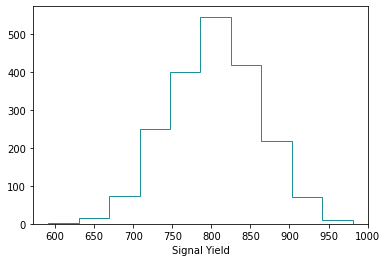

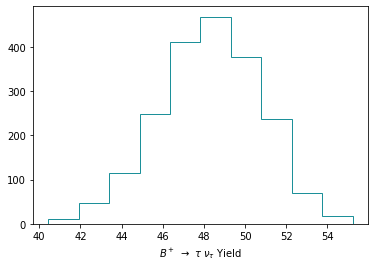

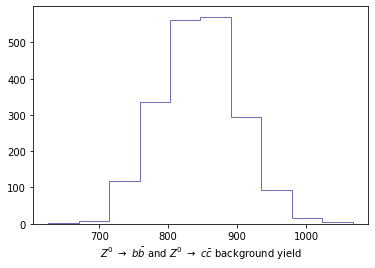

In [83]:
plt.figure()
plt.hist(pull_bc, histtype='step', color="#1c9099")
plt.xlabel('Signal Yield')
plt.plot()

plt.figure()
plt.hist(pull_bu, histtype='step', color="#1c9099")
plt.xlabel(r'$B^+$ $\rightarrow$ $\tau$ $\nu_\tau$ Yield')
plt.plot()

plt.figure()
plt.hist(pull_bb_cc, histtype='step', color="#756bb1")
plt.xlabel(r'$Z^0$ $\rightarrow$ $b\bar{b}$ and $Z^0$ $\rightarrow$ $c\bar{c}$ background yield')
plt.plot()
#counts_sig, bin_edges_sig = np.histogram(sig_yield)

In [ ]:
print(bu_yield)

In [ ]:
bkg_yield.max()

In [ ]:
len(sig_yield)

In [ ]:
np.sum(sig_yield == 0)

### Détermination de la moyenne pour les yields à l'aide d'une gaussienne

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 956.4                      │              Nfcn = 36               │
│ EDM = 2.26e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                  value    at limit
------------------  -------  ----------
mu_sig_[449863]         804       False
sigma_sig_[449863]    57.34       False


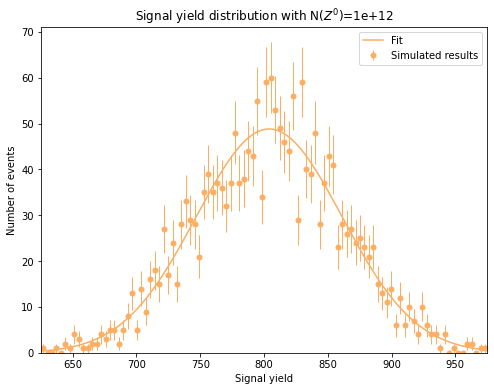

In [87]:
#Espace observable et data
min_sig = 625 #int(sig_yield.min())
max_sig = 975 #int(sig_yield.max()) + 1
obs = zfit.Space('x', limits=(min_sig,max_sig))
data = zfit.Data.from_numpy(obs=obs, array=pull_bc, weights=None) #

#Définition des paramètres
rand_int = random.randint(0,1000000,size=1)
mu_sig_ = zfit.Parameter(f"mu_sig_{rand_int}", 800.)
sigma_sig_ = zfit.Parameter(f"sigma_sig_{rand_int}", 50.)

#Fits
gauss = zfit.pdf.Gauss(obs=obs, mu=mu_sig_, sigma=sigma_sig_)
nll = zfit.loss.UnbinnedNLL(model=gauss, data=data )
minimizer = zfit.minimize.Minuit()
result_sig = minimizer.minimize(nll)

print(result_sig.info['original'])
print(result_sig.params)

#Plots

#Paramètre des histogrammes
nb_bins = 100
lower, upper = obs.limits
colour_bc = "#fdae61"

#Points du fit des yields de Bc+
x_plot_sig = np.linspace(lower[0][0], upper[0][0], num=1000)
y_plot_sig = zfit.run(gauss.pdf(x_plot_sig, norm_range=obs))

#Points de l'histogramme des yields de Bc+
counts_sig, bin_edges_sig = np.histogram(pull_bc, bins=nb_bins, range=(lower[0][0], upper[0][0]))
#

#Tracé du plot
plt.figure(figsize = [8,6])

mplhep.histplot((counts_sig, bin_edges_sig), 
                yerr = True, 
                color = colour_bc, 
                histtype='errorbar', 
                label="Simulated results")

plt.plot(x_plot_sig, 
         y_plot_sig * (len(pull_bc)/nb_bins*obs.area()), #
         color= colour_bc, 
         label= "Fit")

plt.xlabel("Signal yield")
plt.ylabel("Number of events")
plt.title("Signal yield pull distribution with N($Z^0$)={:.0e}".format(N_Z0))
plt.xlim(lower[0][0], upper[0][0])
plt.legend()

plt.show()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 70.75                      │              Nfcn = 72               │
│ EDM = 2.75e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                 value    at limit
-----------------  -------  ----------
mu_bu_[224630]        48.3       False
sigma_bu_[224630]    2.444       False


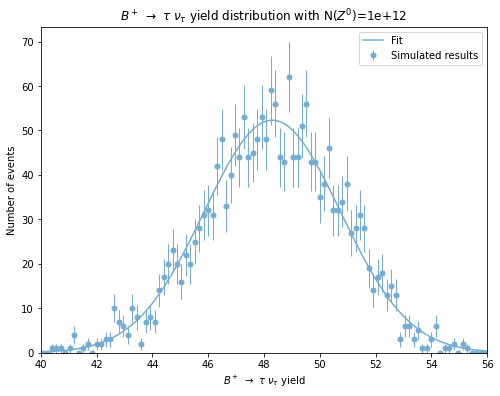

In [91]:
#Espace observable et data
min_bu = 40 #int(sig_yield.min())
max_bu = 56 #int(sig_yield.max())
obs_bu = zfit.Space('x', limits=(min_bu, max_bu))
data_bu = zfit.Data.from_numpy(obs=obs_bu, array=pull_bu, weights=None)

#Définition des paramètres
rand_int = random.randint(0,1000000,size=1)
mu_bu_ = zfit.Parameter(f"mu_bu_{rand_int}", 48.)
sigma_bu_ = zfit.Parameter(f"sigma_bu_{rand_int}", 50.)

#Fits
gauss = zfit.pdf.Gauss(obs=obs_bu, mu=mu_bu_, sigma=sigma_bu_)
nll = zfit.loss.UnbinnedNLL(model=gauss, data=data_bu )
minimizer = zfit.minimize.Minuit()
result_bu = minimizer.minimize(nll)

print(result_bu.info['original'])
print(result_bu.params)

#Plots

#Paramètre des histogrammes
nb_bins = 100
lower, upper = obs_bu.limits
colour_bu = "#74add1"
label_bu = r'$B^+$ $\rightarrow$ $\tau$ $\nu_\tau$ yield'

#Points du fit des yields de B+
x_plot_bu = np.linspace(lower[0][0], upper[0][0], num=1000)
y_plot_bu = zfit.run(gauss.pdf(x_plot_bu, norm_range=obs_bu))

#Points de l'histogramme des yields de B+
counts_bu, bin_edges_bu = np.histogram(pull_bu, bins=nb_bins, range=(lower[0][0], upper[0][0]))

#Tracé du plot
plt.figure(figsize = [8,6])

mplhep.histplot((counts_bu, bin_edges_bu),
                yerr = True, 
                color = colour_bu, 
                histtype='errorbar', 
                label="Simulated results")

plt.plot(x_plot_bu, 
         y_plot_bu * (len(pull_bu)/nb_bins*obs_bu.area()), 
         color= colour_bu, 
         label= "Fit")

plt.xlabel(label_bu)
plt.ylabel("Number of events")
plt.title(r"$B^+$ $\rightarrow$ $\tau$ $\nu_\tau$ yield pull distribution with N($Z^0$)={:.0e}".format(N_Z0))
plt.xlim(lower[0][0], upper[0][0])

plt.legend()
plt.show()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 198.7                      │              Nfcn = 46               │
│ EDM = 3.52e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                  value    at limit
------------------  -------  ----------
mu_bkg_[471446]       844.4       False
sigma_bkg_[816780]    55.41       False


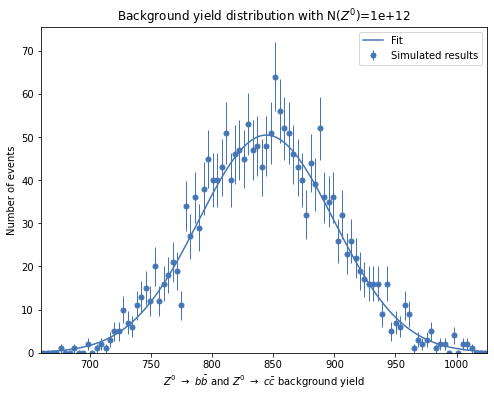

In [97]:
#Espace observable et data
min_bkg = 660 #int(bkg_yield.min())
max_bkg = 1025 #int(bkg_yield.max()) + 1
obs_bkg = zfit.Space('x', limits=(min_bkg,max_bkg))
data = zfit.Data.from_numpy(obs=obs_bkg, array=pull_bb_cc, weights=None)

#Définition des paramètres
rand_int = random.randint(0,1000000,size=1)
mu_bkg_ = zfit.Parameter(f"mu_bkg_{rand_int}", 800.)

rand_int = random.randint(0,1000000,size=1)
sigma_bkg_ = zfit.Parameter(f"sigma_bkg_{rand_int}", 50.)

#Fits
gauss = zfit.pdf.Gauss(obs=obs_bkg, mu=mu_bkg_, sigma=sigma_bkg_)
nll = zfit.loss.UnbinnedNLL(model=gauss, data=data )
minimizer = zfit.minimize.Minuit()
result_bkg = minimizer.minimize(nll)

print(result_bkg.info['original'])
print(result_bkg.params)

#Plots

#Paramètre des histogrammes
nb_bins = 100
lower, upper = obs_bkg.limits
colour_bb_cc = "#4575b4"#"#abd9e9"
label_bb_cc = r'$Z^0$ $\rightarrow$ $b\bar{b}$ and $Z^0$ $\rightarrow$ $c\bar{c}$ background yield'

#Points du fit des yields de Z->bb et Z->cc
x_plot_bkg = np.linspace(lower[0][0], upper[0][0], num=1000)
y_plot_bkg = zfit.run(gauss.pdf(x_plot_bkg, norm_range=obs_bkg))

#Points de l'histogramme des yields de Z->bb et Z->cc
counts_bkg, bin_edges_bkg = np.histogram(pull_bb_cc, bins=nb_bins, range=(lower[0][0], upper[0][0]))

#Tracé du plot
plt.figure(figsize=[8,6])

mplhep.histplot((counts_bkg, bin_edges_bkg), 
                yerr = True, 
                color = colour_bb_cc, 
                histtype='errorbar', 
                label="Simulated results")

plt.plot(x_plot_bkg, 
         y_plot_bkg * (len(pull_bb_cc)/nb_bins*obs.area()), 
         color= colour_bb_cc, 
         label= "Fit")

plt.xlabel(label_bb_cc)
plt.ylabel("Number of events")
plt.title("$Z^0$ $\rightarrow$ $b\bar{b}$ and $Z^0$ $\rightarrow$ $c\bar{c}$ yield pull distribution with N($Z^0$)={:.0e}".format(N_Z0))
plt.xlim(lower[0][0], upper[0][0])
plt.legend()
plt.show()
